In [1]:
# coding: utf-8
# 增加了test数据集

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import torchvision
from torchvision import datasets, models, transforms
import time
import os
import copy

print(torch.__version__)

os.environ["CUDA_VISIBLE_DEVICES"] = "3"

# 参数
learning_rate = 0.01
momentum = 0.9
epochs = 10
batch_size = 30
display_step = 1
num_classes = 45

# 加载模型

In [2]:
# 加载vgg13预训练模型
model = models.vgg13(pretrained=False)
model.classifier = nn.Sequential(nn.Linear(512 * 7 * 7, 4096),
                                 nn.ReLU(True),
                                 nn.Dropout(),
                                 nn.Linear(4096, 4096),
                                 nn.ReLU(True),
                                 nn.Dropout(),
                                 nn.Linear(4096, num_classes))
# 使用多块GPU
# model = nn.DataParallel(model)
# model.load_state_dict(torch.load('./parameter/ash_sand_1_16_vgg13_params.pth'))

# 数据集准备

In [3]:
# crop:裁剪 resize:缩放 flip:翻转
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.396, 0.434, 0.435], [0.055, 0.053, 0.054])
    ]),
    'validation': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.396, 0.434, 0.435], [0.055, 0.053, 0.054])
    ]),
}

# your image data file
data_dir = './images_paste/images_ash_sand_1_16/'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x]) for x in ['train', 'validation']}
# torchvision.datasets.ImageFolder返回的是list，这里用torch.utils.data.DataLoader类将list类型的输入数据封装成Tensor数据格式
dataloders = {x: torch.utils.data.DataLoader(image_datasets[x],
                                             batch_size = batch_size,
                                             shuffle = True,
                                             num_workers = 50) for x in ['train', 'validation']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'validation']}

In [4]:
data_transforms_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.396, 0.434, 0.435], [0.055, 0.053, 0.054])
])
data_dir_test = './images_paste/images_ash_sand_1_16/test/'
image_datasets_test = datasets.ImageFolder(data_dir_test, data_transforms_test)
dataloders_test = torch.utils.data.DataLoader(image_datasets_test,
                                             batch_size = batch_size,
                                             shuffle = False,
                                             num_workers = 50)

# 使用GPU，定义相关函数

In [5]:
# 是否使用GPU
use_gpu = torch.cuda.is_available()
if use_gpu:
    model = model.cuda()

print("use_gpu: " + str(use_gpu))
    
# 定义损失函数，这里采用交叉熵函数
loss_fn = nn.CrossEntropyLoss()

# 定义优化函数，这里采用随机梯度下降法
optimizer = optim.SGD(model.parameters(), learning_rate, momentum)

# 定义学习率的变化策略，这里采用torch.optim.lr_scheduler模块的StepLR类，表示每隔step_size个epoch就将学习率降为原来的gamma倍
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.5)

use_gpu: True


In [ ]:
def plot(epoch, loss_list, test_loss_list):
    clear_output(True)
    plt.title('epoch %s. train loss: %s. val loss: %s' % (epoch, loss_list[-1], test_loss_list[-1]))
    plt.plot(loss_list, color="r", label="train loss")
    plt.plot(test_loss_list, color="b", label="val loss")
    plt.legend(loc="best")
    plt.savefig('./figure/best_track_last_unet_dilate_reloss.png')
    plt.show()

# Train

In [ ]:
since = time.time()
best_model_wts = model.state_dict()
best_acc = 0
lowest_loss = 99999
loss_train = [] # 训练集loss
acc_train = [] # 训练集正确率
loss_val = [] # 验证集loss
acc_val = [] # 验证集正确率
best_matrix = [[0 for i in range(num_classes)] for i in range(num_classes)]
f = open('./result/ash_sand_1_16_vgg13_result.txt', 'a')

for epoch in range(epochs):
    exp_lr_scheduler.step()  # 调整学习率
    print('learning_rate: {}'.format(learning_rate))
    f.write('learning_rate: {}\n'.format(learning_rate))
    
    if epoch % display_step == 0:
        print('Epoch [{}/{}]:'.format(epoch + 1, epochs))
        f.write('Epoch [{}/{}]:\n'.format(epoch + 1, epochs))
        
    # 每一轮都跑一遍训练集和验证集
    for phase in ['train', 'validation']:
        if phase == 'train':
            model.train()  # 把module设成training模式，对Dropout和BatchNorm有影响
        else:
            model.eval()  # 把module设置为评估模式

        batch_num = 1
        running_loss = 0.0
        running_corrects = 0
        matrix = [[0 for i in range(num_classes)] for i in range(num_classes)]

        # Iterate over data.
        for data in dataloders[phase]:
            # get the inputs
            inputs, labels = data

            if use_gpu:
                inputs = inputs.cuda()
                labels = labels.cuda()

            # 先将网络中的所有梯度置0
            optimizer.zero_grad()

            # 网络的前向传播
            outputs = model(inputs)

            # 计算损失
            loss = loss_fn(outputs, labels)

            # 得到模型预测该样本属于哪个类别的信息
            _, preds = torch.max(outputs.data, 1)

            # 训练时，应用回传和优化
            if phase == 'train':
                loss.backward()
                optimizer.step()

            # 记录当前batch_size的loss以及数据对应的分类准确数量
            running_loss += loss.item()
            running_corrects += torch.sum(preds == labels.data)
            if phase == 'validation':
                for k in range(0, batch_size):
                    matrix[labels.data.cpu().numpy()[k]][preds.cpu().numpy()[k]] += 1

            print('\t{} {}-{}: Loss: {:.4f} Acc: {:.4f}%'.format(phase, epoch + 1, batch_num, loss.item()/batch_size, 1.0*torch.sum(preds == labels.data).item()/batch_size*100))
            f.write('\t{} {}-{}: Loss: {:.4f} Acc: {:.4f}%\n'.format(phase, epoch + 1, batch_num, loss.item()/batch_size, 1.0*torch.sum(preds == labels.data).item()/batch_size*100))
            batch_num = batch_num + 1

        # 计算并打印这一轮训练的loss和分类准确率
        if phase == 'train':
            epoch_loss_train = running_loss / dataset_sizes['train']
            epoch_acc_train = running_corrects.item() / dataset_sizes['train']
            loss_train.append(epoch_loss_train)
            acc_train.append(epoch_acc_train)            
        else:
            epoch_loss_val = running_loss / dataset_sizes['validation']
            epoch_acc_val = running_corrects.item() / dataset_sizes['validation']
            loss_val.append(epoch_loss_val)
            acc_val.append(epoch_acc_val)

        if epoch % display_step == 0 and phase == 'validation':
            print('\ttrain Loss: {:.4f} Acc: {:.4f}%'.format(epoch_loss_train, epoch_acc_train*100))
            print('\tvalidation Loss: {:.4f} Acc: {:.4f}%'.format(epoch_loss_val, epoch_acc_val*100))
            f.write('\ttrain Loss: {:.4f} Acc: {:.4f}%\n'.format(epoch_loss_train, epoch_acc_train*100))
            f.write('\tvalidation Loss: {:.4f} Acc: {:.4f}%\n'.format(epoch_loss_val, epoch_acc_val*100))

        # 保存验证集loss最低的模型参数
        if phase == 'validation' and epoch_loss_val < lowest_loss:
            lowest_loss = epoch_loss_val
            best_acc = epoch_acc_val
            best_model_wts = model.state_dict()
            print("Network parameter update.")
            f.write("Network parameter update.\n")
            # 保存最优参数
            torch.save(best_model_wts, './parameter/ash_sand_1_16_vgg13_params.pth')
            best_matrix = copy.deepcopy(matrix)
    time_elapsed = time.time() - since
    print('Time passed {:.0f}h {:.0f}m {:.0f}s'.format(time_elapsed // 3600, (time_elapsed % 3600) // 60, time_elapsed % 60))
    print('-' * 20)
    f.write('Time passed {:.0f}h {:.0f}m {:.0f}s\n'.format(time_elapsed // 3600, (time_elapsed % 3600) // 60, time_elapsed % 60))
    f.write('-' * 20 + "\n")

# 计算训练所耗时间
time_elapsed = time.time() - since
print('Training complete in {:.0f}h {:.0f}m {:.0f}s'.format(time_elapsed // 3600, (time_elapsed % 3600) // 60, time_elapsed % 60))
print('Best validation Acc: {:4f}'.format(best_acc))
f.write('Training complete in {:.0f}h {:.0f}m {:.0f}s\n'.format(time_elapsed // 3600, (time_elapsed % 3600) // 60, time_elapsed % 60))
f.write('Best validation Acc: {:4f}\n'.format(best_acc))
f.close()

learning_rate: 0.01
Epoch [1/10]:
	train 1-1: Loss: 0.1268 Acc: 3.3333%
	train 1-2: Loss: 0.1270 Acc: 3.3333%
	train 1-3: Loss: 0.1272 Acc: 3.3333%
	train 1-4: Loss: 0.1279 Acc: 0.0000%
	train 1-5: Loss: 0.1288 Acc: 0.0000%
	train 1-6: Loss: 0.1278 Acc: 0.0000%
	train 1-7: Loss: 0.1288 Acc: 3.3333%
	train 1-8: Loss: 0.1267 Acc: 6.6667%
	train 1-9: Loss: 0.1298 Acc: 6.6667%
	train 1-10: Loss: 0.1288 Acc: 0.0000%
	train 1-11: Loss: 0.1257 Acc: 3.3333%
	train 1-12: Loss: 0.1269 Acc: 0.0000%
	train 1-13: Loss: 0.1287 Acc: 0.0000%
	train 1-14: Loss: 0.1270 Acc: 0.0000%
	train 1-15: Loss: 0.1264 Acc: 6.6667%
	train 1-16: Loss: 0.1267 Acc: 6.6667%
	train 1-17: Loss: 0.1266 Acc: 3.3333%
	train 1-18: Loss: 0.1284 Acc: 0.0000%
	train 1-19: Loss: 0.1273 Acc: 0.0000%
	train 1-20: Loss: 0.1269 Acc: 3.3333%
	train 1-21: Loss: 0.1257 Acc: 6.6667%
	train 1-22: Loss: 0.1277 Acc: 0.0000%
	train 1-23: Loss: 0.1271 Acc: 0.0000%
	train 1-24: Loss: 0.1257 Acc: 6.6667%
	train 1-25: Loss: 0.1267 Acc: 0.0000%


	train 1-208: Loss: 0.1160 Acc: 13.3333%
	train 1-209: Loss: 0.1199 Acc: 0.0000%
	train 1-210: Loss: 0.1133 Acc: 6.6667%
	train 1-211: Loss: 0.1235 Acc: 6.6667%
	train 1-212: Loss: 0.1146 Acc: 10.0000%
	train 1-213: Loss: 0.1180 Acc: 0.0000%
	train 1-214: Loss: 0.1237 Acc: 3.3333%
	train 1-215: Loss: 0.1197 Acc: 6.6667%
	train 1-216: Loss: 0.1189 Acc: 3.3333%
	train 1-217: Loss: 0.1111 Acc: 0.0000%
	train 1-218: Loss: 0.1166 Acc: 10.0000%
	train 1-219: Loss: 0.1244 Acc: 3.3333%
	train 1-220: Loss: 0.1107 Acc: 10.0000%
	train 1-221: Loss: 0.1142 Acc: 13.3333%
	train 1-222: Loss: 0.1099 Acc: 10.0000%
	train 1-223: Loss: 0.1122 Acc: 3.3333%
	train 1-224: Loss: 0.1187 Acc: 3.3333%
	train 1-225: Loss: 0.1098 Acc: 6.6667%
	train 1-226: Loss: 0.1166 Acc: 10.0000%
	train 1-227: Loss: 0.1133 Acc: 10.0000%
	train 1-228: Loss: 0.1090 Acc: 3.3333%
	train 1-229: Loss: 0.1118 Acc: 6.6667%
	train 1-230: Loss: 0.1136 Acc: 3.3333%
	train 1-231: Loss: 0.1175 Acc: 6.6667%
	train 1-232: Loss: 0.1066 Acc: 

	train 1-410: Loss: 0.0785 Acc: 23.3333%
	train 1-411: Loss: 0.0868 Acc: 23.3333%
	train 1-412: Loss: 0.0707 Acc: 26.6667%
	train 1-413: Loss: 0.0699 Acc: 33.3333%
	train 1-414: Loss: 0.0892 Acc: 23.3333%
	train 1-415: Loss: 0.0910 Acc: 10.0000%
	train 1-416: Loss: 0.0686 Acc: 43.3333%
	train 1-417: Loss: 0.0754 Acc: 40.0000%
	train 1-418: Loss: 0.0655 Acc: 40.0000%
	train 1-419: Loss: 0.0789 Acc: 23.3333%
	train 1-420: Loss: 0.0779 Acc: 30.0000%
	train 1-421: Loss: 0.0775 Acc: 16.6667%
	train 1-422: Loss: 0.0669 Acc: 40.0000%
	train 1-423: Loss: 0.0862 Acc: 13.3333%
	train 1-424: Loss: 0.0809 Acc: 40.0000%
	train 1-425: Loss: 0.0812 Acc: 20.0000%
	train 1-426: Loss: 0.0781 Acc: 20.0000%
	train 1-427: Loss: 0.0779 Acc: 30.0000%
	train 1-428: Loss: 0.0724 Acc: 36.6667%
	train 1-429: Loss: 0.0788 Acc: 26.6667%
	train 1-430: Loss: 0.0549 Acc: 46.6667%
	train 1-431: Loss: 0.0764 Acc: 33.3333%
	train 1-432: Loss: 0.1017 Acc: 20.0000%
	train 1-433: Loss: 0.0740 Acc: 33.3333%
	train 1-434: Lo

	train 1-610: Loss: 0.0517 Acc: 50.0000%
	train 1-611: Loss: 0.0448 Acc: 43.3333%
	train 1-612: Loss: 0.0471 Acc: 53.3333%
	train 1-613: Loss: 0.0456 Acc: 53.3333%
	train 1-614: Loss: 0.0432 Acc: 56.6667%
	train 1-615: Loss: 0.0577 Acc: 56.6667%
	train 1-616: Loss: 0.0632 Acc: 43.3333%
	train 1-617: Loss: 0.0490 Acc: 63.3333%
	train 1-618: Loss: 0.0607 Acc: 33.3333%
	train 1-619: Loss: 0.0486 Acc: 40.0000%
	train 1-620: Loss: 0.0724 Acc: 33.3333%
	train 1-621: Loss: 0.0579 Acc: 46.6667%
	train 1-622: Loss: 0.0579 Acc: 46.6667%
	train 1-623: Loss: 0.0560 Acc: 43.3333%
	train 1-624: Loss: 0.0458 Acc: 63.3333%
	train 1-625: Loss: 0.0500 Acc: 60.0000%
	train 1-626: Loss: 0.0476 Acc: 56.6667%
	train 1-627: Loss: 0.0531 Acc: 50.0000%
	train 1-628: Loss: 0.0463 Acc: 53.3333%
	train 1-629: Loss: 0.0409 Acc: 60.0000%
	train 1-630: Loss: 0.0490 Acc: 50.0000%
	train 1-631: Loss: 0.0500 Acc: 46.6667%
	train 1-632: Loss: 0.0360 Acc: 60.0000%
	train 1-633: Loss: 0.0343 Acc: 66.6667%
	train 1-634: Lo

	train 1-810: Loss: 0.0321 Acc: 63.3333%
	train 1-811: Loss: 0.0298 Acc: 63.3333%
	train 1-812: Loss: 0.0478 Acc: 46.6667%
	train 1-813: Loss: 0.0404 Acc: 60.0000%
	train 1-814: Loss: 0.0431 Acc: 60.0000%
	train 1-815: Loss: 0.0448 Acc: 70.0000%
	train 1-816: Loss: 0.0365 Acc: 60.0000%
	train 1-817: Loss: 0.0403 Acc: 56.6667%
	train 1-818: Loss: 0.0442 Acc: 50.0000%
	train 1-819: Loss: 0.0472 Acc: 53.3333%
	train 1-820: Loss: 0.0355 Acc: 60.0000%
	train 1-821: Loss: 0.0369 Acc: 60.0000%
	train 1-822: Loss: 0.0292 Acc: 70.0000%
	train 1-823: Loss: 0.0293 Acc: 70.0000%
	train 1-824: Loss: 0.0211 Acc: 73.3333%
	train 1-825: Loss: 0.0343 Acc: 63.3333%
	train 1-826: Loss: 0.0329 Acc: 66.6667%
	train 1-827: Loss: 0.0237 Acc: 76.6667%
	train 1-828: Loss: 0.0464 Acc: 50.0000%
	train 1-829: Loss: 0.0440 Acc: 60.0000%
	train 1-830: Loss: 0.0475 Acc: 63.3333%
	train 1-831: Loss: 0.0390 Acc: 53.3333%
	train 1-832: Loss: 0.0272 Acc: 70.0000%
	train 1-833: Loss: 0.0340 Acc: 53.3333%
	train 1-834: Lo

	train 1-1010: Loss: 0.0189 Acc: 90.0000%
	train 1-1011: Loss: 0.0251 Acc: 76.6667%
	train 1-1012: Loss: 0.0188 Acc: 70.0000%
	train 1-1013: Loss: 0.0373 Acc: 63.3333%
	train 1-1014: Loss: 0.0269 Acc: 73.3333%
	train 1-1015: Loss: 0.0177 Acc: 80.0000%
	train 1-1016: Loss: 0.0265 Acc: 73.3333%
	train 1-1017: Loss: 0.0242 Acc: 76.6667%
	train 1-1018: Loss: 0.0206 Acc: 73.3333%
	train 1-1019: Loss: 0.0176 Acc: 80.0000%
	train 1-1020: Loss: 0.0292 Acc: 66.6667%
	train 1-1021: Loss: 0.0296 Acc: 73.3333%
	train 1-1022: Loss: 0.0154 Acc: 86.6667%
	train 1-1023: Loss: 0.0315 Acc: 66.6667%
	train 1-1024: Loss: 0.0294 Acc: 60.0000%
	train 1-1025: Loss: 0.0291 Acc: 70.0000%
	train 1-1026: Loss: 0.0228 Acc: 70.0000%
	train 1-1027: Loss: 0.0202 Acc: 80.0000%
	train 1-1028: Loss: 0.0196 Acc: 76.6667%
	train 1-1029: Loss: 0.0239 Acc: 80.0000%
	train 1-1030: Loss: 0.0237 Acc: 73.3333%
	train 1-1031: Loss: 0.0176 Acc: 80.0000%
	train 1-1032: Loss: 0.0237 Acc: 66.6667%
	train 1-1033: Loss: 0.0191 Acc: 8

	train 1-1206: Loss: 0.0208 Acc: 80.0000%
	train 1-1207: Loss: 0.0204 Acc: 83.3333%
	train 1-1208: Loss: 0.0148 Acc: 90.0000%
	train 1-1209: Loss: 0.0153 Acc: 83.3333%
	train 1-1210: Loss: 0.0184 Acc: 73.3333%
	train 1-1211: Loss: 0.0302 Acc: 73.3333%
	train 1-1212: Loss: 0.0214 Acc: 80.0000%
	train 1-1213: Loss: 0.0091 Acc: 90.0000%
	train 1-1214: Loss: 0.0151 Acc: 80.0000%
	train 1-1215: Loss: 0.0176 Acc: 76.6667%
	train 1-1216: Loss: 0.0262 Acc: 80.0000%
	train 1-1217: Loss: 0.0124 Acc: 90.0000%
	train 1-1218: Loss: 0.0240 Acc: 76.6667%
	train 1-1219: Loss: 0.0130 Acc: 86.6667%
	train 1-1220: Loss: 0.0225 Acc: 70.0000%
	train 1-1221: Loss: 0.0246 Acc: 70.0000%
	train 1-1222: Loss: 0.0190 Acc: 83.3333%
	train 1-1223: Loss: 0.0268 Acc: 76.6667%
	train 1-1224: Loss: 0.0208 Acc: 80.0000%
	train 1-1225: Loss: 0.0168 Acc: 90.0000%
	train 1-1226: Loss: 0.0182 Acc: 83.3333%
	train 1-1227: Loss: 0.0233 Acc: 73.3333%
	train 1-1228: Loss: 0.0155 Acc: 83.3333%
	train 1-1229: Loss: 0.0072 Acc: 1

	train 1-1402: Loss: 0.0042 Acc: 90.0000%
	train 1-1403: Loss: 0.0077 Acc: 90.0000%
	train 1-1404: Loss: 0.0069 Acc: 90.0000%
	train 1-1405: Loss: 0.0054 Acc: 93.3333%
	train 1-1406: Loss: 0.0173 Acc: 80.0000%
	train 1-1407: Loss: 0.0303 Acc: 66.6667%
	train 1-1408: Loss: 0.0189 Acc: 73.3333%
	train 1-1409: Loss: 0.0197 Acc: 76.6667%
	train 1-1410: Loss: 0.0125 Acc: 83.3333%
	train 1-1411: Loss: 0.0117 Acc: 83.3333%
	train 1-1412: Loss: 0.0204 Acc: 73.3333%
	train 1-1413: Loss: 0.0243 Acc: 83.3333%
	train 1-1414: Loss: 0.0288 Acc: 73.3333%
	train 1-1415: Loss: 0.0116 Acc: 83.3333%
	train 1-1416: Loss: 0.0125 Acc: 86.6667%
	train 1-1417: Loss: 0.0220 Acc: 83.3333%
	train 1-1418: Loss: 0.0104 Acc: 86.6667%
	train 1-1419: Loss: 0.0171 Acc: 80.0000%
	train 1-1420: Loss: 0.0142 Acc: 80.0000%
	train 1-1421: Loss: 0.0140 Acc: 90.0000%
	train 1-1422: Loss: 0.0151 Acc: 83.3333%
	train 1-1423: Loss: 0.0122 Acc: 80.0000%
	train 1-1424: Loss: 0.0174 Acc: 83.3333%
	train 1-1425: Loss: 0.0092 Acc: 9

	train 1-1597: Loss: 0.0061 Acc: 93.3333%
	train 1-1598: Loss: 0.0143 Acc: 83.3333%
	train 1-1599: Loss: 0.0087 Acc: 90.0000%
	train 1-1600: Loss: 0.0085 Acc: 86.6667%
	train 1-1601: Loss: 0.0140 Acc: 80.0000%
	train 1-1602: Loss: 0.0047 Acc: 93.3333%
	train 1-1603: Loss: 0.0113 Acc: 93.3333%
	train 1-1604: Loss: 0.0153 Acc: 76.6667%
	train 1-1605: Loss: 0.0122 Acc: 83.3333%
	train 1-1606: Loss: 0.0086 Acc: 90.0000%
	train 1-1607: Loss: 0.0142 Acc: 90.0000%
	train 1-1608: Loss: 0.0097 Acc: 93.3333%
	train 1-1609: Loss: 0.0051 Acc: 93.3333%
	train 1-1610: Loss: 0.0129 Acc: 86.6667%
	train 1-1611: Loss: 0.0105 Acc: 93.3333%
	train 1-1612: Loss: 0.0078 Acc: 86.6667%
	train 1-1613: Loss: 0.0189 Acc: 86.6667%
	train 1-1614: Loss: 0.0029 Acc: 100.0000%
	train 1-1615: Loss: 0.0033 Acc: 96.6667%
	train 1-1616: Loss: 0.0029 Acc: 100.0000%
	train 1-1617: Loss: 0.0119 Acc: 86.6667%
	train 1-1618: Loss: 0.0178 Acc: 80.0000%
	train 1-1619: Loss: 0.0108 Acc: 86.6667%
	train 1-1620: Loss: 0.0065 Acc:

	train 1-1792: Loss: 0.0168 Acc: 86.6667%
	train 1-1793: Loss: 0.0097 Acc: 86.6667%
	train 1-1794: Loss: 0.0124 Acc: 90.0000%
	train 1-1795: Loss: 0.0191 Acc: 76.6667%
	train 1-1796: Loss: 0.0086 Acc: 86.6667%
	train 1-1797: Loss: 0.0121 Acc: 93.3333%
	train 1-1798: Loss: 0.0097 Acc: 93.3333%
	train 1-1799: Loss: 0.0110 Acc: 83.3333%
	train 1-1800: Loss: 0.0036 Acc: 96.6667%
	train 1-1801: Loss: 0.0149 Acc: 80.0000%
	train 1-1802: Loss: 0.0180 Acc: 86.6667%
	train 1-1803: Loss: 0.0075 Acc: 86.6667%
	train 1-1804: Loss: 0.0110 Acc: 86.6667%
	train 1-1805: Loss: 0.0075 Acc: 90.0000%
	train 1-1806: Loss: 0.0108 Acc: 93.3333%
	train 1-1807: Loss: 0.0090 Acc: 86.6667%
	train 1-1808: Loss: 0.0167 Acc: 86.6667%
	train 1-1809: Loss: 0.0089 Acc: 86.6667%
	train 1-1810: Loss: 0.0026 Acc: 96.6667%
	train 1-1811: Loss: 0.0178 Acc: 86.6667%
	train 1-1812: Loss: 0.0181 Acc: 83.3333%
	train 1-1813: Loss: 0.0176 Acc: 83.3333%
	train 1-1814: Loss: 0.0121 Acc: 83.3333%
	train 1-1815: Loss: 0.0115 Acc: 9

	train 1-1987: Loss: 0.0064 Acc: 90.0000%
	train 1-1988: Loss: 0.0059 Acc: 93.3333%
	train 1-1989: Loss: 0.0053 Acc: 93.3333%
	train 1-1990: Loss: 0.0086 Acc: 93.3333%
	train 1-1991: Loss: 0.0013 Acc: 100.0000%
	train 1-1992: Loss: 0.0081 Acc: 93.3333%
	train 1-1993: Loss: 0.0019 Acc: 96.6667%
	train 1-1994: Loss: 0.0318 Acc: 80.0000%
	train 1-1995: Loss: 0.0123 Acc: 93.3333%
	train 1-1996: Loss: 0.0131 Acc: 90.0000%
	train 1-1997: Loss: 0.0273 Acc: 80.0000%
	train 1-1998: Loss: 0.0111 Acc: 83.3333%
	train 1-1999: Loss: 0.0108 Acc: 93.3333%
	train 1-2000: Loss: 0.0087 Acc: 93.3333%
	train 1-2001: Loss: 0.0107 Acc: 83.3333%
	train 1-2002: Loss: 0.0082 Acc: 93.3333%
	train 1-2003: Loss: 0.0170 Acc: 80.0000%
	train 1-2004: Loss: 0.0105 Acc: 93.3333%
	train 1-2005: Loss: 0.0107 Acc: 90.0000%
	train 1-2006: Loss: 0.0116 Acc: 83.3333%
	train 1-2007: Loss: 0.0017 Acc: 100.0000%
	train 1-2008: Loss: 0.0063 Acc: 93.3333%
	train 1-2009: Loss: 0.0093 Acc: 90.0000%
	train 1-2010: Loss: 0.0092 Acc:

	train 1-2182: Loss: 0.0033 Acc: 96.6667%
	train 1-2183: Loss: 0.0044 Acc: 90.0000%
	train 1-2184: Loss: 0.0027 Acc: 96.6667%
	train 1-2185: Loss: 0.0033 Acc: 96.6667%
	train 1-2186: Loss: 0.0008 Acc: 100.0000%
	train 1-2187: Loss: 0.0013 Acc: 100.0000%
	train 1-2188: Loss: 0.0024 Acc: 96.6667%
	train 1-2189: Loss: 0.0102 Acc: 90.0000%
	train 1-2190: Loss: 0.0047 Acc: 96.6667%
	train 1-2191: Loss: 0.0056 Acc: 96.6667%
	train 1-2192: Loss: 0.0177 Acc: 90.0000%
	train 1-2193: Loss: 0.0186 Acc: 90.0000%
	train 1-2194: Loss: 0.0084 Acc: 93.3333%
	train 1-2195: Loss: 0.0116 Acc: 86.6667%
	train 1-2196: Loss: 0.0245 Acc: 76.6667%
	train 1-2197: Loss: 0.0062 Acc: 90.0000%
	train 1-2198: Loss: 0.0009 Acc: 100.0000%
	train 1-2199: Loss: 0.0085 Acc: 90.0000%
	train 1-2200: Loss: 0.0104 Acc: 90.0000%
	train 1-2201: Loss: 0.0050 Acc: 96.6667%
	train 1-2202: Loss: 0.0096 Acc: 90.0000%
	train 1-2203: Loss: 0.0079 Acc: 93.3333%
	train 1-2204: Loss: 0.0116 Acc: 90.0000%
	train 1-2205: Loss: 0.0051 Acc

	train 1-2377: Loss: 0.0053 Acc: 96.6667%
	train 1-2378: Loss: 0.0101 Acc: 86.6667%
	train 1-2379: Loss: 0.0034 Acc: 96.6667%
	train 1-2380: Loss: 0.0013 Acc: 96.6667%
	train 1-2381: Loss: 0.0021 Acc: 96.6667%
	train 1-2382: Loss: 0.0002 Acc: 100.0000%
	train 1-2383: Loss: 0.0045 Acc: 93.3333%
	train 1-2384: Loss: 0.0032 Acc: 96.6667%
	train 1-2385: Loss: 0.0010 Acc: 100.0000%
	train 1-2386: Loss: 0.0010 Acc: 100.0000%
	train 1-2387: Loss: 0.0021 Acc: 93.3333%
	train 1-2388: Loss: 0.0076 Acc: 86.6667%
	train 1-2389: Loss: 0.0035 Acc: 96.6667%
	train 1-2390: Loss: 0.0117 Acc: 90.0000%
	train 1-2391: Loss: 0.0006 Acc: 100.0000%
	train 1-2392: Loss: 0.0057 Acc: 96.6667%
	train 1-2393: Loss: 0.0011 Acc: 100.0000%
	train 1-2394: Loss: 0.0028 Acc: 96.6667%
	train 1-2395: Loss: 0.0068 Acc: 93.3333%
	train 1-2396: Loss: 0.0056 Acc: 93.3333%
	train 1-2397: Loss: 0.0010 Acc: 100.0000%
	train 1-2398: Loss: 0.0028 Acc: 96.6667%
	train 1-2399: Loss: 0.0110 Acc: 90.0000%
	train 1-2400: Loss: 0.0058 

	train 1-2571: Loss: 0.0029 Acc: 96.6667%
	train 1-2572: Loss: 0.0055 Acc: 96.6667%
	train 1-2573: Loss: 0.0178 Acc: 90.0000%
	train 1-2574: Loss: 0.0005 Acc: 100.0000%
	train 1-2575: Loss: 0.0039 Acc: 96.6667%
	train 1-2576: Loss: 0.0185 Acc: 86.6667%
	train 1-2577: Loss: 0.0062 Acc: 93.3333%
	train 1-2578: Loss: 0.0058 Acc: 93.3333%
	train 1-2579: Loss: 0.0219 Acc: 86.6667%
	train 1-2580: Loss: 0.0049 Acc: 96.6667%
	train 1-2581: Loss: 0.0085 Acc: 93.3333%
	train 1-2582: Loss: 0.0013 Acc: 100.0000%
	train 1-2583: Loss: 0.0104 Acc: 93.3333%
	train 1-2584: Loss: 0.0182 Acc: 83.3333%
	train 1-2585: Loss: 0.0065 Acc: 93.3333%
	train 1-2586: Loss: 0.0069 Acc: 93.3333%
	train 1-2587: Loss: 0.0259 Acc: 86.6667%
	train 1-2588: Loss: 0.0288 Acc: 83.3333%
	train 1-2589: Loss: 0.0030 Acc: 96.6667%
	train 1-2590: Loss: 0.0056 Acc: 96.6667%
	train 1-2591: Loss: 0.0126 Acc: 83.3333%
	train 1-2592: Loss: 0.0104 Acc: 86.6667%
	train 1-2593: Loss: 0.0174 Acc: 83.3333%
	train 1-2594: Loss: 0.0153 Acc:

	train 1-2765: Loss: 0.0071 Acc: 90.0000%
	train 1-2766: Loss: 0.0034 Acc: 96.6667%
	train 1-2767: Loss: 0.0057 Acc: 96.6667%
	train 1-2768: Loss: 0.0057 Acc: 93.3333%
	train 1-2769: Loss: 0.0018 Acc: 100.0000%
	train 1-2770: Loss: 0.0031 Acc: 100.0000%
	train 1-2771: Loss: 0.0053 Acc: 93.3333%
	train 1-2772: Loss: 0.0101 Acc: 86.6667%
	train 1-2773: Loss: 0.0049 Acc: 90.0000%
	train 1-2774: Loss: 0.0048 Acc: 93.3333%
	train 1-2775: Loss: 0.0070 Acc: 93.3333%
	train 1-2776: Loss: 0.0038 Acc: 96.6667%
	train 1-2777: Loss: 0.0027 Acc: 96.6667%
	train 1-2778: Loss: 0.0002 Acc: 100.0000%
	train 1-2779: Loss: 0.0002 Acc: 100.0000%
	train 1-2780: Loss: 0.0018 Acc: 100.0000%
	train 1-2781: Loss: 0.0004 Acc: 100.0000%
	train 1-2782: Loss: 0.0049 Acc: 96.6667%
	train 1-2783: Loss: 0.0022 Acc: 100.0000%
	train 1-2784: Loss: 0.0018 Acc: 96.6667%
	train 1-2785: Loss: 0.0050 Acc: 96.6667%
	train 1-2786: Loss: 0.0188 Acc: 83.3333%
	train 1-2787: Loss: 0.0115 Acc: 93.3333%
	train 1-2788: Loss: 0.0024

	train 1-2959: Loss: 0.0013 Acc: 100.0000%
	train 1-2960: Loss: 0.0030 Acc: 96.6667%
	train 1-2961: Loss: 0.0086 Acc: 96.6667%
	train 1-2962: Loss: 0.0009 Acc: 100.0000%
	train 1-2963: Loss: 0.0027 Acc: 96.6667%
	train 1-2964: Loss: 0.0101 Acc: 93.3333%
	train 1-2965: Loss: 0.0060 Acc: 96.6667%
	train 1-2966: Loss: 0.0016 Acc: 100.0000%
	train 1-2967: Loss: 0.0006 Acc: 100.0000%
	train 1-2968: Loss: 0.0059 Acc: 93.3333%
	train 1-2969: Loss: 0.0015 Acc: 96.6667%
	train 1-2970: Loss: 0.0019 Acc: 100.0000%
	train 1-2971: Loss: 0.0047 Acc: 96.6667%
	train 1-2972: Loss: 0.0035 Acc: 96.6667%
	train 1-2973: Loss: 0.0030 Acc: 96.6667%
	train 1-2974: Loss: 0.0062 Acc: 96.6667%
	train 1-2975: Loss: 0.0084 Acc: 90.0000%
	train 1-2976: Loss: 0.0031 Acc: 96.6667%
	train 1-2977: Loss: 0.0047 Acc: 96.6667%
	train 1-2978: Loss: 0.0038 Acc: 96.6667%
	train 1-2979: Loss: 0.0063 Acc: 96.6667%
	train 1-2980: Loss: 0.0089 Acc: 90.0000%
	train 1-2981: Loss: 0.0021 Acc: 96.6667%
	train 1-2982: Loss: 0.0007 A

	train 1-3153: Loss: 0.0004 Acc: 100.0000%
	train 1-3154: Loss: 0.0008 Acc: 100.0000%
	train 1-3155: Loss: 0.0028 Acc: 96.6667%
	train 1-3156: Loss: 0.0012 Acc: 96.6667%
	train 1-3157: Loss: 0.0017 Acc: 96.6667%
	train 1-3158: Loss: 0.0038 Acc: 96.6667%
	train 1-3159: Loss: 0.0033 Acc: 96.6667%
	train 1-3160: Loss: 0.0005 Acc: 100.0000%
	train 1-3161: Loss: 0.0032 Acc: 96.6667%
	train 1-3162: Loss: 0.0003 Acc: 100.0000%
	train 1-3163: Loss: 0.0006 Acc: 100.0000%
	train 1-3164: Loss: 0.0001 Acc: 100.0000%
	train 1-3165: Loss: 0.0000 Acc: 100.0000%
	train 1-3166: Loss: 0.0008 Acc: 100.0000%
	train 1-3167: Loss: 0.0100 Acc: 93.3333%
	train 1-3168: Loss: 0.0008 Acc: 100.0000%
	train 1-3169: Loss: 0.0002 Acc: 100.0000%
	train 1-3170: Loss: 0.0032 Acc: 96.6667%
	train 1-3171: Loss: 0.0114 Acc: 93.3333%
	train 1-3172: Loss: 0.0108 Acc: 93.3333%
	train 1-3173: Loss: 0.0010 Acc: 100.0000%
	train 1-3174: Loss: 0.0010 Acc: 96.6667%
	train 1-3175: Loss: 0.0001 Acc: 100.0000%
	train 1-3176: Loss: 0

	train 1-3347: Loss: 0.0017 Acc: 100.0000%
	train 1-3348: Loss: 0.0012 Acc: 100.0000%
	train 1-3349: Loss: 0.0046 Acc: 93.3333%
	train 1-3350: Loss: 0.0005 Acc: 100.0000%
	train 1-3351: Loss: 0.0006 Acc: 100.0000%
	train 1-3352: Loss: 0.0005 Acc: 100.0000%
	train 1-3353: Loss: 0.0057 Acc: 93.3333%
	train 1-3354: Loss: 0.0006 Acc: 100.0000%
	train 1-3355: Loss: 0.0023 Acc: 96.6667%
	train 1-3356: Loss: 0.0058 Acc: 93.3333%
	train 1-3357: Loss: 0.0047 Acc: 93.3333%
	train 1-3358: Loss: 0.0086 Acc: 93.3333%
	train 1-3359: Loss: 0.0003 Acc: 100.0000%
	train 1-3360: Loss: 0.0007 Acc: 100.0000%
	train 1-3361: Loss: 0.0022 Acc: 96.6667%
	train 1-3362: Loss: 0.0004 Acc: 100.0000%
	train 1-3363: Loss: 0.0006 Acc: 100.0000%
	train 1-3364: Loss: 0.0005 Acc: 100.0000%
	train 1-3365: Loss: 0.0091 Acc: 93.3333%
	train 1-3366: Loss: 0.0013 Acc: 96.6667%
	train 1-3367: Loss: 0.0003 Acc: 100.0000%
	train 1-3368: Loss: 0.0045 Acc: 93.3333%
	train 1-3369: Loss: 0.0003 Acc: 100.0000%
	train 1-3370: Loss: 

	train 1-3541: Loss: 0.0082 Acc: 96.6667%
	train 1-3542: Loss: 0.0111 Acc: 96.6667%
	train 1-3543: Loss: 0.0001 Acc: 100.0000%
	train 1-3544: Loss: 0.0074 Acc: 96.6667%
	train 1-3545: Loss: 0.0059 Acc: 96.6667%
	train 1-3546: Loss: 0.0003 Acc: 100.0000%
	train 1-3547: Loss: 0.0029 Acc: 96.6667%
	train 1-3548: Loss: 0.0026 Acc: 96.6667%
	train 1-3549: Loss: 0.0055 Acc: 96.6667%
	train 1-3550: Loss: 0.0150 Acc: 93.3333%
	train 1-3551: Loss: 0.0010 Acc: 100.0000%
	train 1-3552: Loss: 0.0022 Acc: 93.3333%
	train 1-3553: Loss: 0.0015 Acc: 96.6667%
	train 1-3554: Loss: 0.0019 Acc: 96.6667%
	train 1-3555: Loss: 0.0006 Acc: 100.0000%
	train 1-3556: Loss: 0.0003 Acc: 100.0000%
	train 1-3557: Loss: 0.0006 Acc: 100.0000%
	train 1-3558: Loss: 0.0020 Acc: 100.0000%
	train 1-3559: Loss: 0.0005 Acc: 100.0000%
	train 1-3560: Loss: 0.0013 Acc: 100.0000%
	train 1-3561: Loss: 0.0002 Acc: 100.0000%
	train 1-3562: Loss: 0.0002 Acc: 100.0000%
	train 1-3563: Loss: 0.0109 Acc: 90.0000%
	train 1-3564: Loss: 0.

	train 1-3734: Loss: 0.0002 Acc: 100.0000%
	train 1-3735: Loss: 0.0007 Acc: 100.0000%
	train 1-3736: Loss: 0.0011 Acc: 100.0000%
	train 1-3737: Loss: 0.0004 Acc: 100.0000%
	train 1-3738: Loss: 0.0004 Acc: 100.0000%
	train 1-3739: Loss: 0.0049 Acc: 96.6667%
	train 1-3740: Loss: 0.0285 Acc: 93.3333%
	train 1-3741: Loss: 0.0009 Acc: 100.0000%
	train 1-3742: Loss: 0.0015 Acc: 96.6667%
	train 1-3743: Loss: 0.0032 Acc: 96.6667%
	train 1-3744: Loss: 0.0035 Acc: 93.3333%
	train 1-3745: Loss: 0.0045 Acc: 93.3333%
	train 1-3746: Loss: 0.0010 Acc: 100.0000%
	train 1-3747: Loss: 0.0005 Acc: 100.0000%
	train 1-3748: Loss: 0.0002 Acc: 100.0000%
	train 1-3749: Loss: 0.0063 Acc: 96.6667%
	train 1-3750: Loss: 0.0045 Acc: 96.6667%
	train 1-3751: Loss: 0.0057 Acc: 90.0000%
	train 1-3752: Loss: 0.0025 Acc: 96.6667%
	train 1-3753: Loss: 0.0022 Acc: 100.0000%
	train 1-3754: Loss: 0.0006 Acc: 100.0000%
	train 1-3755: Loss: 0.0020 Acc: 96.6667%
	train 1-3756: Loss: 0.0032 Acc: 96.6667%
	train 1-3757: Loss: 0.

	train 1-3927: Loss: 0.0002 Acc: 100.0000%
	train 1-3928: Loss: 0.0024 Acc: 96.6667%
	train 1-3929: Loss: 0.0001 Acc: 100.0000%
	train 1-3930: Loss: 0.0011 Acc: 100.0000%
	train 1-3931: Loss: 0.0008 Acc: 100.0000%
	train 1-3932: Loss: 0.0001 Acc: 100.0000%
	train 1-3933: Loss: 0.0013 Acc: 100.0000%
	train 1-3934: Loss: 0.0025 Acc: 96.6667%
	train 1-3935: Loss: 0.0004 Acc: 100.0000%
	train 1-3936: Loss: 0.0000 Acc: 100.0000%
	train 1-3937: Loss: 0.0089 Acc: 93.3333%
	train 1-3938: Loss: 0.0001 Acc: 100.0000%
	train 1-3939: Loss: 0.0056 Acc: 93.3333%
	train 1-3940: Loss: 0.0098 Acc: 96.6667%
	train 1-3941: Loss: 0.0057 Acc: 93.3333%
	train 1-3942: Loss: 0.0003 Acc: 100.0000%
	train 1-3943: Loss: 0.0018 Acc: 96.6667%
	train 1-3944: Loss: 0.0065 Acc: 93.3333%
	train 1-3945: Loss: 0.0034 Acc: 93.3333%
	train 1-3946: Loss: 0.0006 Acc: 100.0000%
	train 1-3947: Loss: 0.0125 Acc: 90.0000%
	train 1-3948: Loss: 0.0008 Acc: 100.0000%
	train 1-3949: Loss: 0.0004 Acc: 100.0000%
	train 1-3950: Loss: 

	train 1-4120: Loss: 0.0004 Acc: 100.0000%
	train 1-4121: Loss: 0.0002 Acc: 100.0000%
	train 1-4122: Loss: 0.0011 Acc: 100.0000%
	train 1-4123: Loss: 0.0018 Acc: 96.6667%
	train 1-4124: Loss: 0.0028 Acc: 96.6667%
	train 1-4125: Loss: 0.0014 Acc: 100.0000%
	train 1-4126: Loss: 0.0007 Acc: 100.0000%
	train 1-4127: Loss: 0.0043 Acc: 93.3333%
	train 1-4128: Loss: 0.0007 Acc: 100.0000%
	train 1-4129: Loss: 0.0000 Acc: 100.0000%
	train 1-4130: Loss: 0.0001 Acc: 100.0000%
	train 1-4131: Loss: 0.0000 Acc: 100.0000%
	train 1-4132: Loss: 0.0002 Acc: 100.0000%
	train 1-4133: Loss: 0.0033 Acc: 96.6667%
	train 1-4134: Loss: 0.0019 Acc: 96.6667%
	train 1-4135: Loss: 0.0008 Acc: 100.0000%
	train 1-4136: Loss: 0.0003 Acc: 100.0000%
	train 1-4137: Loss: 0.0051 Acc: 96.6667%
	train 1-4138: Loss: 0.0003 Acc: 100.0000%
	train 1-4139: Loss: 0.0021 Acc: 96.6667%
	train 1-4140: Loss: 0.0001 Acc: 100.0000%
	train 1-4141: Loss: 0.0018 Acc: 96.6667%
	train 1-4142: Loss: 0.0013 Acc: 100.0000%
	train 1-4143: Loss

	train 1-4313: Loss: 0.0018 Acc: 100.0000%
	train 1-4314: Loss: 0.0000 Acc: 100.0000%
	train 1-4315: Loss: 0.0049 Acc: 90.0000%
	train 1-4316: Loss: 0.0033 Acc: 96.6667%
	train 1-4317: Loss: 0.0022 Acc: 96.6667%
	train 1-4318: Loss: 0.0000 Acc: 100.0000%
	train 1-4319: Loss: 0.0084 Acc: 96.6667%
	train 1-4320: Loss: 0.0039 Acc: 96.6667%
	train 1-4321: Loss: 0.0011 Acc: 100.0000%
	train 1-4322: Loss: 0.0004 Acc: 100.0000%
	train 1-4323: Loss: 0.0014 Acc: 96.6667%
	train 1-4324: Loss: 0.0012 Acc: 96.6667%
	train 1-4325: Loss: 0.0001 Acc: 100.0000%
	train 1-4326: Loss: 0.0007 Acc: 100.0000%
	train 1-4327: Loss: 0.0015 Acc: 100.0000%
	train 1-4328: Loss: 0.0042 Acc: 93.3333%
	train 1-4329: Loss: 0.0062 Acc: 93.3333%
	train 1-4330: Loss: 0.0003 Acc: 100.0000%
	train 1-4331: Loss: 0.0002 Acc: 100.0000%
	train 1-4332: Loss: 0.0003 Acc: 100.0000%
	train 1-4333: Loss: 0.0010 Acc: 96.6667%
	train 1-4334: Loss: 0.0000 Acc: 100.0000%
	train 1-4335: Loss: 0.0064 Acc: 96.6667%
	train 1-4336: Loss: 0

	validation 1-7: Loss: 0.0390 Acc: 66.6667%
	validation 1-8: Loss: 0.0026 Acc: 96.6667%
	validation 1-9: Loss: 0.0171 Acc: 83.3333%
	validation 1-10: Loss: 0.0112 Acc: 93.3333%
	validation 1-11: Loss: 0.0195 Acc: 86.6667%
	validation 1-12: Loss: 0.0105 Acc: 96.6667%
	validation 1-13: Loss: 0.0102 Acc: 90.0000%
	validation 1-14: Loss: 0.0206 Acc: 80.0000%
	validation 1-15: Loss: 0.0128 Acc: 90.0000%
	validation 1-16: Loss: 0.0127 Acc: 90.0000%
	validation 1-17: Loss: 0.0124 Acc: 90.0000%
	validation 1-18: Loss: 0.0118 Acc: 90.0000%
	validation 1-19: Loss: 0.0108 Acc: 90.0000%
	validation 1-20: Loss: 0.0155 Acc: 90.0000%
	validation 1-21: Loss: 0.0075 Acc: 90.0000%
	validation 1-22: Loss: 0.0175 Acc: 83.3333%
	validation 1-23: Loss: 0.0069 Acc: 93.3333%
	validation 1-24: Loss: 0.0037 Acc: 96.6667%
	validation 1-25: Loss: 0.0106 Acc: 93.3333%
	validation 1-26: Loss: 0.0070 Acc: 90.0000%
	validation 1-27: Loss: 0.0075 Acc: 90.0000%
	validation 1-28: Loss: 0.0014 Acc: 100.0000%
	validation 

	validation 1-187: Loss: 0.0205 Acc: 86.6667%
	validation 1-188: Loss: 0.0121 Acc: 90.0000%
	validation 1-189: Loss: 0.0080 Acc: 86.6667%
	validation 1-190: Loss: 0.0041 Acc: 96.6667%
	validation 1-191: Loss: 0.0192 Acc: 90.0000%
	validation 1-192: Loss: 0.0242 Acc: 83.3333%
	validation 1-193: Loss: 0.0138 Acc: 90.0000%
	validation 1-194: Loss: 0.0015 Acc: 100.0000%
	validation 1-195: Loss: 0.0022 Acc: 100.0000%
	validation 1-196: Loss: 0.0080 Acc: 96.6667%
	validation 1-197: Loss: 0.0140 Acc: 86.6667%
	validation 1-198: Loss: 0.0009 Acc: 100.0000%
	validation 1-199: Loss: 0.0097 Acc: 86.6667%
	validation 1-200: Loss: 0.0101 Acc: 90.0000%
	validation 1-201: Loss: 0.0094 Acc: 93.3333%
	validation 1-202: Loss: 0.0032 Acc: 96.6667%
	validation 1-203: Loss: 0.0194 Acc: 86.6667%
	validation 1-204: Loss: 0.0076 Acc: 93.3333%
	validation 1-205: Loss: 0.0039 Acc: 93.3333%
	validation 1-206: Loss: 0.0138 Acc: 93.3333%
	validation 1-207: Loss: 0.0158 Acc: 86.6667%
	validation 1-208: Loss: 0.0254

	validation 1-367: Loss: 0.0007 Acc: 100.0000%
	validation 1-368: Loss: 0.0085 Acc: 93.3333%
	validation 1-369: Loss: 0.0095 Acc: 90.0000%
	validation 1-370: Loss: 0.0058 Acc: 96.6667%
	validation 1-371: Loss: 0.0196 Acc: 90.0000%
	validation 1-372: Loss: 0.0086 Acc: 93.3333%
	validation 1-373: Loss: 0.0028 Acc: 96.6667%
	validation 1-374: Loss: 0.0089 Acc: 90.0000%
	validation 1-375: Loss: 0.0087 Acc: 93.3333%
	validation 1-376: Loss: 0.0069 Acc: 93.3333%
	validation 1-377: Loss: 0.0044 Acc: 93.3333%
	validation 1-378: Loss: 0.0136 Acc: 93.3333%
	validation 1-379: Loss: 0.0080 Acc: 90.0000%
	validation 1-380: Loss: 0.0029 Acc: 93.3333%
	validation 1-381: Loss: 0.0209 Acc: 73.3333%
	validation 1-382: Loss: 0.0063 Acc: 90.0000%
	validation 1-383: Loss: 0.0124 Acc: 86.6667%
	validation 1-384: Loss: 0.0100 Acc: 90.0000%
	validation 1-385: Loss: 0.0127 Acc: 90.0000%
	validation 1-386: Loss: 0.0121 Acc: 83.3333%
	validation 1-387: Loss: 0.0149 Acc: 86.6667%
	validation 1-388: Loss: 0.0144 A

	validation 1-546: Loss: 0.0316 Acc: 86.6667%
	validation 1-547: Loss: 0.0075 Acc: 93.3333%
	validation 1-548: Loss: 0.0007 Acc: 100.0000%
	validation 1-549: Loss: 0.0006 Acc: 100.0000%
	validation 1-550: Loss: 0.0075 Acc: 93.3333%
	validation 1-551: Loss: 0.0032 Acc: 96.6667%
	validation 1-552: Loss: 0.0089 Acc: 90.0000%
	validation 1-553: Loss: 0.0058 Acc: 93.3333%
	validation 1-554: Loss: 0.0120 Acc: 90.0000%
	validation 1-555: Loss: 0.0151 Acc: 80.0000%
	validation 1-556: Loss: 0.0105 Acc: 93.3333%
	validation 1-557: Loss: 0.0056 Acc: 93.3333%
	validation 1-558: Loss: 0.0121 Acc: 90.0000%
	validation 1-559: Loss: 0.0038 Acc: 93.3333%
	validation 1-560: Loss: 0.0130 Acc: 93.3333%
	validation 1-561: Loss: 0.0062 Acc: 90.0000%
	validation 1-562: Loss: 0.0024 Acc: 96.6667%
	validation 1-563: Loss: 0.0162 Acc: 90.0000%
	validation 1-564: Loss: 0.0015 Acc: 96.6667%
	validation 1-565: Loss: 0.0130 Acc: 83.3333%
	validation 1-566: Loss: 0.0039 Acc: 96.6667%
	validation 1-567: Loss: 0.0069 

	validation 1-725: Loss: 0.0058 Acc: 90.0000%
	validation 1-726: Loss: 0.0043 Acc: 96.6667%
	validation 1-727: Loss: 0.0052 Acc: 90.0000%
	validation 1-728: Loss: 0.0118 Acc: 90.0000%
	validation 1-729: Loss: 0.0037 Acc: 96.6667%
	validation 1-730: Loss: 0.0069 Acc: 93.3333%
	validation 1-731: Loss: 0.0039 Acc: 93.3333%
	validation 1-732: Loss: 0.0099 Acc: 86.6667%
	validation 1-733: Loss: 0.0054 Acc: 93.3333%
	validation 1-734: Loss: 0.0282 Acc: 86.6667%
	validation 1-735: Loss: 0.0187 Acc: 86.6667%
	validation 1-736: Loss: 0.0001 Acc: 100.0000%
	validation 1-737: Loss: 0.0065 Acc: 96.6667%
	validation 1-738: Loss: 0.0065 Acc: 90.0000%
	validation 1-739: Loss: 0.0144 Acc: 90.0000%
	validation 1-740: Loss: 0.0092 Acc: 93.3333%
	validation 1-741: Loss: 0.0073 Acc: 90.0000%
	validation 1-742: Loss: 0.0048 Acc: 96.6667%
	validation 1-743: Loss: 0.0094 Acc: 93.3333%
	validation 1-744: Loss: 0.0110 Acc: 93.3333%
	validation 1-745: Loss: 0.0169 Acc: 83.3333%
	validation 1-746: Loss: 0.0033 A

	validation 1-905: Loss: 0.0027 Acc: 96.6667%
	validation 1-906: Loss: 0.0164 Acc: 83.3333%
	validation 1-907: Loss: 0.0042 Acc: 96.6667%
	validation 1-908: Loss: 0.0196 Acc: 86.6667%
	validation 1-909: Loss: 0.0298 Acc: 73.3333%
	validation 1-910: Loss: 0.0083 Acc: 93.3333%
	validation 1-911: Loss: 0.0136 Acc: 83.3333%
	validation 1-912: Loss: 0.0106 Acc: 86.6667%
	validation 1-913: Loss: 0.0021 Acc: 96.6667%
	validation 1-914: Loss: 0.0085 Acc: 93.3333%
	validation 1-915: Loss: 0.0150 Acc: 86.6667%
	validation 1-916: Loss: 0.0154 Acc: 90.0000%
	validation 1-917: Loss: 0.0170 Acc: 83.3333%
	validation 1-918: Loss: 0.0058 Acc: 93.3333%
	validation 1-919: Loss: 0.0181 Acc: 90.0000%
	validation 1-920: Loss: 0.0164 Acc: 86.6667%
	validation 1-921: Loss: 0.0009 Acc: 100.0000%
	validation 1-922: Loss: 0.0017 Acc: 96.6667%
	validation 1-923: Loss: 0.0162 Acc: 86.6667%
	validation 1-924: Loss: 0.0094 Acc: 90.0000%
	validation 1-925: Loss: 0.0255 Acc: 73.3333%
	validation 1-926: Loss: 0.0045 A

	validation 1-1084: Loss: 0.0021 Acc: 96.6667%
	validation 1-1085: Loss: 0.0033 Acc: 96.6667%
	validation 1-1086: Loss: 0.0048 Acc: 93.3333%
	validation 1-1087: Loss: 0.0021 Acc: 96.6667%
	validation 1-1088: Loss: 0.0091 Acc: 90.0000%
	validation 1-1089: Loss: 0.0169 Acc: 90.0000%
	validation 1-1090: Loss: 0.0120 Acc: 90.0000%
	validation 1-1091: Loss: 0.0123 Acc: 90.0000%
	validation 1-1092: Loss: 0.0065 Acc: 93.3333%
	validation 1-1093: Loss: 0.0114 Acc: 90.0000%
	validation 1-1094: Loss: 0.0029 Acc: 96.6667%
	validation 1-1095: Loss: 0.0053 Acc: 93.3333%
	validation 1-1096: Loss: 0.0091 Acc: 93.3333%
	validation 1-1097: Loss: 0.0139 Acc: 90.0000%
	validation 1-1098: Loss: 0.0097 Acc: 90.0000%
	validation 1-1099: Loss: 0.0169 Acc: 90.0000%
	validation 1-1100: Loss: 0.0068 Acc: 93.3333%
	validation 1-1101: Loss: 0.0004 Acc: 100.0000%
	validation 1-1102: Loss: 0.0190 Acc: 83.3333%
	validation 1-1103: Loss: 0.0050 Acc: 93.3333%
	validation 1-1104: Loss: 0.0052 Acc: 90.0000%
	validation 

	validation 1-1260: Loss: 0.0019 Acc: 96.6667%
	validation 1-1261: Loss: 0.0156 Acc: 86.6667%
	validation 1-1262: Loss: 0.0109 Acc: 86.6667%
	validation 1-1263: Loss: 0.0074 Acc: 86.6667%
	validation 1-1264: Loss: 0.0162 Acc: 90.0000%
	validation 1-1265: Loss: 0.0042 Acc: 93.3333%
	validation 1-1266: Loss: 0.0142 Acc: 90.0000%
	validation 1-1267: Loss: 0.0085 Acc: 86.6667%
	validation 1-1268: Loss: 0.0147 Acc: 86.6667%
	validation 1-1269: Loss: 0.0051 Acc: 93.3333%
	validation 1-1270: Loss: 0.0025 Acc: 96.6667%
	validation 1-1271: Loss: 0.0003 Acc: 100.0000%
	validation 1-1272: Loss: 0.0070 Acc: 93.3333%
	validation 1-1273: Loss: 0.0147 Acc: 86.6667%
	validation 1-1274: Loss: 0.0262 Acc: 73.3333%
	validation 1-1275: Loss: 0.0202 Acc: 83.3333%
	validation 1-1276: Loss: 0.0167 Acc: 90.0000%
	validation 1-1277: Loss: 0.0125 Acc: 86.6667%
	validation 1-1278: Loss: 0.0225 Acc: 83.3333%
	validation 1-1279: Loss: 0.0168 Acc: 86.6667%
	validation 1-1280: Loss: 0.0030 Acc: 96.6667%
	validation 

	validation 1-1437: Loss: 0.0090 Acc: 90.0000%
	validation 1-1438: Loss: 0.0100 Acc: 90.0000%
	validation 1-1439: Loss: 0.0088 Acc: 93.3333%
	validation 1-1440: Loss: 0.0102 Acc: 90.0000%
	validation 1-1441: Loss: 0.0066 Acc: 90.0000%
	validation 1-1442: Loss: 0.0135 Acc: 93.3333%
	validation 1-1443: Loss: 0.0210 Acc: 83.3333%
	validation 1-1444: Loss: 0.0224 Acc: 86.6667%
	validation 1-1445: Loss: 0.0077 Acc: 93.3333%
	validation 1-1446: Loss: 0.0231 Acc: 83.3333%
	validation 1-1447: Loss: 0.0027 Acc: 96.6667%
	validation 1-1448: Loss: 0.0143 Acc: 83.3333%
	validation 1-1449: Loss: 0.0141 Acc: 90.0000%
	validation 1-1450: Loss: 0.0034 Acc: 96.6667%
	validation 1-1451: Loss: 0.0008 Acc: 100.0000%
	validation 1-1452: Loss: 0.0097 Acc: 90.0000%
	validation 1-1453: Loss: 0.0114 Acc: 86.6667%
	validation 1-1454: Loss: 0.0281 Acc: 83.3333%
	validation 1-1455: Loss: 0.0077 Acc: 90.0000%
	validation 1-1456: Loss: 0.0077 Acc: 93.3333%
	validation 1-1457: Loss: 0.0032 Acc: 96.6667%
	validation 

	train 2-124: Loss: 0.0001 Acc: 100.0000%
	train 2-125: Loss: 0.0064 Acc: 96.6667%
	train 2-126: Loss: 0.0028 Acc: 96.6667%
	train 2-127: Loss: 0.0000 Acc: 100.0000%
	train 2-128: Loss: 0.0000 Acc: 100.0000%
	train 2-129: Loss: 0.0001 Acc: 100.0000%
	train 2-130: Loss: 0.0028 Acc: 96.6667%
	train 2-131: Loss: 0.0003 Acc: 100.0000%
	train 2-132: Loss: 0.0006 Acc: 100.0000%
	train 2-133: Loss: 0.0009 Acc: 96.6667%
	train 2-134: Loss: 0.0003 Acc: 100.0000%
	train 2-135: Loss: 0.0069 Acc: 96.6667%
	train 2-136: Loss: 0.0001 Acc: 100.0000%
	train 2-137: Loss: 0.0001 Acc: 100.0000%
	train 2-138: Loss: 0.0000 Acc: 100.0000%
	train 2-139: Loss: 0.0025 Acc: 96.6667%
	train 2-140: Loss: 0.0017 Acc: 96.6667%
	train 2-141: Loss: 0.0001 Acc: 100.0000%
	train 2-142: Loss: 0.0024 Acc: 96.6667%
	train 2-143: Loss: 0.0015 Acc: 96.6667%
	train 2-144: Loss: 0.0018 Acc: 96.6667%
	train 2-145: Loss: 0.0025 Acc: 96.6667%
	train 2-146: Loss: 0.0061 Acc: 96.6667%
	train 2-147: Loss: 0.0003 Acc: 100.0000%
	tra

	train 2-321: Loss: 0.0003 Acc: 100.0000%
	train 2-322: Loss: 0.0101 Acc: 93.3333%
	train 2-323: Loss: 0.0003 Acc: 100.0000%
	train 2-324: Loss: 0.0055 Acc: 93.3333%
	train 2-325: Loss: 0.0021 Acc: 96.6667%
	train 2-326: Loss: 0.0102 Acc: 96.6667%
	train 2-327: Loss: 0.0004 Acc: 100.0000%
	train 2-328: Loss: 0.0040 Acc: 96.6667%
	train 2-329: Loss: 0.0086 Acc: 96.6667%
	train 2-330: Loss: 0.0009 Acc: 100.0000%
	train 2-331: Loss: 0.0027 Acc: 96.6667%
	train 2-332: Loss: 0.0002 Acc: 100.0000%
	train 2-333: Loss: 0.0000 Acc: 100.0000%
	train 2-334: Loss: 0.0080 Acc: 90.0000%
	train 2-335: Loss: 0.0001 Acc: 100.0000%
	train 2-336: Loss: 0.0082 Acc: 93.3333%
	train 2-337: Loss: 0.0002 Acc: 100.0000%
	train 2-338: Loss: 0.0007 Acc: 100.0000%
	train 2-339: Loss: 0.0000 Acc: 100.0000%
	train 2-340: Loss: 0.0015 Acc: 96.6667%
	train 2-341: Loss: 0.0003 Acc: 100.0000%
	train 2-342: Loss: 0.0011 Acc: 100.0000%
	train 2-343: Loss: 0.0006 Acc: 100.0000%
	train 2-344: Loss: 0.0005 Acc: 100.0000%
	t

	train 2-519: Loss: 0.0017 Acc: 96.6667%
	train 2-520: Loss: 0.0000 Acc: 100.0000%
	train 2-521: Loss: 0.0004 Acc: 100.0000%
	train 2-522: Loss: 0.0032 Acc: 96.6667%
	train 2-523: Loss: 0.0033 Acc: 100.0000%
	train 2-524: Loss: 0.0006 Acc: 100.0000%
	train 2-525: Loss: 0.0027 Acc: 96.6667%
	train 2-526: Loss: 0.0002 Acc: 100.0000%
	train 2-527: Loss: 0.0005 Acc: 100.0000%
	train 2-528: Loss: 0.0065 Acc: 93.3333%
	train 2-529: Loss: 0.0009 Acc: 100.0000%
	train 2-530: Loss: 0.0003 Acc: 100.0000%
	train 2-531: Loss: 0.0023 Acc: 96.6667%
	train 2-532: Loss: 0.0001 Acc: 100.0000%
	train 2-533: Loss: 0.0036 Acc: 96.6667%
	train 2-534: Loss: 0.0013 Acc: 96.6667%
	train 2-535: Loss: 0.0012 Acc: 96.6667%
	train 2-536: Loss: 0.0006 Acc: 100.0000%
	train 2-537: Loss: 0.0005 Acc: 100.0000%
	train 2-538: Loss: 0.0000 Acc: 100.0000%
	train 2-539: Loss: 0.0034 Acc: 96.6667%
	train 2-540: Loss: 0.0000 Acc: 100.0000%
	train 2-541: Loss: 0.0077 Acc: 93.3333%
	train 2-542: Loss: 0.0001 Acc: 100.0000%
	t

	train 2-716: Loss: 0.0002 Acc: 100.0000%
	train 2-717: Loss: 0.0004 Acc: 100.0000%
	train 2-718: Loss: 0.0020 Acc: 96.6667%
	train 2-719: Loss: 0.0001 Acc: 100.0000%
	train 2-720: Loss: 0.0000 Acc: 100.0000%
	train 2-721: Loss: 0.0012 Acc: 96.6667%
	train 2-722: Loss: 0.0031 Acc: 96.6667%
	train 2-723: Loss: 0.0000 Acc: 100.0000%
	train 2-724: Loss: 0.0001 Acc: 100.0000%
	train 2-725: Loss: 0.0088 Acc: 96.6667%
	train 2-726: Loss: 0.0005 Acc: 100.0000%
	train 2-727: Loss: 0.0061 Acc: 96.6667%
	train 2-728: Loss: 0.0060 Acc: 96.6667%
	train 2-729: Loss: 0.0004 Acc: 100.0000%
	train 2-730: Loss: 0.0001 Acc: 100.0000%
	train 2-731: Loss: 0.0000 Acc: 100.0000%
	train 2-732: Loss: 0.0000 Acc: 100.0000%
	train 2-733: Loss: 0.0041 Acc: 96.6667%
	train 2-734: Loss: 0.0007 Acc: 100.0000%
	train 2-735: Loss: 0.0024 Acc: 93.3333%
	train 2-736: Loss: 0.0003 Acc: 100.0000%
	train 2-737: Loss: 0.0004 Acc: 100.0000%
	train 2-738: Loss: 0.0038 Acc: 96.6667%
	train 2-739: Loss: 0.0158 Acc: 96.6667%
	t

	train 2-913: Loss: 0.0000 Acc: 100.0000%
	train 2-914: Loss: 0.0000 Acc: 100.0000%
	train 2-915: Loss: 0.0000 Acc: 100.0000%
	train 2-916: Loss: 0.0002 Acc: 100.0000%
	train 2-917: Loss: 0.0000 Acc: 100.0000%
	train 2-918: Loss: 0.0001 Acc: 100.0000%
	train 2-919: Loss: 0.0000 Acc: 100.0000%
	train 2-920: Loss: 0.0000 Acc: 100.0000%
	train 2-921: Loss: 0.0000 Acc: 100.0000%
	train 2-922: Loss: 0.0000 Acc: 100.0000%
	train 2-923: Loss: 0.0130 Acc: 86.6667%
	train 2-924: Loss: 0.0002 Acc: 100.0000%
	train 2-925: Loss: 0.0000 Acc: 100.0000%
	train 2-926: Loss: 0.0001 Acc: 100.0000%
	train 2-927: Loss: 0.0028 Acc: 96.6667%
	train 2-928: Loss: 0.0033 Acc: 96.6667%
	train 2-929: Loss: 0.0002 Acc: 100.0000%
	train 2-930: Loss: 0.0048 Acc: 93.3333%
	train 2-931: Loss: 0.0002 Acc: 100.0000%
	train 2-932: Loss: 0.0002 Acc: 100.0000%
	train 2-933: Loss: 0.0025 Acc: 100.0000%
	train 2-934: Loss: 0.0006 Acc: 100.0000%
	train 2-935: Loss: 0.0004 Acc: 100.0000%
	train 2-936: Loss: 0.0001 Acc: 100.00

	train 2-1107: Loss: 0.0039 Acc: 96.6667%
	train 2-1108: Loss: 0.0020 Acc: 96.6667%
	train 2-1109: Loss: 0.0000 Acc: 100.0000%
	train 2-1110: Loss: 0.0001 Acc: 100.0000%
	train 2-1111: Loss: 0.0000 Acc: 100.0000%
	train 2-1112: Loss: 0.0000 Acc: 100.0000%
	train 2-1113: Loss: 0.0000 Acc: 100.0000%
	train 2-1114: Loss: 0.0000 Acc: 100.0000%
	train 2-1115: Loss: 0.0002 Acc: 100.0000%
	train 2-1116: Loss: 0.0000 Acc: 100.0000%
	train 2-1117: Loss: 0.0043 Acc: 90.0000%
	train 2-1118: Loss: 0.0000 Acc: 100.0000%
	train 2-1119: Loss: 0.0001 Acc: 100.0000%
	train 2-1120: Loss: 0.0030 Acc: 96.6667%
	train 2-1121: Loss: 0.0000 Acc: 100.0000%
	train 2-1122: Loss: 0.0013 Acc: 96.6667%
	train 2-1123: Loss: 0.0000 Acc: 100.0000%
	train 2-1124: Loss: 0.0000 Acc: 100.0000%
	train 2-1125: Loss: 0.0004 Acc: 100.0000%
	train 2-1126: Loss: 0.0000 Acc: 100.0000%
	train 2-1127: Loss: 0.0003 Acc: 100.0000%
	train 2-1128: Loss: 0.0002 Acc: 100.0000%
	train 2-1129: Loss: 0.0010 Acc: 100.0000%
	train 2-1130: L

	train 2-1300: Loss: 0.0000 Acc: 100.0000%
	train 2-1301: Loss: 0.0002 Acc: 100.0000%
	train 2-1302: Loss: 0.0008 Acc: 100.0000%
	train 2-1303: Loss: 0.0001 Acc: 100.0000%
	train 2-1304: Loss: 0.0002 Acc: 100.0000%
	train 2-1305: Loss: 0.0002 Acc: 100.0000%
	train 2-1306: Loss: 0.0000 Acc: 100.0000%
	train 2-1307: Loss: 0.0006 Acc: 100.0000%
	train 2-1308: Loss: 0.0001 Acc: 100.0000%
	train 2-1309: Loss: 0.0000 Acc: 100.0000%
	train 2-1310: Loss: 0.0001 Acc: 100.0000%
	train 2-1311: Loss: 0.0000 Acc: 100.0000%
	train 2-1312: Loss: 0.0002 Acc: 100.0000%
	train 2-1313: Loss: 0.0026 Acc: 100.0000%
	train 2-1314: Loss: 0.0003 Acc: 100.0000%
	train 2-1315: Loss: 0.0000 Acc: 100.0000%
	train 2-1316: Loss: 0.0001 Acc: 100.0000%
	train 2-1317: Loss: 0.0047 Acc: 96.6667%
	train 2-1318: Loss: 0.0000 Acc: 100.0000%
	train 2-1319: Loss: 0.0005 Acc: 100.0000%
	train 2-1320: Loss: 0.0007 Acc: 100.0000%
	train 2-1321: Loss: 0.0002 Acc: 100.0000%
	train 2-1322: Loss: 0.0000 Acc: 100.0000%
	train 2-132

	train 2-1492: Loss: 0.0014 Acc: 96.6667%
	train 2-1493: Loss: 0.0010 Acc: 100.0000%
	train 2-1494: Loss: 0.0001 Acc: 100.0000%
	train 2-1495: Loss: 0.0008 Acc: 100.0000%
	train 2-1496: Loss: 0.0003 Acc: 100.0000%
	train 2-1497: Loss: 0.0032 Acc: 96.6667%
	train 2-1498: Loss: 0.0011 Acc: 100.0000%
	train 2-1499: Loss: 0.0016 Acc: 96.6667%
	train 2-1500: Loss: 0.0093 Acc: 96.6667%
	train 2-1501: Loss: 0.0007 Acc: 100.0000%
	train 2-1502: Loss: 0.0004 Acc: 100.0000%
	train 2-1503: Loss: 0.0042 Acc: 96.6667%
	train 2-1504: Loss: 0.0001 Acc: 100.0000%
	train 2-1505: Loss: 0.0003 Acc: 100.0000%
	train 2-1506: Loss: 0.0016 Acc: 96.6667%
	train 2-1507: Loss: 0.0150 Acc: 86.6667%
	train 2-1508: Loss: 0.0031 Acc: 93.3333%
	train 2-1509: Loss: 0.0001 Acc: 100.0000%
	train 2-1510: Loss: 0.0001 Acc: 100.0000%
	train 2-1511: Loss: 0.0010 Acc: 100.0000%
	train 2-1512: Loss: 0.0013 Acc: 100.0000%
	train 2-1513: Loss: 0.0001 Acc: 100.0000%
	train 2-1514: Loss: 0.0001 Acc: 100.0000%
	train 2-1515: Loss

	train 2-1685: Loss: 0.0002 Acc: 100.0000%
	train 2-1686: Loss: 0.0001 Acc: 100.0000%
	train 2-1687: Loss: 0.0008 Acc: 100.0000%
	train 2-1688: Loss: 0.0014 Acc: 96.6667%
	train 2-1689: Loss: 0.0052 Acc: 96.6667%
	train 2-1690: Loss: 0.0058 Acc: 96.6667%
	train 2-1691: Loss: 0.0006 Acc: 100.0000%
	train 2-1692: Loss: 0.0048 Acc: 93.3333%
	train 2-1693: Loss: 0.0007 Acc: 100.0000%
	train 2-1694: Loss: 0.0031 Acc: 96.6667%
	train 2-1695: Loss: 0.0003 Acc: 100.0000%
	train 2-1696: Loss: 0.0000 Acc: 100.0000%
	train 2-1697: Loss: 0.0017 Acc: 100.0000%
	train 2-1698: Loss: 0.0002 Acc: 100.0000%
	train 2-1699: Loss: 0.0001 Acc: 100.0000%
	train 2-1700: Loss: 0.0002 Acc: 100.0000%
	train 2-1701: Loss: 0.0011 Acc: 100.0000%
	train 2-1702: Loss: 0.0006 Acc: 100.0000%
	train 2-1703: Loss: 0.0000 Acc: 100.0000%
	train 2-1704: Loss: 0.0001 Acc: 100.0000%
	train 2-1705: Loss: 0.0002 Acc: 100.0000%
	train 2-1706: Loss: 0.0004 Acc: 100.0000%
	train 2-1707: Loss: 0.0002 Acc: 100.0000%
	train 2-1708: L

	train 2-1877: Loss: 0.0001 Acc: 100.0000%
	train 2-1878: Loss: 0.0000 Acc: 100.0000%
	train 2-1879: Loss: 0.0000 Acc: 100.0000%
	train 2-1880: Loss: 0.0000 Acc: 100.0000%
	train 2-1881: Loss: 0.0000 Acc: 100.0000%
	train 2-1882: Loss: 0.0006 Acc: 100.0000%
	train 2-1883: Loss: 0.0000 Acc: 100.0000%
	train 2-1884: Loss: 0.0000 Acc: 100.0000%
	train 2-1885: Loss: 0.0000 Acc: 100.0000%
	train 2-1886: Loss: 0.0000 Acc: 100.0000%
	train 2-1887: Loss: 0.0000 Acc: 100.0000%
	train 2-1888: Loss: 0.0013 Acc: 96.6667%
	train 2-1889: Loss: 0.0001 Acc: 100.0000%
	train 2-1890: Loss: 0.0004 Acc: 100.0000%
	train 2-1891: Loss: 0.0000 Acc: 100.0000%
	train 2-1892: Loss: 0.0002 Acc: 100.0000%
	train 2-1893: Loss: 0.0075 Acc: 96.6667%
	train 2-1894: Loss: 0.0000 Acc: 100.0000%
	train 2-1895: Loss: 0.0002 Acc: 100.0000%
	train 2-1896: Loss: 0.0013 Acc: 96.6667%
	train 2-1897: Loss: 0.0000 Acc: 100.0000%
	train 2-1898: Loss: 0.0001 Acc: 100.0000%
	train 2-1899: Loss: 0.0000 Acc: 100.0000%
	train 2-1900:

	train 2-2069: Loss: 0.0002 Acc: 100.0000%
	train 2-2070: Loss: 0.0001 Acc: 100.0000%
	train 2-2071: Loss: 0.0002 Acc: 100.0000%
	train 2-2072: Loss: 0.0052 Acc: 96.6667%
	train 2-2073: Loss: 0.0036 Acc: 96.6667%
	train 2-2074: Loss: 0.0000 Acc: 100.0000%
	train 2-2075: Loss: 0.0000 Acc: 100.0000%
	train 2-2076: Loss: 0.0051 Acc: 96.6667%
	train 2-2077: Loss: 0.0000 Acc: 100.0000%
	train 2-2078: Loss: 0.0001 Acc: 100.0000%
	train 2-2079: Loss: 0.0000 Acc: 100.0000%
	train 2-2080: Loss: 0.0042 Acc: 96.6667%
	train 2-2081: Loss: 0.0000 Acc: 100.0000%
	train 2-2082: Loss: 0.0031 Acc: 96.6667%
	train 2-2083: Loss: 0.0008 Acc: 100.0000%
	train 2-2084: Loss: 0.0090 Acc: 93.3333%
	train 2-2085: Loss: 0.0016 Acc: 96.6667%
	train 2-2086: Loss: 0.0000 Acc: 100.0000%
	train 2-2087: Loss: 0.0000 Acc: 100.0000%
	train 2-2088: Loss: 0.0000 Acc: 100.0000%
	train 2-2089: Loss: 0.0031 Acc: 96.6667%
	train 2-2090: Loss: 0.0000 Acc: 100.0000%
	train 2-2091: Loss: 0.0046 Acc: 96.6667%
	train 2-2092: Loss:

	train 2-2261: Loss: 0.0000 Acc: 100.0000%
	train 2-2262: Loss: 0.0000 Acc: 100.0000%
	train 2-2263: Loss: 0.0027 Acc: 96.6667%
	train 2-2264: Loss: 0.0003 Acc: 100.0000%
	train 2-2265: Loss: 0.0002 Acc: 100.0000%
	train 2-2266: Loss: 0.0000 Acc: 100.0000%
	train 2-2267: Loss: 0.0007 Acc: 100.0000%
	train 2-2268: Loss: 0.0000 Acc: 100.0000%
	train 2-2269: Loss: 0.0003 Acc: 100.0000%
	train 2-2270: Loss: 0.0000 Acc: 100.0000%
	train 2-2271: Loss: 0.0002 Acc: 100.0000%
	train 2-2272: Loss: 0.0001 Acc: 100.0000%
	train 2-2273: Loss: 0.0336 Acc: 96.6667%
	train 2-2274: Loss: 0.0003 Acc: 100.0000%
	train 2-2275: Loss: 0.0000 Acc: 100.0000%
	train 2-2276: Loss: 0.0001 Acc: 100.0000%
	train 2-2277: Loss: 0.0002 Acc: 100.0000%
	train 2-2278: Loss: 0.0001 Acc: 100.0000%
	train 2-2279: Loss: 0.0000 Acc: 100.0000%
	train 2-2280: Loss: 0.0024 Acc: 96.6667%
	train 2-2281: Loss: 0.0002 Acc: 100.0000%
	train 2-2282: Loss: 0.0023 Acc: 100.0000%
	train 2-2283: Loss: 0.0004 Acc: 100.0000%
	train 2-2284:

	train 2-2453: Loss: 0.0054 Acc: 96.6667%
	train 2-2454: Loss: 0.0000 Acc: 100.0000%
	train 2-2455: Loss: 0.0005 Acc: 100.0000%
	train 2-2456: Loss: 0.0001 Acc: 100.0000%
	train 2-2457: Loss: 0.0001 Acc: 100.0000%
	train 2-2458: Loss: 0.0030 Acc: 96.6667%
	train 2-2459: Loss: 0.0000 Acc: 100.0000%
	train 2-2460: Loss: 0.0000 Acc: 100.0000%
	train 2-2461: Loss: 0.0005 Acc: 100.0000%
	train 2-2462: Loss: 0.0024 Acc: 93.3333%
	train 2-2463: Loss: 0.0004 Acc: 100.0000%
	train 2-2464: Loss: 0.0013 Acc: 96.6667%
	train 2-2465: Loss: 0.0001 Acc: 100.0000%
	train 2-2466: Loss: 0.0003 Acc: 100.0000%
	train 2-2467: Loss: 0.0008 Acc: 100.0000%
	train 2-2468: Loss: 0.0104 Acc: 96.6667%
	train 2-2469: Loss: 0.0000 Acc: 100.0000%
	train 2-2470: Loss: 0.0000 Acc: 100.0000%
	train 2-2471: Loss: 0.0001 Acc: 100.0000%
	train 2-2472: Loss: 0.0024 Acc: 96.6667%
	train 2-2473: Loss: 0.0001 Acc: 100.0000%
	train 2-2474: Loss: 0.0000 Acc: 100.0000%
	train 2-2475: Loss: 0.0002 Acc: 100.0000%
	train 2-2476: Lo

	train 2-2645: Loss: 0.0007 Acc: 100.0000%
	train 2-2646: Loss: 0.0005 Acc: 100.0000%
	train 2-2647: Loss: 0.0006 Acc: 100.0000%
	train 2-2648: Loss: 0.0001 Acc: 100.0000%
	train 2-2649: Loss: 0.0005 Acc: 100.0000%
	train 2-2650: Loss: 0.0010 Acc: 100.0000%
	train 2-2651: Loss: 0.0047 Acc: 96.6667%
	train 2-2652: Loss: 0.0009 Acc: 100.0000%
	train 2-2653: Loss: 0.0005 Acc: 100.0000%
	train 2-2654: Loss: 0.0002 Acc: 100.0000%
	train 2-2655: Loss: 0.0020 Acc: 96.6667%
	train 2-2656: Loss: 0.0000 Acc: 100.0000%
	train 2-2657: Loss: 0.0103 Acc: 96.6667%
	train 2-2658: Loss: 0.0006 Acc: 100.0000%
	train 2-2659: Loss: 0.0031 Acc: 96.6667%
	train 2-2660: Loss: 0.0031 Acc: 93.3333%
	train 2-2661: Loss: 0.0024 Acc: 93.3333%
	train 2-2662: Loss: 0.0032 Acc: 96.6667%
	train 2-2663: Loss: 0.0007 Acc: 100.0000%
	train 2-2664: Loss: 0.0069 Acc: 96.6667%
	train 2-2665: Loss: 0.0002 Acc: 100.0000%
	train 2-2666: Loss: 0.0019 Acc: 100.0000%
	train 2-2667: Loss: 0.0017 Acc: 96.6667%
	train 2-2668: Loss:

	train 2-2837: Loss: 0.0002 Acc: 100.0000%
	train 2-2838: Loss: 0.0003 Acc: 100.0000%
	train 2-2839: Loss: 0.0029 Acc: 96.6667%
	train 2-2840: Loss: 0.0002 Acc: 100.0000%
	train 2-2841: Loss: 0.0001 Acc: 100.0000%
	train 2-2842: Loss: 0.0005 Acc: 100.0000%
	train 2-2843: Loss: 0.0011 Acc: 96.6667%
	train 2-2844: Loss: 0.0006 Acc: 100.0000%
	train 2-2845: Loss: 0.0000 Acc: 100.0000%
	train 2-2846: Loss: 0.0033 Acc: 96.6667%
	train 2-2847: Loss: 0.0002 Acc: 100.0000%
	train 2-2848: Loss: 0.0000 Acc: 100.0000%
	train 2-2849: Loss: 0.0007 Acc: 100.0000%
	train 2-2850: Loss: 0.0004 Acc: 100.0000%
	train 2-2851: Loss: 0.0000 Acc: 100.0000%
	train 2-2852: Loss: 0.0013 Acc: 96.6667%
	train 2-2853: Loss: 0.0002 Acc: 100.0000%
	train 2-2854: Loss: 0.0002 Acc: 100.0000%
	train 2-2855: Loss: 0.0003 Acc: 100.0000%
	train 2-2856: Loss: 0.0000 Acc: 100.0000%
	train 2-2857: Loss: 0.0012 Acc: 96.6667%
	train 2-2858: Loss: 0.0000 Acc: 100.0000%
	train 2-2859: Loss: 0.0002 Acc: 100.0000%
	train 2-2860: L

	train 2-3029: Loss: 0.0025 Acc: 96.6667%
	train 2-3030: Loss: 0.0000 Acc: 100.0000%
	train 2-3031: Loss: 0.0000 Acc: 100.0000%
	train 2-3032: Loss: 0.0034 Acc: 96.6667%
	train 2-3033: Loss: 0.0001 Acc: 100.0000%
	train 2-3034: Loss: 0.0001 Acc: 100.0000%
	train 2-3035: Loss: 0.0007 Acc: 100.0000%
	train 2-3036: Loss: 0.0027 Acc: 93.3333%
	train 2-3037: Loss: 0.0000 Acc: 100.0000%
	train 2-3038: Loss: 0.0003 Acc: 100.0000%
	train 2-3039: Loss: 0.0000 Acc: 100.0000%
	train 2-3040: Loss: 0.0076 Acc: 93.3333%
	train 2-3041: Loss: 0.0000 Acc: 100.0000%
	train 2-3042: Loss: 0.0003 Acc: 100.0000%
	train 2-3043: Loss: 0.0056 Acc: 96.6667%
	train 2-3044: Loss: 0.0002 Acc: 100.0000%
	train 2-3045: Loss: 0.0012 Acc: 96.6667%
	train 2-3046: Loss: 0.0043 Acc: 96.6667%
	train 2-3047: Loss: 0.0000 Acc: 100.0000%
	train 2-3048: Loss: 0.0025 Acc: 96.6667%
	train 2-3049: Loss: 0.0000 Acc: 100.0000%
	train 2-3050: Loss: 0.0000 Acc: 100.0000%
	train 2-3051: Loss: 0.0072 Acc: 96.6667%
	train 2-3052: Loss:

	train 2-3222: Loss: 0.0003 Acc: 100.0000%
	train 2-3223: Loss: 0.0014 Acc: 96.6667%
	train 2-3224: Loss: 0.0001 Acc: 100.0000%
	train 2-3225: Loss: 0.0000 Acc: 100.0000%
	train 2-3226: Loss: 0.0000 Acc: 100.0000%
	train 2-3227: Loss: 0.0013 Acc: 96.6667%
	train 2-3228: Loss: 0.0166 Acc: 96.6667%
	train 2-3229: Loss: 0.0004 Acc: 100.0000%
	train 2-3230: Loss: 0.0003 Acc: 100.0000%
	train 2-3231: Loss: 0.0002 Acc: 100.0000%
	train 2-3232: Loss: 0.0009 Acc: 96.6667%
	train 2-3233: Loss: 0.0000 Acc: 100.0000%
	train 2-3234: Loss: 0.0000 Acc: 100.0000%
	train 2-3235: Loss: 0.0002 Acc: 100.0000%
	train 2-3236: Loss: 0.0001 Acc: 100.0000%
	train 2-3237: Loss: 0.0001 Acc: 100.0000%
	train 2-3238: Loss: 0.0000 Acc: 100.0000%
	train 2-3239: Loss: 0.0005 Acc: 100.0000%
	train 2-3240: Loss: 0.0001 Acc: 100.0000%
	train 2-3241: Loss: 0.0001 Acc: 100.0000%
	train 2-3242: Loss: 0.0001 Acc: 100.0000%
	train 2-3243: Loss: 0.0003 Acc: 100.0000%
	train 2-3244: Loss: 0.0016 Acc: 100.0000%
	train 2-3245: 

	train 2-3414: Loss: 0.0018 Acc: 96.6667%
	train 2-3415: Loss: 0.0004 Acc: 100.0000%
	train 2-3416: Loss: 0.0008 Acc: 100.0000%
	train 2-3417: Loss: 0.0001 Acc: 100.0000%
	train 2-3418: Loss: 0.0008 Acc: 100.0000%
	train 2-3419: Loss: 0.0003 Acc: 100.0000%
	train 2-3420: Loss: 0.0018 Acc: 100.0000%
	train 2-3421: Loss: 0.0010 Acc: 100.0000%
	train 2-3422: Loss: 0.0025 Acc: 96.6667%
	train 2-3423: Loss: 0.0022 Acc: 96.6667%
	train 2-3424: Loss: 0.0004 Acc: 100.0000%
	train 2-3425: Loss: 0.0003 Acc: 100.0000%
	train 2-3426: Loss: 0.0002 Acc: 100.0000%
	train 2-3427: Loss: 0.0001 Acc: 100.0000%
	train 2-3428: Loss: 0.0042 Acc: 93.3333%
	train 2-3429: Loss: 0.0000 Acc: 100.0000%
	train 2-3430: Loss: 0.0010 Acc: 96.6667%
	train 2-3431: Loss: 0.0021 Acc: 96.6667%
	train 2-3432: Loss: 0.0001 Acc: 100.0000%
	train 2-3433: Loss: 0.0000 Acc: 100.0000%
	train 2-3434: Loss: 0.0016 Acc: 96.6667%
	train 2-3435: Loss: 0.0002 Acc: 100.0000%
	train 2-3436: Loss: 0.0000 Acc: 100.0000%
	train 2-3437: Los

	train 2-3606: Loss: 0.0000 Acc: 100.0000%
	train 2-3607: Loss: 0.0002 Acc: 100.0000%
	train 2-3608: Loss: 0.0000 Acc: 100.0000%
	train 2-3609: Loss: 0.0002 Acc: 100.0000%
	train 2-3610: Loss: 0.0000 Acc: 100.0000%
	train 2-3611: Loss: 0.0044 Acc: 96.6667%
	train 2-3612: Loss: 0.0000 Acc: 100.0000%
	train 2-3613: Loss: 0.0001 Acc: 100.0000%
	train 2-3614: Loss: 0.0000 Acc: 100.0000%
	train 2-3615: Loss: 0.0002 Acc: 100.0000%
	train 2-3616: Loss: 0.0001 Acc: 100.0000%
	train 2-3617: Loss: 0.0032 Acc: 96.6667%
	train 2-3618: Loss: 0.0028 Acc: 96.6667%
	train 2-3619: Loss: 0.0023 Acc: 96.6667%
	train 2-3620: Loss: 0.0038 Acc: 96.6667%
	train 2-3621: Loss: 0.0002 Acc: 100.0000%
	train 2-3622: Loss: 0.0007 Acc: 100.0000%
	train 2-3623: Loss: 0.0000 Acc: 100.0000%
	train 2-3624: Loss: 0.0002 Acc: 100.0000%
	train 2-3625: Loss: 0.0000 Acc: 100.0000%
	train 2-3626: Loss: 0.0000 Acc: 100.0000%
	train 2-3627: Loss: 0.0012 Acc: 96.6667%
	train 2-3628: Loss: 0.0001 Acc: 100.0000%
	train 2-3629: Lo

	train 2-3798: Loss: 0.0001 Acc: 100.0000%
	train 2-3799: Loss: 0.0004 Acc: 100.0000%
	train 2-3800: Loss: 0.0004 Acc: 100.0000%
	train 2-3801: Loss: 0.0001 Acc: 100.0000%
	train 2-3802: Loss: 0.0016 Acc: 96.6667%
	train 2-3803: Loss: 0.0000 Acc: 100.0000%
	train 2-3804: Loss: 0.0004 Acc: 100.0000%
	train 2-3805: Loss: 0.0052 Acc: 96.6667%
	train 2-3806: Loss: 0.0000 Acc: 100.0000%
	train 2-3807: Loss: 0.0000 Acc: 100.0000%
	train 2-3808: Loss: 0.0000 Acc: 100.0000%
	train 2-3809: Loss: 0.0002 Acc: 100.0000%
	train 2-3810: Loss: 0.0041 Acc: 96.6667%
	train 2-3811: Loss: 0.0000 Acc: 100.0000%
	train 2-3812: Loss: 0.0041 Acc: 96.6667%
	train 2-3813: Loss: 0.0009 Acc: 100.0000%
	train 2-3814: Loss: 0.0000 Acc: 100.0000%
	train 2-3815: Loss: 0.0046 Acc: 96.6667%
	train 2-3816: Loss: 0.0039 Acc: 96.6667%
	train 2-3817: Loss: 0.0003 Acc: 100.0000%
	train 2-3818: Loss: 0.0014 Acc: 96.6667%
	train 2-3819: Loss: 0.0026 Acc: 96.6667%
	train 2-3820: Loss: 0.0045 Acc: 96.6667%
	train 2-3821: Loss:

	train 2-3990: Loss: 0.0003 Acc: 100.0000%
	train 2-3991: Loss: 0.0002 Acc: 100.0000%
	train 2-3992: Loss: 0.0003 Acc: 100.0000%
	train 2-3993: Loss: 0.0000 Acc: 100.0000%
	train 2-3994: Loss: 0.0012 Acc: 96.6667%
	train 2-3995: Loss: 0.0045 Acc: 96.6667%
	train 2-3996: Loss: 0.0001 Acc: 100.0000%
	train 2-3997: Loss: 0.0027 Acc: 96.6667%
	train 2-3998: Loss: 0.0002 Acc: 100.0000%
	train 2-3999: Loss: 0.0039 Acc: 96.6667%
	train 2-4000: Loss: 0.0002 Acc: 100.0000%
	train 2-4001: Loss: 0.0040 Acc: 96.6667%
	train 2-4002: Loss: 0.0018 Acc: 96.6667%
	train 2-4003: Loss: 0.0003 Acc: 100.0000%
	train 2-4004: Loss: 0.0057 Acc: 93.3333%
	train 2-4005: Loss: 0.0002 Acc: 100.0000%
	train 2-4006: Loss: 0.0015 Acc: 96.6667%
	train 2-4007: Loss: 0.0000 Acc: 100.0000%
	train 2-4008: Loss: 0.0001 Acc: 100.0000%
	train 2-4009: Loss: 0.0014 Acc: 96.6667%
	train 2-4010: Loss: 0.0002 Acc: 100.0000%
	train 2-4011: Loss: 0.0007 Acc: 100.0000%
	train 2-4012: Loss: 0.0003 Acc: 100.0000%
	train 2-4013: Loss:

	train 2-4182: Loss: 0.0003 Acc: 100.0000%
	train 2-4183: Loss: 0.0005 Acc: 100.0000%
	train 2-4184: Loss: 0.0040 Acc: 96.6667%
	train 2-4185: Loss: 0.0001 Acc: 100.0000%
	train 2-4186: Loss: 0.0001 Acc: 100.0000%
	train 2-4187: Loss: 0.0001 Acc: 100.0000%
	train 2-4188: Loss: 0.0005 Acc: 100.0000%
	train 2-4189: Loss: 0.0052 Acc: 96.6667%
	train 2-4190: Loss: 0.0000 Acc: 100.0000%
	train 2-4191: Loss: 0.0002 Acc: 100.0000%
	train 2-4192: Loss: 0.0000 Acc: 100.0000%
	train 2-4193: Loss: 0.0001 Acc: 100.0000%
	train 2-4194: Loss: 0.0009 Acc: 96.6667%
	train 2-4195: Loss: 0.0000 Acc: 100.0000%
	train 2-4196: Loss: 0.0000 Acc: 100.0000%
	train 2-4197: Loss: 0.0012 Acc: 96.6667%
	train 2-4198: Loss: 0.0007 Acc: 100.0000%
	train 2-4199: Loss: 0.0001 Acc: 100.0000%
	train 2-4200: Loss: 0.0001 Acc: 100.0000%
	train 2-4201: Loss: 0.0002 Acc: 100.0000%
	train 2-4202: Loss: 0.0001 Acc: 100.0000%
	train 2-4203: Loss: 0.0002 Acc: 100.0000%
	train 2-4204: Loss: 0.0000 Acc: 100.0000%
	train 2-4205: 

	train 2-4374: Loss: 0.0001 Acc: 100.0000%
	train 2-4375: Loss: 0.0001 Acc: 100.0000%
	train 2-4376: Loss: 0.0003 Acc: 100.0000%
	train 2-4377: Loss: 0.0001 Acc: 100.0000%
	train 2-4378: Loss: 0.0047 Acc: 96.6667%
	train 2-4379: Loss: 0.0001 Acc: 100.0000%
	train 2-4380: Loss: 0.0000 Acc: 100.0000%
	train 2-4381: Loss: 0.0017 Acc: 96.6667%
	train 2-4382: Loss: 0.0001 Acc: 100.0000%
	train 2-4383: Loss: 0.0005 Acc: 100.0000%
	train 2-4384: Loss: 0.0001 Acc: 100.0000%
	train 2-4385: Loss: 0.0001 Acc: 100.0000%
	train 2-4386: Loss: 0.0045 Acc: 96.6667%
	train 2-4387: Loss: 0.0019 Acc: 96.6667%
	train 2-4388: Loss: 0.0000 Acc: 100.0000%
	train 2-4389: Loss: 0.0000 Acc: 100.0000%
	train 2-4390: Loss: 0.0004 Acc: 100.0000%
	train 2-4391: Loss: 0.0000 Acc: 100.0000%
	train 2-4392: Loss: 0.0000 Acc: 100.0000%
	train 2-4393: Loss: 0.0014 Acc: 96.6667%
	train 2-4394: Loss: 0.0000 Acc: 100.0000%
	train 2-4395: Loss: 0.0000 Acc: 100.0000%
	train 2-4396: Loss: 0.0042 Acc: 96.6667%
	train 2-4397: Lo

	validation 2-64: Loss: 0.0034 Acc: 96.6667%
	validation 2-65: Loss: 0.0087 Acc: 93.3333%
	validation 2-66: Loss: 0.0072 Acc: 93.3333%
	validation 2-67: Loss: 0.0218 Acc: 93.3333%
	validation 2-68: Loss: 0.0024 Acc: 96.6667%
	validation 2-69: Loss: 0.0010 Acc: 100.0000%
	validation 2-70: Loss: 0.0137 Acc: 90.0000%
	validation 2-71: Loss: 0.0131 Acc: 96.6667%
	validation 2-72: Loss: 0.0288 Acc: 83.3333%
	validation 2-73: Loss: 0.0060 Acc: 93.3333%
	validation 2-74: Loss: 0.0065 Acc: 93.3333%
	validation 2-75: Loss: 0.0150 Acc: 86.6667%
	validation 2-76: Loss: 0.0053 Acc: 96.6667%
	validation 2-77: Loss: 0.0190 Acc: 90.0000%
	validation 2-78: Loss: 0.0011 Acc: 96.6667%
	validation 2-79: Loss: 0.0141 Acc: 93.3333%
	validation 2-80: Loss: 0.0088 Acc: 96.6667%
	validation 2-81: Loss: 0.0119 Acc: 90.0000%
	validation 2-82: Loss: 0.0130 Acc: 90.0000%
	validation 2-83: Loss: 0.0078 Acc: 86.6667%
	validation 2-84: Loss: 0.0340 Acc: 90.0000%
	validation 2-85: Loss: 0.0160 Acc: 93.3333%
	validati

	validation 2-244: Loss: 0.0073 Acc: 90.0000%
	validation 2-245: Loss: 0.0003 Acc: 100.0000%
	validation 2-246: Loss: 0.0169 Acc: 90.0000%
	validation 2-247: Loss: 0.0136 Acc: 86.6667%
	validation 2-248: Loss: 0.0118 Acc: 93.3333%
	validation 2-249: Loss: 0.0164 Acc: 86.6667%
	validation 2-250: Loss: 0.0081 Acc: 93.3333%
	validation 2-251: Loss: 0.0157 Acc: 86.6667%
	validation 2-252: Loss: 0.0222 Acc: 86.6667%
	validation 2-253: Loss: 0.0007 Acc: 100.0000%
	validation 2-254: Loss: 0.0215 Acc: 90.0000%
	validation 2-255: Loss: 0.0171 Acc: 93.3333%
	validation 2-256: Loss: 0.0078 Acc: 93.3333%
	validation 2-257: Loss: 0.0140 Acc: 90.0000%
	validation 2-258: Loss: 0.0160 Acc: 90.0000%
	validation 2-259: Loss: 0.0048 Acc: 96.6667%
	validation 2-260: Loss: 0.0157 Acc: 93.3333%
	validation 2-261: Loss: 0.0090 Acc: 93.3333%
	validation 2-262: Loss: 0.0150 Acc: 93.3333%
	validation 2-263: Loss: 0.0266 Acc: 90.0000%
	validation 2-264: Loss: 0.0069 Acc: 93.3333%
	validation 2-265: Loss: 0.0026 

	validation 2-423: Loss: 0.0005 Acc: 100.0000%
	validation 2-424: Loss: 0.0033 Acc: 93.3333%
	validation 2-425: Loss: 0.0112 Acc: 90.0000%
	validation 2-426: Loss: 0.0059 Acc: 93.3333%
	validation 2-427: Loss: 0.0088 Acc: 86.6667%
	validation 2-428: Loss: 0.0001 Acc: 100.0000%
	validation 2-429: Loss: 0.0092 Acc: 96.6667%
	validation 2-430: Loss: 0.0148 Acc: 90.0000%
	validation 2-431: Loss: 0.0150 Acc: 86.6667%
	validation 2-432: Loss: 0.0240 Acc: 83.3333%
	validation 2-433: Loss: 0.0045 Acc: 96.6667%
	validation 2-434: Loss: 0.0346 Acc: 83.3333%
	validation 2-435: Loss: 0.0035 Acc: 93.3333%
	validation 2-436: Loss: 0.0007 Acc: 100.0000%
	validation 2-437: Loss: 0.0010 Acc: 100.0000%
	validation 2-438: Loss: 0.0098 Acc: 93.3333%
	validation 2-439: Loss: 0.0078 Acc: 96.6667%
	validation 2-440: Loss: 0.0161 Acc: 86.6667%
	validation 2-441: Loss: 0.0024 Acc: 96.6667%
	validation 2-442: Loss: 0.0037 Acc: 96.6667%
	validation 2-443: Loss: 0.0135 Acc: 93.3333%
	validation 2-444: Loss: 0.014

	validation 2-601: Loss: 0.0090 Acc: 93.3333%
	validation 2-602: Loss: 0.0025 Acc: 96.6667%
	validation 2-603: Loss: 0.0111 Acc: 93.3333%
	validation 2-604: Loss: 0.0155 Acc: 93.3333%
	validation 2-605: Loss: 0.0037 Acc: 96.6667%
	validation 2-606: Loss: 0.0084 Acc: 93.3333%
	validation 2-607: Loss: 0.0168 Acc: 80.0000%
	validation 2-608: Loss: 0.0053 Acc: 96.6667%
	validation 2-609: Loss: 0.0066 Acc: 96.6667%
	validation 2-610: Loss: 0.0021 Acc: 96.6667%
	validation 2-611: Loss: 0.0008 Acc: 100.0000%
	validation 2-612: Loss: 0.0070 Acc: 96.6667%
	validation 2-613: Loss: 0.0272 Acc: 90.0000%
	validation 2-614: Loss: 0.0110 Acc: 93.3333%
	validation 2-615: Loss: 0.0121 Acc: 90.0000%
	validation 2-616: Loss: 0.0054 Acc: 96.6667%
	validation 2-617: Loss: 0.0143 Acc: 90.0000%
	validation 2-618: Loss: 0.0101 Acc: 93.3333%
	validation 2-619: Loss: 0.0037 Acc: 93.3333%
	validation 2-620: Loss: 0.0118 Acc: 90.0000%
	validation 2-621: Loss: 0.0049 Acc: 93.3333%
	validation 2-622: Loss: 0.0122 A

	validation 2-779: Loss: 0.0174 Acc: 93.3333%
	validation 2-780: Loss: 0.0104 Acc: 93.3333%
	validation 2-781: Loss: 0.0133 Acc: 90.0000%
	validation 2-782: Loss: 0.0293 Acc: 80.0000%
	validation 2-783: Loss: 0.0181 Acc: 93.3333%
	validation 2-784: Loss: 0.0197 Acc: 90.0000%
	validation 2-785: Loss: 0.0002 Acc: 100.0000%
	validation 2-786: Loss: 0.0011 Acc: 100.0000%
	validation 2-787: Loss: 0.0033 Acc: 96.6667%
	validation 2-788: Loss: 0.0020 Acc: 96.6667%
	validation 2-789: Loss: 0.0049 Acc: 93.3333%
	validation 2-790: Loss: 0.0139 Acc: 93.3333%
	validation 2-791: Loss: 0.0007 Acc: 100.0000%
	validation 2-792: Loss: 0.0007 Acc: 100.0000%
	validation 2-793: Loss: 0.0031 Acc: 96.6667%
	validation 2-794: Loss: 0.0215 Acc: 83.3333%
	validation 2-795: Loss: 0.0087 Acc: 93.3333%
	validation 2-796: Loss: 0.0127 Acc: 93.3333%
	validation 2-797: Loss: 0.0078 Acc: 90.0000%
	validation 2-798: Loss: 0.0031 Acc: 93.3333%
	validation 2-799: Loss: 0.0199 Acc: 90.0000%
	validation 2-800: Loss: 0.005

	validation 2-957: Loss: 0.0207 Acc: 83.3333%
	validation 2-958: Loss: 0.0200 Acc: 90.0000%
	validation 2-959: Loss: 0.0088 Acc: 90.0000%
	validation 2-960: Loss: 0.0059 Acc: 93.3333%
	validation 2-961: Loss: 0.0027 Acc: 93.3333%
	validation 2-962: Loss: 0.0303 Acc: 86.6667%
	validation 2-963: Loss: 0.0002 Acc: 100.0000%
	validation 2-964: Loss: 0.0011 Acc: 96.6667%
	validation 2-965: Loss: 0.0090 Acc: 93.3333%
	validation 2-966: Loss: 0.0004 Acc: 100.0000%
	validation 2-967: Loss: 0.0158 Acc: 90.0000%
	validation 2-968: Loss: 0.0062 Acc: 96.6667%
	validation 2-969: Loss: 0.0108 Acc: 93.3333%
	validation 2-970: Loss: 0.0012 Acc: 100.0000%
	validation 2-971: Loss: 0.0260 Acc: 93.3333%
	validation 2-972: Loss: 0.0202 Acc: 93.3333%
	validation 2-973: Loss: 0.0182 Acc: 90.0000%
	validation 2-974: Loss: 0.0005 Acc: 100.0000%
	validation 2-975: Loss: 0.0037 Acc: 96.6667%
	validation 2-976: Loss: 0.0011 Acc: 100.0000%
	validation 2-977: Loss: 0.0065 Acc: 96.6667%
	validation 2-978: Loss: 0.00

	validation 2-1133: Loss: 0.0192 Acc: 86.6667%
	validation 2-1134: Loss: 0.0052 Acc: 96.6667%
	validation 2-1135: Loss: 0.0055 Acc: 93.3333%
	validation 2-1136: Loss: 0.0003 Acc: 100.0000%
	validation 2-1137: Loss: 0.0518 Acc: 73.3333%
	validation 2-1138: Loss: 0.0066 Acc: 93.3333%
	validation 2-1139: Loss: 0.0207 Acc: 90.0000%
	validation 2-1140: Loss: 0.0006 Acc: 100.0000%
	validation 2-1141: Loss: 0.0019 Acc: 96.6667%
	validation 2-1142: Loss: 0.0064 Acc: 93.3333%
	validation 2-1143: Loss: 0.0124 Acc: 86.6667%
	validation 2-1144: Loss: 0.0132 Acc: 90.0000%
	validation 2-1145: Loss: 0.0115 Acc: 90.0000%
	validation 2-1146: Loss: 0.0010 Acc: 96.6667%
	validation 2-1147: Loss: 0.0204 Acc: 86.6667%
	validation 2-1148: Loss: 0.0120 Acc: 93.3333%
	validation 2-1149: Loss: 0.0151 Acc: 90.0000%
	validation 2-1150: Loss: 0.0022 Acc: 93.3333%
	validation 2-1151: Loss: 0.0016 Acc: 100.0000%
	validation 2-1152: Loss: 0.0110 Acc: 93.3333%
	validation 2-1153: Loss: 0.0186 Acc: 90.0000%
	validatio

	validation 2-1307: Loss: 0.0151 Acc: 86.6667%
	validation 2-1308: Loss: 0.0045 Acc: 93.3333%
	validation 2-1309: Loss: 0.0091 Acc: 90.0000%
	validation 2-1310: Loss: 0.0079 Acc: 90.0000%
	validation 2-1311: Loss: 0.0046 Acc: 93.3333%
	validation 2-1312: Loss: 0.0057 Acc: 93.3333%
	validation 2-1313: Loss: 0.0046 Acc: 93.3333%
	validation 2-1314: Loss: 0.0046 Acc: 96.6667%
	validation 2-1315: Loss: 0.0019 Acc: 93.3333%
	validation 2-1316: Loss: 0.0073 Acc: 96.6667%
	validation 2-1317: Loss: 0.0050 Acc: 93.3333%
	validation 2-1318: Loss: 0.0052 Acc: 90.0000%
	validation 2-1319: Loss: 0.0141 Acc: 90.0000%
	validation 2-1320: Loss: 0.0039 Acc: 96.6667%
	validation 2-1321: Loss: 0.0323 Acc: 80.0000%
	validation 2-1322: Loss: 0.0062 Acc: 93.3333%
	validation 2-1323: Loss: 0.0071 Acc: 93.3333%
	validation 2-1324: Loss: 0.0010 Acc: 100.0000%
	validation 2-1325: Loss: 0.0175 Acc: 83.3333%
	validation 2-1326: Loss: 0.0101 Acc: 96.6667%
	validation 2-1327: Loss: 0.0201 Acc: 86.6667%
	validation 

	validation 2-1483: Loss: 0.0128 Acc: 96.6667%
	validation 2-1484: Loss: 0.0105 Acc: 96.6667%
	validation 2-1485: Loss: 0.0073 Acc: 93.3333%
	validation 2-1486: Loss: 0.0322 Acc: 86.6667%
	validation 2-1487: Loss: 0.0168 Acc: 93.3333%
	validation 2-1488: Loss: 0.0094 Acc: 90.0000%
	validation 2-1489: Loss: 0.0013 Acc: 96.6667%
	validation 2-1490: Loss: 0.0103 Acc: 93.3333%
	validation 2-1491: Loss: 0.0114 Acc: 93.3333%
	validation 2-1492: Loss: 0.0206 Acc: 86.6667%
	validation 2-1493: Loss: 0.0036 Acc: 93.3333%
	validation 2-1494: Loss: 0.0004 Acc: 100.0000%
	validation 2-1495: Loss: 0.0024 Acc: 96.6667%
	validation 2-1496: Loss: 0.0034 Acc: 96.6667%
	validation 2-1497: Loss: 0.0029 Acc: 93.3333%
	validation 2-1498: Loss: 0.0183 Acc: 83.3333%
	validation 2-1499: Loss: 0.0043 Acc: 96.6667%
	validation 2-1500: Loss: 0.0099 Acc: 90.0000%
	train Loss: 0.0014 Acc: 98.7222%
	validation Loss: 0.0107 Acc: 92.9333%
Time passed 1h 40m 13s
--------------------
learning_rate: 0.01
Epoch [3/10]:
	t

	train 3-176: Loss: 0.0000 Acc: 100.0000%
	train 3-177: Loss: 0.0004 Acc: 100.0000%
	train 3-178: Loss: 0.0000 Acc: 100.0000%
	train 3-179: Loss: 0.0001 Acc: 100.0000%
	train 3-180: Loss: 0.0000 Acc: 100.0000%
	train 3-181: Loss: 0.0012 Acc: 96.6667%
	train 3-182: Loss: 0.0067 Acc: 96.6667%
	train 3-183: Loss: 0.0000 Acc: 100.0000%
	train 3-184: Loss: 0.0000 Acc: 100.0000%
	train 3-185: Loss: 0.0001 Acc: 100.0000%
	train 3-186: Loss: 0.0000 Acc: 100.0000%
	train 3-187: Loss: 0.0031 Acc: 96.6667%
	train 3-188: Loss: 0.0000 Acc: 100.0000%
	train 3-189: Loss: 0.0000 Acc: 100.0000%
	train 3-190: Loss: 0.0000 Acc: 100.0000%
	train 3-191: Loss: 0.0002 Acc: 100.0000%
	train 3-192: Loss: 0.0000 Acc: 100.0000%
	train 3-193: Loss: 0.0001 Acc: 100.0000%
	train 3-194: Loss: 0.0001 Acc: 100.0000%
	train 3-195: Loss: 0.0018 Acc: 96.6667%
	train 3-196: Loss: 0.0000 Acc: 100.0000%
	train 3-197: Loss: 0.0024 Acc: 96.6667%
	train 3-198: Loss: 0.0000 Acc: 100.0000%
	train 3-199: Loss: 0.0000 Acc: 100.000

	train 3-372: Loss: 0.0000 Acc: 100.0000%
	train 3-373: Loss: 0.0000 Acc: 100.0000%
	train 3-374: Loss: 0.0000 Acc: 100.0000%
	train 3-375: Loss: 0.0000 Acc: 100.0000%
	train 3-376: Loss: 0.0024 Acc: 96.6667%
	train 3-377: Loss: 0.0000 Acc: 100.0000%
	train 3-378: Loss: 0.0000 Acc: 100.0000%
	train 3-379: Loss: 0.0000 Acc: 100.0000%
	train 3-380: Loss: 0.0002 Acc: 100.0000%
	train 3-381: Loss: 0.0000 Acc: 100.0000%
	train 3-382: Loss: 0.0020 Acc: 96.6667%
	train 3-383: Loss: 0.0000 Acc: 100.0000%
	train 3-384: Loss: 0.0000 Acc: 100.0000%
	train 3-385: Loss: 0.0007 Acc: 100.0000%
	train 3-386: Loss: 0.0039 Acc: 96.6667%
	train 3-387: Loss: 0.0000 Acc: 100.0000%
	train 3-388: Loss: 0.0000 Acc: 100.0000%
	train 3-389: Loss: 0.0000 Acc: 100.0000%
	train 3-390: Loss: 0.0000 Acc: 100.0000%
	train 3-391: Loss: 0.0002 Acc: 100.0000%
	train 3-392: Loss: 0.0000 Acc: 100.0000%
	train 3-393: Loss: 0.0002 Acc: 100.0000%
	train 3-394: Loss: 0.0000 Acc: 100.0000%
	train 3-395: Loss: 0.0001 Acc: 100.0

	train 3-568: Loss: 0.0000 Acc: 100.0000%
	train 3-569: Loss: 0.0000 Acc: 100.0000%
	train 3-570: Loss: 0.0036 Acc: 96.6667%
	train 3-571: Loss: 0.0000 Acc: 100.0000%
	train 3-572: Loss: 0.0000 Acc: 100.0000%
	train 3-573: Loss: 0.0001 Acc: 100.0000%
	train 3-574: Loss: 0.0004 Acc: 100.0000%
	train 3-575: Loss: 0.0000 Acc: 100.0000%
	train 3-576: Loss: 0.0001 Acc: 100.0000%
	train 3-577: Loss: 0.0000 Acc: 100.0000%
	train 3-578: Loss: 0.0000 Acc: 100.0000%
	train 3-579: Loss: 0.0000 Acc: 100.0000%
	train 3-580: Loss: 0.0001 Acc: 100.0000%
	train 3-581: Loss: 0.0001 Acc: 100.0000%
	train 3-582: Loss: 0.0042 Acc: 96.6667%
	train 3-583: Loss: 0.0000 Acc: 100.0000%
	train 3-584: Loss: 0.0000 Acc: 100.0000%
	train 3-585: Loss: 0.0000 Acc: 100.0000%
	train 3-586: Loss: 0.0000 Acc: 100.0000%
	train 3-587: Loss: 0.0001 Acc: 100.0000%
	train 3-588: Loss: 0.0005 Acc: 100.0000%
	train 3-589: Loss: 0.0000 Acc: 100.0000%
	train 3-590: Loss: 0.0000 Acc: 100.0000%
	train 3-591: Loss: 0.0000 Acc: 100.

	train 3-764: Loss: 0.0000 Acc: 100.0000%
	train 3-765: Loss: 0.0000 Acc: 100.0000%
	train 3-766: Loss: 0.0000 Acc: 100.0000%
	train 3-767: Loss: 0.0000 Acc: 100.0000%
	train 3-768: Loss: 0.0000 Acc: 100.0000%
	train 3-769: Loss: 0.0002 Acc: 100.0000%
	train 3-770: Loss: 0.0000 Acc: 100.0000%
	train 3-771: Loss: 0.0000 Acc: 100.0000%
	train 3-772: Loss: 0.0000 Acc: 100.0000%
	train 3-773: Loss: 0.0000 Acc: 100.0000%
	train 3-774: Loss: 0.0000 Acc: 100.0000%
	train 3-775: Loss: 0.0000 Acc: 100.0000%
	train 3-776: Loss: 0.0000 Acc: 100.0000%
	train 3-777: Loss: 0.0000 Acc: 100.0000%
	train 3-778: Loss: 0.0000 Acc: 100.0000%
	train 3-779: Loss: 0.0000 Acc: 100.0000%
	train 3-780: Loss: 0.0000 Acc: 100.0000%
	train 3-781: Loss: 0.0000 Acc: 100.0000%
	train 3-782: Loss: 0.0000 Acc: 100.0000%
	train 3-783: Loss: 0.0007 Acc: 100.0000%
	train 3-784: Loss: 0.0000 Acc: 100.0000%
	train 3-785: Loss: 0.0067 Acc: 96.6667%
	train 3-786: Loss: 0.0000 Acc: 100.0000%
	train 3-787: Loss: 0.0000 Acc: 100

	train 3-960: Loss: 0.0000 Acc: 100.0000%
	train 3-961: Loss: 0.0002 Acc: 100.0000%
	train 3-962: Loss: 0.0000 Acc: 100.0000%
	train 3-963: Loss: 0.0000 Acc: 100.0000%
	train 3-964: Loss: 0.0000 Acc: 100.0000%
	train 3-965: Loss: 0.0000 Acc: 100.0000%
	train 3-966: Loss: 0.0000 Acc: 100.0000%
	train 3-967: Loss: 0.0000 Acc: 100.0000%
	train 3-968: Loss: 0.0000 Acc: 100.0000%
	train 3-969: Loss: 0.0000 Acc: 100.0000%
	train 3-970: Loss: 0.0000 Acc: 100.0000%
	train 3-971: Loss: 0.0000 Acc: 100.0000%
	train 3-972: Loss: 0.0000 Acc: 100.0000%
	train 3-973: Loss: 0.0001 Acc: 100.0000%
	train 3-974: Loss: 0.0000 Acc: 100.0000%
	train 3-975: Loss: 0.0000 Acc: 100.0000%
	train 3-976: Loss: 0.0000 Acc: 100.0000%
	train 3-977: Loss: 0.0000 Acc: 100.0000%
	train 3-978: Loss: 0.0028 Acc: 96.6667%
	train 3-979: Loss: 0.0000 Acc: 100.0000%
	train 3-980: Loss: 0.0000 Acc: 100.0000%
	train 3-981: Loss: 0.0000 Acc: 100.0000%
	train 3-982: Loss: 0.0000 Acc: 100.0000%
	train 3-983: Loss: 0.0000 Acc: 100

	train 3-1152: Loss: 0.0064 Acc: 93.3333%
	train 3-1153: Loss: 0.0000 Acc: 100.0000%
	train 3-1154: Loss: 0.0000 Acc: 100.0000%
	train 3-1155: Loss: 0.0000 Acc: 100.0000%
	train 3-1156: Loss: 0.0000 Acc: 100.0000%
	train 3-1157: Loss: 0.0015 Acc: 96.6667%
	train 3-1158: Loss: 0.0000 Acc: 100.0000%
	train 3-1159: Loss: 0.0000 Acc: 100.0000%
	train 3-1160: Loss: 0.0000 Acc: 100.0000%
	train 3-1161: Loss: 0.0002 Acc: 100.0000%
	train 3-1162: Loss: 0.0000 Acc: 100.0000%
	train 3-1163: Loss: 0.0000 Acc: 100.0000%
	train 3-1164: Loss: 0.0000 Acc: 100.0000%
	train 3-1165: Loss: 0.0000 Acc: 100.0000%
	train 3-1166: Loss: 0.0000 Acc: 100.0000%
	train 3-1167: Loss: 0.0000 Acc: 100.0000%
	train 3-1168: Loss: 0.0011 Acc: 100.0000%
	train 3-1169: Loss: 0.0000 Acc: 100.0000%
	train 3-1170: Loss: 0.0000 Acc: 100.0000%
	train 3-1171: Loss: 0.0001 Acc: 100.0000%
	train 3-1172: Loss: 0.0000 Acc: 100.0000%
	train 3-1173: Loss: 0.0000 Acc: 100.0000%
	train 3-1174: Loss: 0.0000 Acc: 100.0000%
	train 3-1175

	train 3-1343: Loss: 0.0000 Acc: 100.0000%
	train 3-1344: Loss: 0.0000 Acc: 100.0000%
	train 3-1345: Loss: 0.0000 Acc: 100.0000%
	train 3-1346: Loss: 0.0000 Acc: 100.0000%
	train 3-1347: Loss: 0.0013 Acc: 100.0000%
	train 3-1348: Loss: 0.0000 Acc: 100.0000%
	train 3-1349: Loss: 0.0001 Acc: 100.0000%
	train 3-1350: Loss: 0.0000 Acc: 100.0000%
	train 3-1351: Loss: 0.0000 Acc: 100.0000%
	train 3-1352: Loss: 0.0000 Acc: 100.0000%
	train 3-1353: Loss: 0.0001 Acc: 100.0000%
	train 3-1354: Loss: 0.0000 Acc: 100.0000%
	train 3-1355: Loss: 0.0000 Acc: 100.0000%
	train 3-1356: Loss: 0.0000 Acc: 100.0000%
	train 3-1357: Loss: 0.0000 Acc: 100.0000%
	train 3-1358: Loss: 0.0000 Acc: 100.0000%
	train 3-1359: Loss: 0.0001 Acc: 100.0000%
	train 3-1360: Loss: 0.0000 Acc: 100.0000%
	train 3-1361: Loss: 0.0000 Acc: 100.0000%
	train 3-1362: Loss: 0.0000 Acc: 100.0000%
	train 3-1363: Loss: 0.0000 Acc: 100.0000%
	train 3-1364: Loss: 0.0000 Acc: 100.0000%
	train 3-1365: Loss: 0.0000 Acc: 100.0000%
	train 3-13

	train 3-1534: Loss: 0.0000 Acc: 100.0000%
	train 3-1535: Loss: 0.0000 Acc: 100.0000%
	train 3-1536: Loss: 0.0000 Acc: 100.0000%
	train 3-1537: Loss: 0.0000 Acc: 100.0000%
	train 3-1538: Loss: 0.0000 Acc: 100.0000%
	train 3-1539: Loss: 0.0000 Acc: 100.0000%
	train 3-1540: Loss: 0.0000 Acc: 100.0000%
	train 3-1541: Loss: 0.0025 Acc: 96.6667%
	train 3-1542: Loss: 0.0000 Acc: 100.0000%
	train 3-1543: Loss: 0.0000 Acc: 100.0000%
	train 3-1544: Loss: 0.0000 Acc: 100.0000%
	train 3-1545: Loss: 0.0000 Acc: 100.0000%
	train 3-1546: Loss: 0.0055 Acc: 96.6667%
	train 3-1547: Loss: 0.0000 Acc: 100.0000%
	train 3-1548: Loss: 0.0000 Acc: 100.0000%
	train 3-1549: Loss: 0.0000 Acc: 100.0000%
	train 3-1550: Loss: 0.0000 Acc: 100.0000%
	train 3-1551: Loss: 0.0000 Acc: 100.0000%
	train 3-1552: Loss: 0.0000 Acc: 100.0000%
	train 3-1553: Loss: 0.0000 Acc: 100.0000%
	train 3-1554: Loss: 0.0000 Acc: 100.0000%
	train 3-1555: Loss: 0.0000 Acc: 100.0000%
	train 3-1556: Loss: 0.0000 Acc: 100.0000%
	train 3-1557

	train 3-1725: Loss: 0.0000 Acc: 100.0000%
	train 3-1726: Loss: 0.0000 Acc: 100.0000%
	train 3-1727: Loss: 0.0000 Acc: 100.0000%
	train 3-1728: Loss: 0.0001 Acc: 100.0000%
	train 3-1729: Loss: 0.0000 Acc: 100.0000%
	train 3-1730: Loss: 0.0000 Acc: 100.0000%
	train 3-1731: Loss: 0.0000 Acc: 100.0000%
	train 3-1732: Loss: 0.0000 Acc: 100.0000%
	train 3-1733: Loss: 0.0000 Acc: 100.0000%
	train 3-1734: Loss: 0.0000 Acc: 100.0000%
	train 3-1735: Loss: 0.0000 Acc: 100.0000%
	train 3-1736: Loss: 0.0000 Acc: 100.0000%
	train 3-1737: Loss: 0.0000 Acc: 100.0000%
	train 3-1738: Loss: 0.0000 Acc: 100.0000%
	train 3-1739: Loss: 0.0000 Acc: 100.0000%
	train 3-1740: Loss: 0.0000 Acc: 100.0000%
	train 3-1741: Loss: 0.0023 Acc: 96.6667%
	train 3-1742: Loss: 0.0011 Acc: 96.6667%
	train 3-1743: Loss: 0.0006 Acc: 100.0000%
	train 3-1744: Loss: 0.0000 Acc: 100.0000%
	train 3-1745: Loss: 0.0000 Acc: 100.0000%
	train 3-1746: Loss: 0.0000 Acc: 100.0000%
	train 3-1747: Loss: 0.0001 Acc: 100.0000%
	train 3-1748

	train 3-1916: Loss: 0.0007 Acc: 100.0000%
	train 3-1917: Loss: 0.0039 Acc: 96.6667%
	train 3-1918: Loss: 0.0000 Acc: 100.0000%
	train 3-1919: Loss: 0.0000 Acc: 100.0000%
	train 3-1920: Loss: 0.0000 Acc: 100.0000%
	train 3-1921: Loss: 0.0000 Acc: 100.0000%
	train 3-1922: Loss: 0.0000 Acc: 100.0000%
	train 3-1923: Loss: 0.0000 Acc: 100.0000%
	train 3-1924: Loss: 0.0000 Acc: 100.0000%
	train 3-1925: Loss: 0.0000 Acc: 100.0000%
	train 3-1926: Loss: 0.0003 Acc: 100.0000%
	train 3-1927: Loss: 0.0000 Acc: 100.0000%
	train 3-1928: Loss: 0.0000 Acc: 100.0000%
	train 3-1929: Loss: 0.0000 Acc: 100.0000%
	train 3-1930: Loss: 0.0000 Acc: 100.0000%
	train 3-1931: Loss: 0.0000 Acc: 100.0000%
	train 3-1932: Loss: 0.0000 Acc: 100.0000%
	train 3-1933: Loss: 0.0000 Acc: 100.0000%
	train 3-1934: Loss: 0.0022 Acc: 96.6667%
	train 3-1935: Loss: 0.0000 Acc: 100.0000%
	train 3-1936: Loss: 0.0000 Acc: 100.0000%
	train 3-1937: Loss: 0.0000 Acc: 100.0000%
	train 3-1938: Loss: 0.0000 Acc: 100.0000%
	train 3-1939

	train 3-2107: Loss: 0.0000 Acc: 100.0000%
	train 3-2108: Loss: 0.0000 Acc: 100.0000%
	train 3-2109: Loss: 0.0000 Acc: 100.0000%
	train 3-2110: Loss: 0.0000 Acc: 100.0000%
	train 3-2111: Loss: 0.0020 Acc: 96.6667%
	train 3-2112: Loss: 0.0000 Acc: 100.0000%
	train 3-2113: Loss: 0.0038 Acc: 96.6667%
	train 3-2114: Loss: 0.0046 Acc: 96.6667%
	train 3-2115: Loss: 0.0000 Acc: 100.0000%
	train 3-2116: Loss: 0.0000 Acc: 100.0000%
	train 3-2117: Loss: 0.0015 Acc: 96.6667%
	train 3-2118: Loss: 0.0005 Acc: 100.0000%
	train 3-2119: Loss: 0.0000 Acc: 100.0000%
	train 3-2120: Loss: 0.0000 Acc: 100.0000%
	train 3-2121: Loss: 0.0003 Acc: 100.0000%
	train 3-2122: Loss: 0.0000 Acc: 100.0000%
	train 3-2123: Loss: 0.0000 Acc: 100.0000%
	train 3-2124: Loss: 0.0000 Acc: 100.0000%
	train 3-2125: Loss: 0.0000 Acc: 100.0000%
	train 3-2126: Loss: 0.0000 Acc: 100.0000%
	train 3-2127: Loss: 0.0000 Acc: 100.0000%
	train 3-2128: Loss: 0.0000 Acc: 100.0000%
	train 3-2129: Loss: 0.0051 Acc: 96.6667%
	train 3-2130: L

	train 3-2299: Loss: 0.0003 Acc: 100.0000%
	train 3-2300: Loss: 0.0000 Acc: 100.0000%
	train 3-2301: Loss: 0.0000 Acc: 100.0000%
	train 3-2302: Loss: 0.0000 Acc: 100.0000%
	train 3-2303: Loss: 0.0000 Acc: 100.0000%
	train 3-2304: Loss: 0.0003 Acc: 100.0000%
	train 3-2305: Loss: 0.0000 Acc: 100.0000%
	train 3-2306: Loss: 0.0000 Acc: 100.0000%
	train 3-2307: Loss: 0.0003 Acc: 100.0000%
	train 3-2308: Loss: 0.0000 Acc: 100.0000%
	train 3-2309: Loss: 0.0000 Acc: 100.0000%
	train 3-2310: Loss: 0.0000 Acc: 100.0000%
	train 3-2311: Loss: 0.0001 Acc: 100.0000%
	train 3-2312: Loss: 0.0000 Acc: 100.0000%
	train 3-2313: Loss: 0.0000 Acc: 100.0000%
	train 3-2314: Loss: 0.0000 Acc: 100.0000%
	train 3-2315: Loss: 0.0000 Acc: 100.0000%
	train 3-2316: Loss: 0.0000 Acc: 100.0000%
	train 3-2317: Loss: 0.0000 Acc: 100.0000%
	train 3-2318: Loss: 0.0000 Acc: 100.0000%
	train 3-2319: Loss: 0.0000 Acc: 100.0000%
	train 3-2320: Loss: 0.0000 Acc: 100.0000%
	train 3-2321: Loss: 0.0000 Acc: 100.0000%
	train 3-23

	train 3-2490: Loss: 0.0000 Acc: 100.0000%
	train 3-2491: Loss: 0.0000 Acc: 100.0000%
	train 3-2492: Loss: 0.0000 Acc: 100.0000%
	train 3-2493: Loss: 0.0000 Acc: 100.0000%
	train 3-2494: Loss: 0.0045 Acc: 96.6667%
	train 3-2495: Loss: 0.0000 Acc: 100.0000%
	train 3-2496: Loss: 0.0000 Acc: 100.0000%
	train 3-2497: Loss: 0.0001 Acc: 100.0000%
	train 3-2498: Loss: 0.0001 Acc: 100.0000%
	train 3-2499: Loss: 0.0000 Acc: 100.0000%
	train 3-2500: Loss: 0.0000 Acc: 100.0000%
	train 3-2501: Loss: 0.0000 Acc: 100.0000%
	train 3-2502: Loss: 0.0000 Acc: 100.0000%
	train 3-2503: Loss: 0.0000 Acc: 100.0000%
	train 3-2504: Loss: 0.0000 Acc: 100.0000%
	train 3-2505: Loss: 0.0000 Acc: 100.0000%
	train 3-2506: Loss: 0.0000 Acc: 100.0000%
	train 3-2507: Loss: 0.0000 Acc: 100.0000%
	train 3-2508: Loss: 0.0000 Acc: 100.0000%
	train 3-2509: Loss: 0.0000 Acc: 100.0000%
	train 3-2510: Loss: 0.0006 Acc: 100.0000%
	train 3-2511: Loss: 0.0000 Acc: 100.0000%
	train 3-2512: Loss: 0.0000 Acc: 100.0000%
	train 3-251

	train 3-2682: Loss: 0.0000 Acc: 100.0000%
	train 3-2683: Loss: 0.0000 Acc: 100.0000%
	train 3-2684: Loss: 0.0000 Acc: 100.0000%
	train 3-2685: Loss: 0.0000 Acc: 100.0000%
	train 3-2686: Loss: 0.0000 Acc: 100.0000%
	train 3-2687: Loss: 0.0002 Acc: 100.0000%
	train 3-2688: Loss: 0.0056 Acc: 96.6667%
	train 3-2689: Loss: 0.0002 Acc: 100.0000%
	train 3-2690: Loss: 0.0000 Acc: 100.0000%
	train 3-2691: Loss: 0.0000 Acc: 100.0000%
	train 3-2692: Loss: 0.0000 Acc: 100.0000%
	train 3-2693: Loss: 0.0000 Acc: 100.0000%
	train 3-2694: Loss: 0.0000 Acc: 100.0000%
	train 3-2695: Loss: 0.0000 Acc: 100.0000%
	train 3-2696: Loss: 0.0000 Acc: 100.0000%
	train 3-2697: Loss: 0.0000 Acc: 100.0000%
	train 3-2698: Loss: 0.0000 Acc: 100.0000%
	train 3-2699: Loss: 0.0000 Acc: 100.0000%
	train 3-2700: Loss: 0.0000 Acc: 100.0000%
	train 3-2701: Loss: 0.0000 Acc: 100.0000%
	train 3-2702: Loss: 0.0000 Acc: 100.0000%
	train 3-2703: Loss: 0.0000 Acc: 100.0000%
	train 3-2704: Loss: 0.0000 Acc: 100.0000%
	train 3-270

	train 3-2873: Loss: 0.0000 Acc: 100.0000%
	train 3-2874: Loss: 0.0000 Acc: 100.0000%
	train 3-2875: Loss: 0.0000 Acc: 100.0000%
	train 3-2876: Loss: 0.0000 Acc: 100.0000%
	train 3-2877: Loss: 0.0000 Acc: 100.0000%
	train 3-2878: Loss: 0.0000 Acc: 100.0000%
	train 3-2879: Loss: 0.0000 Acc: 100.0000%
	train 3-2880: Loss: 0.0000 Acc: 100.0000%
	train 3-2881: Loss: 0.0001 Acc: 100.0000%
	train 3-2882: Loss: 0.0000 Acc: 100.0000%
	train 3-2883: Loss: 0.0000 Acc: 100.0000%
	train 3-2884: Loss: 0.0000 Acc: 100.0000%
	train 3-2885: Loss: 0.0000 Acc: 100.0000%
	train 3-2886: Loss: 0.0000 Acc: 100.0000%
	train 3-2887: Loss: 0.0000 Acc: 100.0000%
	train 3-2888: Loss: 0.0000 Acc: 100.0000%
	train 3-2889: Loss: 0.0000 Acc: 100.0000%
	train 3-2890: Loss: 0.0000 Acc: 100.0000%
	train 3-2891: Loss: 0.0000 Acc: 100.0000%
	train 3-2892: Loss: 0.0000 Acc: 100.0000%
	train 3-2893: Loss: 0.0000 Acc: 100.0000%
	train 3-2894: Loss: 0.0001 Acc: 100.0000%
	train 3-2895: Loss: 0.0000 Acc: 100.0000%
	train 3-28

	train 3-3064: Loss: 0.0000 Acc: 100.0000%
	train 3-3065: Loss: 0.0000 Acc: 100.0000%
	train 3-3066: Loss: 0.0000 Acc: 100.0000%
	train 3-3067: Loss: 0.0000 Acc: 100.0000%
	train 3-3068: Loss: 0.0000 Acc: 100.0000%
	train 3-3069: Loss: 0.0000 Acc: 100.0000%
	train 3-3070: Loss: 0.0000 Acc: 100.0000%
	train 3-3071: Loss: 0.0000 Acc: 100.0000%
	train 3-3072: Loss: 0.0000 Acc: 100.0000%
	train 3-3073: Loss: 0.0001 Acc: 100.0000%
	train 3-3074: Loss: 0.0000 Acc: 100.0000%
	train 3-3075: Loss: 0.0001 Acc: 100.0000%
	train 3-3076: Loss: 0.0000 Acc: 100.0000%
	train 3-3077: Loss: 0.0000 Acc: 100.0000%
	train 3-3078: Loss: 0.0000 Acc: 100.0000%
	train 3-3079: Loss: 0.0000 Acc: 100.0000%
	train 3-3080: Loss: 0.0000 Acc: 100.0000%
	train 3-3081: Loss: 0.0000 Acc: 100.0000%
	train 3-3082: Loss: 0.0016 Acc: 96.6667%
	train 3-3083: Loss: 0.0000 Acc: 100.0000%
	train 3-3084: Loss: 0.0000 Acc: 100.0000%
	train 3-3085: Loss: 0.0000 Acc: 100.0000%
	train 3-3086: Loss: 0.0000 Acc: 100.0000%
	train 3-308

	train 3-3255: Loss: 0.0000 Acc: 100.0000%
	train 3-3256: Loss: 0.0040 Acc: 96.6667%
	train 3-3257: Loss: 0.0000 Acc: 100.0000%
	train 3-3258: Loss: 0.0000 Acc: 100.0000%
	train 3-3259: Loss: 0.0000 Acc: 100.0000%
	train 3-3260: Loss: 0.0000 Acc: 100.0000%
	train 3-3261: Loss: 0.0000 Acc: 100.0000%
	train 3-3262: Loss: 0.0000 Acc: 100.0000%
	train 3-3263: Loss: 0.0000 Acc: 100.0000%
	train 3-3264: Loss: 0.0000 Acc: 100.0000%
	train 3-3265: Loss: 0.0000 Acc: 100.0000%
	train 3-3266: Loss: 0.0000 Acc: 100.0000%
	train 3-3267: Loss: 0.0000 Acc: 100.0000%
	train 3-3268: Loss: 0.0000 Acc: 100.0000%
	train 3-3269: Loss: 0.0000 Acc: 100.0000%
	train 3-3270: Loss: 0.0000 Acc: 100.0000%
	train 3-3271: Loss: 0.0000 Acc: 100.0000%
	train 3-3272: Loss: 0.0000 Acc: 100.0000%
	train 3-3273: Loss: 0.0000 Acc: 100.0000%
	train 3-3274: Loss: 0.0000 Acc: 100.0000%
	train 3-3275: Loss: 0.0000 Acc: 100.0000%
	train 3-3276: Loss: 0.0000 Acc: 100.0000%
	train 3-3277: Loss: 0.0010 Acc: 96.6667%
	train 3-3278

	train 3-3446: Loss: 0.0001 Acc: 100.0000%
	train 3-3447: Loss: 0.0010 Acc: 100.0000%
	train 3-3448: Loss: 0.0000 Acc: 100.0000%
	train 3-3449: Loss: 0.0000 Acc: 100.0000%
	train 3-3450: Loss: 0.0000 Acc: 100.0000%
	train 3-3451: Loss: 0.0000 Acc: 100.0000%
	train 3-3452: Loss: 0.0000 Acc: 100.0000%
	train 3-3453: Loss: 0.0002 Acc: 100.0000%
	train 3-3454: Loss: 0.0000 Acc: 100.0000%
	train 3-3455: Loss: 0.0002 Acc: 100.0000%
	train 3-3456: Loss: 0.0008 Acc: 96.6667%
	train 3-3457: Loss: 0.0000 Acc: 100.0000%
	train 3-3458: Loss: 0.0000 Acc: 100.0000%
	train 3-3459: Loss: 0.0000 Acc: 100.0000%
	train 3-3460: Loss: 0.0000 Acc: 100.0000%
	train 3-3461: Loss: 0.0000 Acc: 100.0000%
	train 3-3462: Loss: 0.0000 Acc: 100.0000%
	train 3-3463: Loss: 0.0000 Acc: 100.0000%
	train 3-3464: Loss: 0.0000 Acc: 100.0000%
	train 3-3465: Loss: 0.0004 Acc: 100.0000%
	train 3-3466: Loss: 0.0000 Acc: 100.0000%
	train 3-3467: Loss: 0.0000 Acc: 100.0000%
	train 3-3468: Loss: 0.0000 Acc: 100.0000%
	train 3-346

	train 3-3637: Loss: 0.0000 Acc: 100.0000%
	train 3-3638: Loss: 0.0000 Acc: 100.0000%
	train 3-3639: Loss: 0.0000 Acc: 100.0000%
	train 3-3640: Loss: 0.0000 Acc: 100.0000%
	train 3-3641: Loss: 0.0000 Acc: 100.0000%
	train 3-3642: Loss: 0.0049 Acc: 96.6667%
	train 3-3643: Loss: 0.0000 Acc: 100.0000%
	train 3-3644: Loss: 0.0045 Acc: 96.6667%
	train 3-3645: Loss: 0.0000 Acc: 100.0000%
	train 3-3646: Loss: 0.0046 Acc: 96.6667%
	train 3-3647: Loss: 0.0000 Acc: 100.0000%
	train 3-3648: Loss: 0.0000 Acc: 100.0000%
	train 3-3649: Loss: 0.0001 Acc: 100.0000%
	train 3-3650: Loss: 0.0000 Acc: 100.0000%
	train 3-3651: Loss: 0.0009 Acc: 96.6667%
	train 3-3652: Loss: 0.0000 Acc: 100.0000%
	train 3-3653: Loss: 0.0000 Acc: 100.0000%
	train 3-3654: Loss: 0.0000 Acc: 100.0000%
	train 3-3655: Loss: 0.0000 Acc: 100.0000%
	train 3-3656: Loss: 0.0024 Acc: 96.6667%
	train 3-3657: Loss: 0.0000 Acc: 100.0000%
	train 3-3658: Loss: 0.0000 Acc: 100.0000%
	train 3-3659: Loss: 0.0000 Acc: 100.0000%
	train 3-3660: L

	train 3-3828: Loss: 0.0000 Acc: 100.0000%
	train 3-3829: Loss: 0.0000 Acc: 100.0000%
	train 3-3830: Loss: 0.0000 Acc: 100.0000%
	train 3-3831: Loss: 0.0000 Acc: 100.0000%
	train 3-3832: Loss: 0.0004 Acc: 100.0000%
	train 3-3833: Loss: 0.0000 Acc: 100.0000%
	train 3-3834: Loss: 0.0001 Acc: 100.0000%
	train 3-3835: Loss: 0.0000 Acc: 100.0000%
	train 3-3836: Loss: 0.0000 Acc: 100.0000%
	train 3-3837: Loss: 0.0000 Acc: 100.0000%
	train 3-3838: Loss: 0.0001 Acc: 100.0000%
	train 3-3839: Loss: 0.0000 Acc: 100.0000%
	train 3-3840: Loss: 0.0000 Acc: 100.0000%
	train 3-3841: Loss: 0.0000 Acc: 100.0000%
	train 3-3842: Loss: 0.0000 Acc: 100.0000%
	train 3-3843: Loss: 0.0000 Acc: 100.0000%
	train 3-3844: Loss: 0.0000 Acc: 100.0000%
	train 3-3845: Loss: 0.0000 Acc: 100.0000%
	train 3-3846: Loss: 0.0000 Acc: 100.0000%
	train 3-3847: Loss: 0.0000 Acc: 100.0000%
	train 3-3848: Loss: 0.0029 Acc: 96.6667%
	train 3-3849: Loss: 0.0028 Acc: 96.6667%
	train 3-3850: Loss: 0.0000 Acc: 100.0000%
	train 3-3851

	train 3-4019: Loss: 0.0003 Acc: 100.0000%
	train 3-4020: Loss: 0.0000 Acc: 100.0000%
	train 3-4021: Loss: 0.0000 Acc: 100.0000%
	train 3-4022: Loss: 0.0000 Acc: 100.0000%
	train 3-4023: Loss: 0.0000 Acc: 100.0000%
	train 3-4024: Loss: 0.0000 Acc: 100.0000%
	train 3-4025: Loss: 0.0000 Acc: 100.0000%
	train 3-4026: Loss: 0.0000 Acc: 100.0000%
	train 3-4027: Loss: 0.0000 Acc: 100.0000%
	train 3-4028: Loss: 0.0000 Acc: 100.0000%
	train 3-4029: Loss: 0.0000 Acc: 100.0000%
	train 3-4030: Loss: 0.0000 Acc: 100.0000%
	train 3-4031: Loss: 0.0000 Acc: 100.0000%
	train 3-4032: Loss: 0.0000 Acc: 100.0000%
	train 3-4033: Loss: 0.0000 Acc: 100.0000%
	train 3-4034: Loss: 0.0000 Acc: 100.0000%
	train 3-4035: Loss: 0.0000 Acc: 100.0000%
	train 3-4036: Loss: 0.0000 Acc: 100.0000%
	train 3-4037: Loss: 0.0000 Acc: 100.0000%
	train 3-4038: Loss: 0.0000 Acc: 100.0000%
	train 3-4039: Loss: 0.0000 Acc: 100.0000%
	train 3-4040: Loss: 0.0000 Acc: 100.0000%
	train 3-4041: Loss: 0.0000 Acc: 100.0000%
	train 3-40

	train 3-4210: Loss: 0.0009 Acc: 100.0000%
	train 3-4211: Loss: 0.0000 Acc: 100.0000%
	train 3-4212: Loss: 0.0000 Acc: 100.0000%
	train 3-4213: Loss: 0.0000 Acc: 100.0000%
	train 3-4214: Loss: 0.0000 Acc: 100.0000%
	train 3-4215: Loss: 0.0000 Acc: 100.0000%
	train 3-4216: Loss: 0.0000 Acc: 100.0000%
	train 3-4217: Loss: 0.0027 Acc: 96.6667%
	train 3-4218: Loss: 0.0000 Acc: 100.0000%
	train 3-4219: Loss: 0.0000 Acc: 100.0000%
	train 3-4220: Loss: 0.0003 Acc: 100.0000%
	train 3-4221: Loss: 0.0000 Acc: 100.0000%
	train 3-4222: Loss: 0.0000 Acc: 100.0000%
	train 3-4223: Loss: 0.0000 Acc: 100.0000%
	train 3-4224: Loss: 0.0000 Acc: 100.0000%
	train 3-4225: Loss: 0.0000 Acc: 100.0000%
	train 3-4226: Loss: 0.0000 Acc: 100.0000%
	train 3-4227: Loss: 0.0000 Acc: 100.0000%
	train 3-4228: Loss: 0.0000 Acc: 100.0000%
	train 3-4229: Loss: 0.0035 Acc: 96.6667%
	train 3-4230: Loss: 0.0000 Acc: 100.0000%
	train 3-4231: Loss: 0.0000 Acc: 100.0000%
	train 3-4232: Loss: 0.0000 Acc: 100.0000%
	train 3-4233

	train 3-4401: Loss: 0.0000 Acc: 100.0000%
	train 3-4402: Loss: 0.0000 Acc: 100.0000%
	train 3-4403: Loss: 0.0000 Acc: 100.0000%
	train 3-4404: Loss: 0.0000 Acc: 100.0000%
	train 3-4405: Loss: 0.0000 Acc: 100.0000%
	train 3-4406: Loss: 0.0000 Acc: 100.0000%
	train 3-4407: Loss: 0.0000 Acc: 100.0000%
	train 3-4408: Loss: 0.0000 Acc: 100.0000%
	train 3-4409: Loss: 0.0027 Acc: 96.6667%
	train 3-4410: Loss: 0.0000 Acc: 100.0000%
	train 3-4411: Loss: 0.0000 Acc: 100.0000%
	train 3-4412: Loss: 0.0000 Acc: 100.0000%
	train 3-4413: Loss: 0.0000 Acc: 100.0000%
	train 3-4414: Loss: 0.0000 Acc: 100.0000%
	train 3-4415: Loss: 0.0000 Acc: 100.0000%
	train 3-4416: Loss: 0.0000 Acc: 100.0000%
	train 3-4417: Loss: 0.0001 Acc: 100.0000%
	train 3-4418: Loss: 0.0000 Acc: 100.0000%
	train 3-4419: Loss: 0.0000 Acc: 100.0000%
	train 3-4420: Loss: 0.0000 Acc: 100.0000%
	train 3-4421: Loss: 0.0000 Acc: 100.0000%
	train 3-4422: Loss: 0.0000 Acc: 100.0000%
	train 3-4423: Loss: 0.0005 Acc: 100.0000%
	train 3-442

	validation 3-89: Loss: 0.0513 Acc: 93.3333%
	validation 3-90: Loss: 0.0096 Acc: 93.3333%
	validation 3-91: Loss: 0.0000 Acc: 100.0000%
	validation 3-92: Loss: 0.0089 Acc: 93.3333%
	validation 3-93: Loss: 0.0010 Acc: 96.6667%
	validation 3-94: Loss: 0.0028 Acc: 96.6667%
	validation 3-95: Loss: 0.0196 Acc: 96.6667%
	validation 3-96: Loss: 0.0061 Acc: 96.6667%
	validation 3-97: Loss: 0.0739 Acc: 90.0000%
	validation 3-98: Loss: 0.0295 Acc: 96.6667%
	validation 3-99: Loss: 0.0327 Acc: 96.6667%
	validation 3-100: Loss: 0.0326 Acc: 96.6667%
	validation 3-101: Loss: 0.0000 Acc: 100.0000%
	validation 3-102: Loss: 0.0118 Acc: 93.3333%
	validation 3-103: Loss: 0.0000 Acc: 100.0000%
	validation 3-104: Loss: 0.0073 Acc: 96.6667%
	validation 3-105: Loss: 0.0004 Acc: 100.0000%
	validation 3-106: Loss: 0.0127 Acc: 96.6667%
	validation 3-107: Loss: 0.0000 Acc: 100.0000%
	validation 3-108: Loss: 0.0096 Acc: 93.3333%
	validation 3-109: Loss: 0.0114 Acc: 96.6667%
	validation 3-110: Loss: 0.0155 Acc: 93.

	validation 3-268: Loss: 0.0005 Acc: 100.0000%
	validation 3-269: Loss: 0.0161 Acc: 96.6667%
	validation 3-270: Loss: 0.0584 Acc: 90.0000%
	validation 3-271: Loss: 0.0013 Acc: 96.6667%
	validation 3-272: Loss: 0.0025 Acc: 96.6667%
	validation 3-273: Loss: 0.0215 Acc: 93.3333%
	validation 3-274: Loss: 0.0415 Acc: 93.3333%
	validation 3-275: Loss: 0.0000 Acc: 100.0000%
	validation 3-276: Loss: 0.0052 Acc: 96.6667%
	validation 3-277: Loss: 0.0155 Acc: 93.3333%
	validation 3-278: Loss: 0.0290 Acc: 93.3333%
	validation 3-279: Loss: 0.0597 Acc: 90.0000%
	validation 3-280: Loss: 0.0244 Acc: 96.6667%
	validation 3-281: Loss: 0.0000 Acc: 100.0000%
	validation 3-282: Loss: 0.0419 Acc: 90.0000%
	validation 3-283: Loss: 0.0091 Acc: 93.3333%
	validation 3-284: Loss: 0.0000 Acc: 100.0000%
	validation 3-285: Loss: 0.0363 Acc: 86.6667%
	validation 3-286: Loss: 0.0000 Acc: 100.0000%
	validation 3-287: Loss: 0.0046 Acc: 96.6667%
	validation 3-288: Loss: 0.0261 Acc: 93.3333%
	validation 3-289: Loss: 0.02

	validation 3-446: Loss: 0.0232 Acc: 96.6667%
	validation 3-447: Loss: 0.0223 Acc: 96.6667%
	validation 3-448: Loss: 0.0360 Acc: 90.0000%
	validation 3-449: Loss: 0.0000 Acc: 100.0000%
	validation 3-450: Loss: 0.0009 Acc: 100.0000%
	validation 3-451: Loss: 0.0006 Acc: 100.0000%
	validation 3-452: Loss: 0.0002 Acc: 100.0000%
	validation 3-453: Loss: 0.0151 Acc: 93.3333%
	validation 3-454: Loss: 0.0272 Acc: 93.3333%
	validation 3-455: Loss: 0.0126 Acc: 93.3333%
	validation 3-456: Loss: 0.0010 Acc: 100.0000%
	validation 3-457: Loss: 0.0005 Acc: 100.0000%
	validation 3-458: Loss: 0.0112 Acc: 96.6667%
	validation 3-459: Loss: 0.0000 Acc: 100.0000%
	validation 3-460: Loss: 0.0000 Acc: 100.0000%
	validation 3-461: Loss: 0.0291 Acc: 96.6667%
	validation 3-462: Loss: 0.0049 Acc: 93.3333%
	validation 3-463: Loss: 0.0260 Acc: 96.6667%
	validation 3-464: Loss: 0.0364 Acc: 86.6667%
	validation 3-465: Loss: 0.0000 Acc: 100.0000%
	validation 3-466: Loss: 0.0183 Acc: 96.6667%
	validation 3-467: Loss: 

	validation 3-626: Loss: 0.0526 Acc: 90.0000%
	validation 3-627: Loss: 0.0204 Acc: 96.6667%
	validation 3-628: Loss: 0.0000 Acc: 100.0000%
	validation 3-629: Loss: 0.0165 Acc: 96.6667%
	validation 3-630: Loss: 0.0482 Acc: 93.3333%
	validation 3-631: Loss: 0.1180 Acc: 83.3333%
	validation 3-632: Loss: 0.0099 Acc: 96.6667%
	validation 3-633: Loss: 0.0265 Acc: 93.3333%
	validation 3-634: Loss: 0.0185 Acc: 96.6667%
	validation 3-635: Loss: 0.0420 Acc: 93.3333%
	validation 3-636: Loss: 0.0319 Acc: 93.3333%
	validation 3-637: Loss: 0.0365 Acc: 93.3333%
	validation 3-638: Loss: 0.0001 Acc: 100.0000%
	validation 3-639: Loss: 0.0006 Acc: 100.0000%
	validation 3-640: Loss: 0.0119 Acc: 96.6667%
	validation 3-641: Loss: 0.0008 Acc: 100.0000%
	validation 3-642: Loss: 0.0086 Acc: 96.6667%
	validation 3-643: Loss: 0.0089 Acc: 90.0000%
	validation 3-644: Loss: 0.0000 Acc: 100.0000%
	validation 3-645: Loss: 0.0014 Acc: 96.6667%
	validation 3-646: Loss: 0.0000 Acc: 100.0000%
	validation 3-647: Loss: 0.0

	validation 3-805: Loss: 0.0044 Acc: 96.6667%
	validation 3-806: Loss: 0.0325 Acc: 93.3333%
	validation 3-807: Loss: 0.0000 Acc: 100.0000%
	validation 3-808: Loss: 0.0226 Acc: 96.6667%
	validation 3-809: Loss: 0.0129 Acc: 93.3333%
	validation 3-810: Loss: 0.0005 Acc: 100.0000%
	validation 3-811: Loss: 0.0333 Acc: 93.3333%
	validation 3-812: Loss: 0.0050 Acc: 96.6667%
	validation 3-813: Loss: 0.0223 Acc: 93.3333%
	validation 3-814: Loss: 0.0001 Acc: 100.0000%
	validation 3-815: Loss: 0.0388 Acc: 93.3333%
	validation 3-816: Loss: 0.0010 Acc: 96.6667%
	validation 3-817: Loss: 0.0324 Acc: 90.0000%
	validation 3-818: Loss: 0.0001 Acc: 100.0000%
	validation 3-819: Loss: 0.0355 Acc: 93.3333%
	validation 3-820: Loss: 0.0045 Acc: 96.6667%
	validation 3-821: Loss: 0.0010 Acc: 96.6667%
	validation 3-822: Loss: 0.0074 Acc: 96.6667%
	validation 3-823: Loss: 0.0214 Acc: 96.6667%
	validation 3-824: Loss: 0.0707 Acc: 90.0000%
	validation 3-825: Loss: 0.0025 Acc: 96.6667%
	validation 3-826: Loss: 0.001

	validation 3-985: Loss: 0.0300 Acc: 93.3333%
	validation 3-986: Loss: 0.0333 Acc: 96.6667%
	validation 3-987: Loss: 0.0000 Acc: 100.0000%
	validation 3-988: Loss: 0.0005 Acc: 100.0000%
	validation 3-989: Loss: 0.0000 Acc: 100.0000%
	validation 3-990: Loss: 0.0011 Acc: 96.6667%
	validation 3-991: Loss: 0.0028 Acc: 96.6667%
	validation 3-992: Loss: 0.0001 Acc: 100.0000%
	validation 3-993: Loss: 0.0152 Acc: 96.6667%
	validation 3-994: Loss: 0.0145 Acc: 93.3333%
	validation 3-995: Loss: 0.0261 Acc: 96.6667%
	validation 3-996: Loss: 0.0011 Acc: 100.0000%
	validation 3-997: Loss: 0.0197 Acc: 93.3333%
	validation 3-998: Loss: 0.0000 Acc: 100.0000%
	validation 3-999: Loss: 0.0086 Acc: 96.6667%
	validation 3-1000: Loss: 0.0000 Acc: 100.0000%
	validation 3-1001: Loss: 0.0044 Acc: 96.6667%
	validation 3-1002: Loss: 0.0185 Acc: 93.3333%
	validation 3-1003: Loss: 0.0226 Acc: 90.0000%
	validation 3-1004: Loss: 0.0268 Acc: 93.3333%
	validation 3-1005: Loss: 0.0267 Acc: 93.3333%
	validation 3-1006: L

	validation 3-1161: Loss: 0.0368 Acc: 93.3333%
	validation 3-1162: Loss: 0.0307 Acc: 96.6667%
	validation 3-1163: Loss: 0.0518 Acc: 90.0000%
	validation 3-1164: Loss: 0.0125 Acc: 96.6667%
	validation 3-1165: Loss: 0.0146 Acc: 93.3333%
	validation 3-1166: Loss: 0.0289 Acc: 93.3333%
	validation 3-1167: Loss: 0.0000 Acc: 100.0000%
	validation 3-1168: Loss: 0.0222 Acc: 93.3333%
	validation 3-1169: Loss: 0.0466 Acc: 93.3333%
	validation 3-1170: Loss: 0.0001 Acc: 100.0000%
	validation 3-1171: Loss: 0.0262 Acc: 96.6667%
	validation 3-1172: Loss: 0.0227 Acc: 96.6667%
	validation 3-1173: Loss: 0.0363 Acc: 90.0000%
	validation 3-1174: Loss: 0.0221 Acc: 96.6667%
	validation 3-1175: Loss: 0.0000 Acc: 100.0000%
	validation 3-1176: Loss: 0.0117 Acc: 96.6667%
	validation 3-1177: Loss: 0.0000 Acc: 100.0000%
	validation 3-1178: Loss: 0.0000 Acc: 100.0000%
	validation 3-1179: Loss: 0.0045 Acc: 96.6667%
	validation 3-1180: Loss: 0.0384 Acc: 93.3333%
	validation 3-1181: Loss: 0.0000 Acc: 100.0000%
	valida

	validation 3-1337: Loss: 0.0110 Acc: 96.6667%
	validation 3-1338: Loss: 0.0000 Acc: 100.0000%
	validation 3-1339: Loss: 0.0031 Acc: 96.6667%
	validation 3-1340: Loss: 0.0004 Acc: 100.0000%
	validation 3-1341: Loss: 0.0173 Acc: 93.3333%
	validation 3-1342: Loss: 0.0398 Acc: 93.3333%
	validation 3-1343: Loss: 0.0516 Acc: 90.0000%
	validation 3-1344: Loss: 0.0377 Acc: 93.3333%
	validation 3-1345: Loss: 0.0033 Acc: 96.6667%
	validation 3-1346: Loss: 0.0221 Acc: 96.6667%
	validation 3-1347: Loss: 0.0463 Acc: 86.6667%
	validation 3-1348: Loss: 0.0298 Acc: 96.6667%
	validation 3-1349: Loss: 0.0037 Acc: 96.6667%
	validation 3-1350: Loss: 0.0013 Acc: 96.6667%
	validation 3-1351: Loss: 0.0023 Acc: 96.6667%
	validation 3-1352: Loss: 0.0057 Acc: 93.3333%
	validation 3-1353: Loss: 0.0127 Acc: 90.0000%
	validation 3-1354: Loss: 0.0000 Acc: 100.0000%
	validation 3-1355: Loss: 0.0313 Acc: 96.6667%
	validation 3-1356: Loss: 0.0457 Acc: 90.0000%
	validation 3-1357: Loss: 0.0052 Acc: 96.6667%
	validatio

	train 4-9: Loss: 0.0000 Acc: 100.0000%
	train 4-10: Loss: 0.0000 Acc: 100.0000%
	train 4-11: Loss: 0.0001 Acc: 100.0000%
	train 4-12: Loss: 0.0000 Acc: 100.0000%
	train 4-13: Loss: 0.0000 Acc: 100.0000%
	train 4-14: Loss: 0.0028 Acc: 96.6667%
	train 4-15: Loss: 0.0000 Acc: 100.0000%
	train 4-16: Loss: 0.0000 Acc: 100.0000%
	train 4-17: Loss: 0.0000 Acc: 100.0000%
	train 4-18: Loss: 0.0000 Acc: 100.0000%
	train 4-19: Loss: 0.0000 Acc: 100.0000%
	train 4-20: Loss: 0.0000 Acc: 100.0000%
	train 4-21: Loss: 0.0000 Acc: 100.0000%
	train 4-22: Loss: 0.0000 Acc: 100.0000%
	train 4-23: Loss: 0.0000 Acc: 100.0000%
	train 4-24: Loss: 0.0000 Acc: 100.0000%
	train 4-25: Loss: 0.0000 Acc: 100.0000%
	train 4-26: Loss: 0.0000 Acc: 100.0000%
	train 4-27: Loss: 0.0032 Acc: 96.6667%
	train 4-28: Loss: 0.0000 Acc: 100.0000%
	train 4-29: Loss: 0.0000 Acc: 100.0000%
	train 4-30: Loss: 0.0018 Acc: 96.6667%
	train 4-31: Loss: 0.0000 Acc: 100.0000%
	train 4-32: Loss: 0.0000 Acc: 100.0000%
	train 4-33: Loss: 0

	train 4-207: Loss: 0.0000 Acc: 100.0000%
	train 4-208: Loss: 0.0000 Acc: 100.0000%
	train 4-209: Loss: 0.0000 Acc: 100.0000%
	train 4-210: Loss: 0.0000 Acc: 100.0000%
	train 4-211: Loss: 0.0000 Acc: 100.0000%
	train 4-212: Loss: 0.0000 Acc: 100.0000%
	train 4-213: Loss: 0.0000 Acc: 100.0000%
	train 4-214: Loss: 0.0000 Acc: 100.0000%
	train 4-215: Loss: 0.0000 Acc: 100.0000%
	train 4-216: Loss: 0.0000 Acc: 100.0000%
	train 4-217: Loss: 0.0000 Acc: 100.0000%
	train 4-218: Loss: 0.0000 Acc: 100.0000%
	train 4-219: Loss: 0.0000 Acc: 100.0000%
	train 4-220: Loss: 0.0011 Acc: 100.0000%
	train 4-221: Loss: 0.0000 Acc: 100.0000%
	train 4-222: Loss: 0.0057 Acc: 96.6667%
	train 4-223: Loss: 0.0000 Acc: 100.0000%
	train 4-224: Loss: 0.0000 Acc: 100.0000%
	train 4-225: Loss: 0.0000 Acc: 100.0000%
	train 4-226: Loss: 0.0000 Acc: 100.0000%
	train 4-227: Loss: 0.0032 Acc: 96.6667%
	train 4-228: Loss: 0.0000 Acc: 100.0000%
	train 4-229: Loss: 0.0000 Acc: 100.0000%
	train 4-230: Loss: 0.0000 Acc: 100.

	train 4-403: Loss: 0.0000 Acc: 100.0000%
	train 4-404: Loss: 0.0000 Acc: 100.0000%
	train 4-405: Loss: 0.0000 Acc: 100.0000%
	train 4-406: Loss: 0.0000 Acc: 100.0000%
	train 4-407: Loss: 0.0000 Acc: 100.0000%
	train 4-408: Loss: 0.0000 Acc: 100.0000%
	train 4-409: Loss: 0.0000 Acc: 100.0000%
	train 4-410: Loss: 0.0002 Acc: 100.0000%
	train 4-411: Loss: 0.0000 Acc: 100.0000%
	train 4-412: Loss: 0.0000 Acc: 100.0000%
	train 4-413: Loss: 0.0045 Acc: 96.6667%
	train 4-414: Loss: 0.0000 Acc: 100.0000%
	train 4-415: Loss: 0.0004 Acc: 100.0000%
	train 4-416: Loss: 0.0000 Acc: 100.0000%
	train 4-417: Loss: 0.0004 Acc: 100.0000%
	train 4-418: Loss: 0.0000 Acc: 100.0000%
	train 4-419: Loss: 0.0126 Acc: 96.6667%
	train 4-420: Loss: 0.0000 Acc: 100.0000%
	train 4-421: Loss: 0.0000 Acc: 100.0000%
	train 4-422: Loss: 0.0000 Acc: 100.0000%
	train 4-423: Loss: 0.0000 Acc: 100.0000%
	train 4-424: Loss: 0.0000 Acc: 100.0000%
	train 4-425: Loss: 0.0000 Acc: 100.0000%
	train 4-426: Loss: 0.0039 Acc: 96.6

	train 4-599: Loss: 0.0000 Acc: 100.0000%
	train 4-600: Loss: 0.0000 Acc: 100.0000%
	train 4-601: Loss: 0.0000 Acc: 100.0000%
	train 4-602: Loss: 0.0000 Acc: 100.0000%
	train 4-603: Loss: 0.0000 Acc: 100.0000%
	train 4-604: Loss: 0.0000 Acc: 100.0000%
	train 4-605: Loss: 0.0000 Acc: 100.0000%
	train 4-606: Loss: 0.0000 Acc: 100.0000%
	train 4-607: Loss: 0.0000 Acc: 100.0000%
	train 4-608: Loss: 0.0000 Acc: 100.0000%
	train 4-609: Loss: 0.0000 Acc: 100.0000%
	train 4-610: Loss: 0.0017 Acc: 96.6667%
	train 4-611: Loss: 0.0000 Acc: 100.0000%
	train 4-612: Loss: 0.0000 Acc: 100.0000%
	train 4-613: Loss: 0.0003 Acc: 100.0000%
	train 4-614: Loss: 0.0000 Acc: 100.0000%
	train 4-615: Loss: 0.0000 Acc: 100.0000%
	train 4-616: Loss: 0.0046 Acc: 96.6667%
	train 4-617: Loss: 0.0000 Acc: 100.0000%
	train 4-618: Loss: 0.0000 Acc: 100.0000%
	train 4-619: Loss: 0.0000 Acc: 100.0000%
	train 4-620: Loss: 0.0000 Acc: 100.0000%
	train 4-621: Loss: 0.0000 Acc: 100.0000%
	train 4-622: Loss: 0.0000 Acc: 100.

	train 4-795: Loss: 0.0000 Acc: 100.0000%
	train 4-796: Loss: 0.0000 Acc: 100.0000%
	train 4-797: Loss: 0.0000 Acc: 100.0000%
	train 4-798: Loss: 0.0000 Acc: 100.0000%
	train 4-799: Loss: 0.0000 Acc: 100.0000%
	train 4-800: Loss: 0.0000 Acc: 100.0000%
	train 4-801: Loss: 0.0001 Acc: 100.0000%
	train 4-802: Loss: 0.0000 Acc: 100.0000%
	train 4-803: Loss: 0.0000 Acc: 100.0000%
	train 4-804: Loss: 0.0000 Acc: 100.0000%
	train 4-805: Loss: 0.0000 Acc: 100.0000%
	train 4-806: Loss: 0.0000 Acc: 100.0000%
	train 4-807: Loss: 0.0000 Acc: 100.0000%
	train 4-808: Loss: 0.0000 Acc: 100.0000%
	train 4-809: Loss: 0.0000 Acc: 100.0000%
	train 4-810: Loss: 0.0000 Acc: 100.0000%
	train 4-811: Loss: 0.0000 Acc: 100.0000%
	train 4-812: Loss: 0.0000 Acc: 100.0000%
	train 4-813: Loss: 0.0000 Acc: 100.0000%
	train 4-814: Loss: 0.0000 Acc: 100.0000%
	train 4-815: Loss: 0.0000 Acc: 100.0000%
	train 4-816: Loss: 0.0000 Acc: 100.0000%
	train 4-817: Loss: 0.0000 Acc: 100.0000%
	train 4-818: Loss: 0.0000 Acc: 10

	train 4-991: Loss: 0.0000 Acc: 100.0000%
	train 4-992: Loss: 0.0000 Acc: 100.0000%
	train 4-993: Loss: 0.0000 Acc: 100.0000%
	train 4-994: Loss: 0.0030 Acc: 100.0000%
	train 4-995: Loss: 0.0001 Acc: 100.0000%
	train 4-996: Loss: 0.0000 Acc: 100.0000%
	train 4-997: Loss: 0.0000 Acc: 100.0000%
	train 4-998: Loss: 0.0000 Acc: 100.0000%
	train 4-999: Loss: 0.0032 Acc: 96.6667%
	train 4-1000: Loss: 0.0001 Acc: 100.0000%
	train 4-1001: Loss: 0.0000 Acc: 100.0000%
	train 4-1002: Loss: 0.0000 Acc: 100.0000%
	train 4-1003: Loss: 0.0000 Acc: 100.0000%
	train 4-1004: Loss: 0.0000 Acc: 100.0000%
	train 4-1005: Loss: 0.0002 Acc: 100.0000%
	train 4-1006: Loss: 0.0000 Acc: 100.0000%
	train 4-1007: Loss: 0.0000 Acc: 100.0000%
	train 4-1008: Loss: 0.0000 Acc: 100.0000%
	train 4-1009: Loss: 0.0000 Acc: 100.0000%
	train 4-1010: Loss: 0.0000 Acc: 100.0000%
	train 4-1011: Loss: 0.0000 Acc: 100.0000%
	train 4-1012: Loss: 0.0000 Acc: 100.0000%
	train 4-1013: Loss: 0.0000 Acc: 100.0000%
	train 4-1014: Loss: 

	train 4-1182: Loss: 0.0000 Acc: 100.0000%
	train 4-1183: Loss: 0.0000 Acc: 100.0000%
	train 4-1184: Loss: 0.0000 Acc: 100.0000%
	train 4-1185: Loss: 0.0000 Acc: 100.0000%
	train 4-1186: Loss: 0.0000 Acc: 100.0000%
	train 4-1187: Loss: 0.0028 Acc: 96.6667%
	train 4-1188: Loss: 0.0009 Acc: 96.6667%
	train 4-1189: Loss: 0.0000 Acc: 100.0000%
	train 4-1190: Loss: 0.0000 Acc: 100.0000%
	train 4-1191: Loss: 0.0000 Acc: 100.0000%
	train 4-1192: Loss: 0.0000 Acc: 100.0000%
	train 4-1193: Loss: 0.0049 Acc: 96.6667%
	train 4-1194: Loss: 0.0000 Acc: 100.0000%
	train 4-1195: Loss: 0.0018 Acc: 100.0000%
	train 4-1196: Loss: 0.0040 Acc: 96.6667%
	train 4-1197: Loss: 0.0000 Acc: 100.0000%
	train 4-1198: Loss: 0.0000 Acc: 100.0000%
	train 4-1199: Loss: 0.0000 Acc: 100.0000%
	train 4-1200: Loss: 0.0000 Acc: 100.0000%
	train 4-1201: Loss: 0.0000 Acc: 100.0000%
	train 4-1202: Loss: 0.0000 Acc: 100.0000%
	train 4-1203: Loss: 0.0000 Acc: 100.0000%
	train 4-1204: Loss: 0.0059 Acc: 96.6667%
	train 4-1205: L

	train 4-1373: Loss: 0.0000 Acc: 100.0000%
	train 4-1374: Loss: 0.0000 Acc: 100.0000%
	train 4-1375: Loss: 0.0003 Acc: 100.0000%
	train 4-1376: Loss: 0.0000 Acc: 100.0000%
	train 4-1377: Loss: 0.0000 Acc: 100.0000%
	train 4-1378: Loss: 0.0000 Acc: 100.0000%
	train 4-1379: Loss: 0.0000 Acc: 100.0000%
	train 4-1380: Loss: 0.0028 Acc: 96.6667%
	train 4-1381: Loss: 0.0000 Acc: 100.0000%
	train 4-1382: Loss: 0.0000 Acc: 100.0000%
	train 4-1383: Loss: 0.0000 Acc: 100.0000%
	train 4-1384: Loss: 0.0000 Acc: 100.0000%
	train 4-1385: Loss: 0.0000 Acc: 100.0000%
	train 4-1386: Loss: 0.0000 Acc: 100.0000%
	train 4-1387: Loss: 0.0000 Acc: 100.0000%
	train 4-1388: Loss: 0.0000 Acc: 100.0000%
	train 4-1389: Loss: 0.0000 Acc: 100.0000%
	train 4-1390: Loss: 0.0000 Acc: 100.0000%
	train 4-1391: Loss: 0.0000 Acc: 100.0000%
	train 4-1392: Loss: 0.0000 Acc: 100.0000%
	train 4-1393: Loss: 0.0000 Acc: 100.0000%
	train 4-1394: Loss: 0.0000 Acc: 100.0000%
	train 4-1395: Loss: 0.0000 Acc: 100.0000%
	train 4-139

	train 4-1564: Loss: 0.0000 Acc: 100.0000%
	train 4-1565: Loss: 0.0016 Acc: 96.6667%
	train 4-1566: Loss: 0.0000 Acc: 100.0000%
	train 4-1567: Loss: 0.0000 Acc: 100.0000%
	train 4-1568: Loss: 0.0000 Acc: 100.0000%
	train 4-1569: Loss: 0.0000 Acc: 100.0000%
	train 4-1570: Loss: 0.0000 Acc: 100.0000%
	train 4-1571: Loss: 0.0000 Acc: 100.0000%
	train 4-1572: Loss: 0.0000 Acc: 100.0000%
	train 4-1573: Loss: 0.0000 Acc: 100.0000%
	train 4-1574: Loss: 0.0000 Acc: 100.0000%
	train 4-1575: Loss: 0.0000 Acc: 100.0000%
	train 4-1576: Loss: 0.0000 Acc: 100.0000%
	train 4-1577: Loss: 0.0001 Acc: 100.0000%
	train 4-1578: Loss: 0.0000 Acc: 100.0000%
	train 4-1579: Loss: 0.0000 Acc: 100.0000%
	train 4-1580: Loss: 0.0000 Acc: 100.0000%
	train 4-1581: Loss: 0.0000 Acc: 100.0000%
	train 4-1582: Loss: 0.0000 Acc: 100.0000%
	train 4-1583: Loss: 0.0000 Acc: 100.0000%
	train 4-1584: Loss: 0.0001 Acc: 100.0000%
	train 4-1585: Loss: 0.0000 Acc: 100.0000%
	train 4-1586: Loss: 0.0000 Acc: 100.0000%
	train 4-158

	train 4-1755: Loss: 0.0000 Acc: 100.0000%
	train 4-1756: Loss: 0.0000 Acc: 100.0000%
	train 4-1757: Loss: 0.0000 Acc: 100.0000%
	train 4-1758: Loss: 0.0000 Acc: 100.0000%
	train 4-1759: Loss: 0.0001 Acc: 100.0000%
	train 4-1760: Loss: 0.0000 Acc: 100.0000%
	train 4-1761: Loss: 0.0000 Acc: 100.0000%
	train 4-1762: Loss: 0.0001 Acc: 100.0000%
	train 4-1763: Loss: 0.0000 Acc: 100.0000%
	train 4-1764: Loss: 0.0001 Acc: 100.0000%
	train 4-1765: Loss: 0.0000 Acc: 100.0000%
	train 4-1766: Loss: 0.0000 Acc: 100.0000%
	train 4-1767: Loss: 0.0000 Acc: 100.0000%
	train 4-1768: Loss: 0.0000 Acc: 100.0000%
	train 4-1769: Loss: 0.0000 Acc: 100.0000%
	train 4-1770: Loss: 0.0000 Acc: 100.0000%
	train 4-1771: Loss: 0.0000 Acc: 100.0000%
	train 4-1772: Loss: 0.0000 Acc: 100.0000%
	train 4-1773: Loss: 0.0002 Acc: 100.0000%
	train 4-1774: Loss: 0.0000 Acc: 100.0000%
	train 4-1775: Loss: 0.0000 Acc: 100.0000%
	train 4-1776: Loss: 0.0000 Acc: 100.0000%
	train 4-1777: Loss: 0.0000 Acc: 100.0000%
	train 4-17

	train 4-1946: Loss: 0.0000 Acc: 100.0000%
	train 4-1947: Loss: 0.0000 Acc: 100.0000%
	train 4-1948: Loss: 0.0000 Acc: 100.0000%
	train 4-1949: Loss: 0.0000 Acc: 100.0000%
	train 4-1950: Loss: 0.0000 Acc: 100.0000%
	train 4-1951: Loss: 0.0000 Acc: 100.0000%
	train 4-1952: Loss: 0.0000 Acc: 100.0000%
	train 4-1953: Loss: 0.0000 Acc: 100.0000%
	train 4-1954: Loss: 0.0000 Acc: 100.0000%
	train 4-1955: Loss: 0.0001 Acc: 100.0000%
	train 4-1956: Loss: 0.0000 Acc: 100.0000%
	train 4-1957: Loss: 0.0000 Acc: 100.0000%
	train 4-1958: Loss: 0.0000 Acc: 100.0000%
	train 4-1959: Loss: 0.0000 Acc: 100.0000%
	train 4-1960: Loss: 0.0000 Acc: 100.0000%
	train 4-1961: Loss: 0.0000 Acc: 100.0000%
	train 4-1962: Loss: 0.0000 Acc: 100.0000%
	train 4-1963: Loss: 0.0000 Acc: 100.0000%
	train 4-1964: Loss: 0.0000 Acc: 100.0000%
	train 4-1965: Loss: 0.0000 Acc: 100.0000%
	train 4-1966: Loss: 0.0000 Acc: 100.0000%
	train 4-1967: Loss: 0.0000 Acc: 100.0000%
	train 4-1968: Loss: 0.0000 Acc: 100.0000%
	train 4-19

	train 4-2137: Loss: 0.0000 Acc: 100.0000%
	train 4-2138: Loss: 0.0000 Acc: 100.0000%
	train 4-2139: Loss: 0.0001 Acc: 100.0000%
	train 4-2140: Loss: 0.0000 Acc: 100.0000%
	train 4-2141: Loss: 0.0000 Acc: 100.0000%
	train 4-2142: Loss: 0.0000 Acc: 100.0000%
	train 4-2143: Loss: 0.0000 Acc: 100.0000%
	train 4-2144: Loss: 0.0021 Acc: 96.6667%
	train 4-2145: Loss: 0.0000 Acc: 100.0000%
	train 4-2146: Loss: 0.0000 Acc: 100.0000%
	train 4-2147: Loss: 0.0000 Acc: 100.0000%
	train 4-2148: Loss: 0.0001 Acc: 100.0000%
	train 4-2149: Loss: 0.0000 Acc: 100.0000%
	train 4-2150: Loss: 0.0000 Acc: 100.0000%
	train 4-2151: Loss: 0.0000 Acc: 100.0000%
	train 4-2152: Loss: 0.0000 Acc: 100.0000%
	train 4-2153: Loss: 0.0001 Acc: 100.0000%
	train 4-2154: Loss: 0.0000 Acc: 100.0000%
	train 4-2155: Loss: 0.0000 Acc: 100.0000%
	train 4-2156: Loss: 0.0000 Acc: 100.0000%
	train 4-2157: Loss: 0.0000 Acc: 100.0000%
	train 4-2158: Loss: 0.0000 Acc: 100.0000%
	train 4-2159: Loss: 0.0000 Acc: 100.0000%
	train 4-216

	train 4-2328: Loss: 0.0000 Acc: 100.0000%
	train 4-2329: Loss: 0.0000 Acc: 100.0000%
	train 4-2330: Loss: 0.0000 Acc: 100.0000%
	train 4-2331: Loss: 0.0000 Acc: 100.0000%
	train 4-2332: Loss: 0.0000 Acc: 100.0000%
	train 4-2333: Loss: 0.0000 Acc: 100.0000%
	train 4-2334: Loss: 0.0000 Acc: 100.0000%
	train 4-2335: Loss: 0.0000 Acc: 100.0000%
	train 4-2336: Loss: 0.0000 Acc: 100.0000%
	train 4-2337: Loss: 0.0000 Acc: 100.0000%
	train 4-2338: Loss: 0.0000 Acc: 100.0000%
	train 4-2339: Loss: 0.0000 Acc: 100.0000%
	train 4-2340: Loss: 0.0000 Acc: 100.0000%
	train 4-2341: Loss: 0.0000 Acc: 100.0000%
	train 4-2342: Loss: 0.0000 Acc: 100.0000%
	train 4-2343: Loss: 0.0000 Acc: 100.0000%
	train 4-2344: Loss: 0.0000 Acc: 100.0000%
	train 4-2345: Loss: 0.0000 Acc: 100.0000%
	train 4-2346: Loss: 0.0000 Acc: 100.0000%
	train 4-2347: Loss: 0.0000 Acc: 100.0000%
	train 4-2348: Loss: 0.0000 Acc: 100.0000%
	train 4-2349: Loss: 0.0000 Acc: 100.0000%
	train 4-2350: Loss: 0.0000 Acc: 100.0000%
	train 4-23

# 作图

loss_train: [0.021833318329405813, 0.0014407199390216933, 0.00032527742480284585, 0.0002587402284748675, 0.0001882534123776933, 0.00016868358577698653, 0.00015489695771059913, 0.00014540919900250638, 0.00013823575775018045, 0.00013249928033554363]
loss_val: [0.0099713846718582, 0.010703109660750488, 0.018153290844454047, 0.017048350075682325, 0.014173218087267484, 0.015874593382346418, 0.01582116131678068, 0.015175456417852234, 0.015998392209870916, 0.016135089348500574]
acc_train: [0.8036592592592593, 0.9872222222222222, 0.997237037037037, 0.997874074074074, 0.9984518518518518, 0.9986666666666667, 0.9987481481481482, 0.9988222222222222, 0.9988074074074074, 0.9988888888888889]
acc_val: [0.9153777777777777, 0.9293333333333333, 0.9580222222222222, 0.9555555555555556, 0.9590444444444445, 0.9605333333333334, 0.9596888888888889, 0.9613555555555555, 0.9618444444444444, 0.9612888888888889]


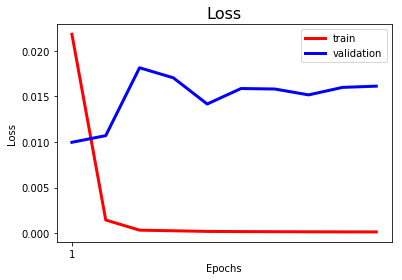

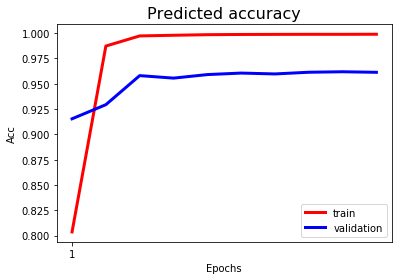

In [7]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
get_ipython().run_line_magic('matplotlib', 'inline')
f = open('./result/ash_sand_1_16_vgg13_result.txt', 'a')

print('loss_train: ' + str(loss_train))
print('loss_val: ' + str(loss_val))
print('acc_train: ' + str(acc_train))
print('acc_val: ' + str(acc_val))
f.write('loss_train: ' + str(loss_train) + '\n')
f.write('loss_val: ' + str(loss_val) + '\n')
f.write('acc_train: ' + str(acc_train) + '\n')
f.write('acc_val: ' + str(acc_val) + '\n')
f.close()

# 绘制第一个图，在一幅图上画两条曲线
plt.figure()
plt.title("Loss",fontsize=16)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.xticks(np.arange(1, epochs + 1, 10.0))
plt.plot(range(1,epochs + 1), loss_train,color='r', linewidth = 3.0, label='train')
plt.plot(range(1,epochs + 1), loss_val,color='b', linewidth = 3.0, label='validation')
plt.legend()  # 设置图例和其中的文本的显示

# 绘制第二个图，在一幅图上画两条曲线
plt.figure()
plt.title("Predicted accuracy",fontsize=16)
plt.xlabel("Epochs")
plt.ylabel("Acc")
plt.xticks(np.arange(1, epochs + 1, 10.0))
plt.plot(range(1,epochs + 1), acc_train,color='r', linewidth = 3.0, label='train')
plt.plot(range(1,epochs + 1), acc_val,color='b', linewidth = 3.0, label='validation')
plt.legend()  # 设置图例和其中的文本的显示

plt.show()

#  保存混淆矩阵为excel

In [8]:
from openpyxl import Workbook # xlsx

def save(data, path):
    # xlsx
    workbook = Workbook()
    booksheet = workbook.active  # 获取当前活跃的sheet,默认是第一个sheet
    h = len(data) # 行数
    l = len(data[0]) #列数
    for i in range(h):
        for j in range(l):
            booksheet.cell(i+1, j+1).value = data[i][j]
    workbook.save(path)

save(best_matrix,'./result/ash_sand_1_16_vgg13_confusion_matrix.xlsx')

# Test

In [9]:
# 开始测试
since = time.time()
model.eval()
number = 0
matrix2 = [[0 for i in range(1000)] for i in range(num_classes)]
f = open('./result/ash_sand_1_16_vgg13_result.txt', 'a')
print("=====start test=====")
f.write("=====start test=====")

# Iterate over data.
for data in dataloders_test:
    # get the inputs
    inputs, labels = data
    print('labels: ' + str(labels.data.cpu().numpy()))
    f.write('labels: ' + str(labels.data.cpu().numpy()) + '\n')

    # PyTorch更新至0.4.0后，将Variable和Tensor合并
    if use_gpu:
        inputs = inputs.cuda()
        labels = labels.cuda()

    # 先将网络中的所有梯度置0
    optimizer.zero_grad()

    # 网络的前向传播
    outputs = model(inputs)

    # 计算损失
    loss = loss_fn(outputs, labels)

    # 得到模型预测该样本属于哪个类别的信息
    _, preds = torch.max(outputs.data, 1)
    print('preds: ' + str(preds.data.cpu().numpy()))
    f.write('preds: ' + str(preds.data.cpu().numpy()) + '\n')
    for k in range(batch_size):
        matrix2[labels.data.cpu().numpy()[k]][number] = preds.cpu().numpy()[k]
        number += 1
        if number == 1000:
            number = 0

time_elapsed = time.time() - since
print('Test complete in {:.0f}h {:.0f}m {:.0f}s'.format(time_elapsed // 3600, (time_elapsed % 3600) // 60, time_elapsed % 60))
f.close()

=====start test=====
labels: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
preds: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
labels: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
preds: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
labels: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
preds: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
labels: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
preds: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
labels: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
preds: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
labels: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
preds: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
labels: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
preds: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
labels

preds: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
labels: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
preds: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
labels: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
preds: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
labels: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
preds: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
labels: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
preds: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
labels: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
preds: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
labels: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
preds: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
labels: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2]
preds: [1 1 1 1 1 1 1 1 1 1

preds: [3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]
labels: [3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]
preds: [3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]
labels: [3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]
preds: [3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]
labels: [3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]
preds: [3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]
labels: [3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]
preds: [3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]
labels: [3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]
preds: [3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]
labels: [3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]
preds: [3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]
labels: [3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]
preds: [3 3 3 3 3 3 3 3 3 3

preds: [5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5]
labels: [5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5]
preds: [5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5]
labels: [5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5]
preds: [5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5]
labels: [5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5]
preds: [5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5]
labels: [5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5]
preds: [5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5]
labels: [5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5]
preds: [5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5]
labels: [5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5]
preds: [5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5]
labels: [5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5]
preds: [5 5 5 5 5 5 5 5 5 5

preds: [7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
labels: [7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
preds: [7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
labels: [7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
preds: [7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
labels: [7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
preds: [7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
labels: [7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
preds: [7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 6 7 7]
labels: [7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
preds: [ 7  7  7  7  7  7  7  7  6  7  7  7  7  7  7  7  7  7  7 44  7  7  7  7
  7  7  7  7  7  7]
labels: [7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
preds: [7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
labels: [7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7

preds: [8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8]
labels: [8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8]
preds: [8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8]
labels: [8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8]
preds: [8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8]
labels: [9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9]
preds: [9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9]
labels: [9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9]
preds: [9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9]
labels: [9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9]
preds: [9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9]
labels: [9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9]
preds: [9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9]
labels: [9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9]
preds: [9 9 9 9 9 9 9 9 9 9

labels: [10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10
 10 10 10 10 10 10]
preds: [10 10 10  9  9 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10
 10 10 10 10 10 10]
labels: [10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10
 10 10 10 10 10 10]
preds: [10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10
 10 10 10 10 10 10]
labels: [10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10
 10 10 10 10 10 10]
preds: [10 10 10 10 10 10 10 10 10 10 10 10 10  9 10 10 10 10 10 10 10 10 10 10
 10 10 10 10 10 10]
labels: [10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10
 10 10 10 10 10 10]
preds: [10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10
 10 10 10 10 10 10]
labels: [10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10
 10 10 10 10 10 10]
preds: [10 10 10 10 10 10 10 10  9 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10
 10 10 10 10 10

preds: [11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11
 11 11 11 11 11 11]
labels: [11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11
 11 11 11 11 11 11]
preds: [11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11
 11 11 11 11 11 11]
labels: [11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11
 11 11 11 11 11 11]
preds: [11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 10
 10 11 10 10 10 11]
labels: [11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11
 11 11 11 11 11 11]
preds: [10 11 11 10 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11
 11 11 11 11 11 11]
labels: [11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11
 11 11 11 11 11 11]
preds: [11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11
 11 11 11 11 11 11]
labels: [11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11
 11 11 11 11 11

preds: [12 12 12 12 12 12 12 12 12 12 13 13 13 13 13 13 13 13 13 13 13 13 13 13
 13 13 13 13 13 13]
labels: [13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13
 13 13 13 13 13 13]
preds: [13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13
 13 13 13 13 13 13]
labels: [13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13
 13 13 13 13 13 13]
preds: [13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13
 13 13 13 13 13 13]
labels: [13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13
 13 13 13 13 13 13]
preds: [13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13
 13 13 13 13 13 13]
labels: [13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13
 13 13 13 13 13 13]
preds: [13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13
 13 13 13 13 13 13]
labels: [13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13
 13 13 13 13 13

preds: [23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23
 23 23 23 23 23 23]
labels: [23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23
 23 23 23 23 23 23]
preds: [23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23
 23 23 23 23 23 23]
labels: [23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23
 23 23 23 23 23 23]
preds: [23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 29 29 23 29 23 23
 23 23 23 23 23 23]
labels: [23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23
 23 23 23 23 23 23]
preds: [23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23
 23 23 23 23 23 23]
labels: [23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23
 23 23 23 23 23 23]
preds: [23 23 23 23 23 25  6  6 20 23 23 23 23 23 23 24 23 23 23 23 23 23 23 23
 23 23 23 23 23 23]
labels: [23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23
 23 23 23 23 23

preds: [23 23 23 24 23 24 23 23 23 23 23 23 23 23 23 23 24 24 23 23 23 23 23 23
 23 23 23 23 24 23]
labels: [24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24
 24 24 24 24 24 24]
preds: [23 23 23 23 23 23 23 24 24 24 23 23 24 23 24 23 24 24 23 23 24 23 24 23
 23 23 24 23 23 24]
labels: [24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24
 24 24 24 24 24 24]
preds: [24 24 23 23 24 23 24 24 23 23 23 23 24 23 23 23 23 23 23 24 23 23 23 24
 23 23 23 23 23 24]
labels: [24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24
 24 24 24 24 24 24]
preds: [24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24
 24 24 24 24 24 24]
labels: [24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24
 24 24 24 24 24 24]
preds: [24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24
 24 24 24 24 24 24]
labels: [24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24
 24 24 24 24 24

preds: [25 25 25 25 25 25 25 25 25 23 23 23 25 23 23 23 23 23 23 23 23 23 23 25
 23 23 23 25 25 25]
labels: [25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25
 25 25 25 25 25 25]
preds: [25 25 25 25 25 25 25 24 24 25 24 25 25 24 25 25 25 24 24 24 24 24 24 24
 24 24 25 24 24 24]
labels: [25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25
 25 25 25 25 25 25]
preds: [25 25 25 24 24 24 24 25 24 24 24 24 24 24 24 24 24 24 25 24 24 24 24 24
 24 24 24 24 24 25]
labels: [25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25
 25 25 25 25 25 25]
preds: [25 24 24 24 24 24 24 24 24 24 25 25 25 24 24 24 24 24 24 24 24 24 25 24
 24 24 24 24 24 24]
labels: [25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25
 25 25 25 25 25 25]
preds: [24 24 24 25 24 24 24 25 24 24 25 24 24 24 25 24 24 24 24 24 24 20 24 23
 24 25 24 24 24 24]
labels: [25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25
 25 25 25 25 25

preds: [27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27
 27 27 27 27 27 27]
labels: [27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27
 27 27 27 27 27 27]
preds: [27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27
 27 27 27 27 27 27]
labels: [27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27
 27 27 27 27 27 27]
preds: [27 26 27 27 27 27 27 27 27 27 27 27 27 27 27 25 27 27 27 27 27 27 27 27
 27 27 27 27 27 27]
labels: [27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27
 27 27 27 27 27 27]
preds: [27 27 27 27 27 27 27 27 27 27 27 27 27 26 26 26 26 26 27 26 27 27 27 27
 27 27 27 27 27 27]
labels: [27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27
 27 27 27 27 27 27]
preds: [27 27 27 27 27 27 27 26 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27
 27 27 27 27 27 27]
labels: [27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27
 27 27 27 27 27

preds: [26 28 26 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28
 28 28 28 28 28 28]
labels: [28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28
 28 28 28 28 28 28]
preds: [28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28
 28 28 28 28 28 28]
labels: [28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28
 28 28 28 28 28 28]
preds: [28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28
 28 28 28 28 28 28]
labels: [28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28
 28 28 28 28 28 28]
preds: [28 28 28 28 28 28 25 28 28 28 28 28 28 28 28 28 28  6 28 28 28 28 28 28
 28 28 28 28  6 28]
labels: [28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28
 28 28 28 28 28 28]
preds: [28 28 28 28 28 28 28 28 28 25 28 28 28 28 28 28 28 28 28 28 28 28 28 28
 28 28 28 28 28 28]
labels: [28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28
 28 28 28 28 28

preds: [31 31 31 31 31 31 26 31 31 31 29 31 31 26 31 31 26 31 31 31 31 29 29 29
 29 29 29 29 29 29]
labels: [29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29
 29 29 29 29 29 29]
preds: [29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29
 29 29 29 29 29 29]
labels: [29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29
 29 29 29 29 29 29]
preds: [29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29
 29 29 29 29 29 29]
labels: [29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29
 29 29 29 29 29 29]
preds: [29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29
 29 29 29 29 29 29]
labels: [29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29
 29 29 29 29 29 29]
preds: [29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29
 29 29 29 29 29 29]
labels: [29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29
 29 29 29 29 29

labels: [30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30
 30 30 30 30 30 30]
preds: [30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30
 30 30 30 30 30 30]
labels: [30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30
 30 30 30 30 30 30]
preds: [30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30
 30 30 30 30 30 30]
labels: [30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30
 30 30 30 30 30 30]
preds: [30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30
 30 30 30 30 30 30]
labels: [30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30
 30 30 30 30 30 30]
preds: [30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30
 30 30 30 30 30 30]
labels: [30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30
 30 30 30 30 30 30]
preds: [30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30
 30 30 30 30 30

preds: [32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32
 32 32 32 32 32 32]
labels: [32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32
 32 32 32 32 32 32]
preds: [32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32
 32 32 32 32 32 32]
labels: [32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32
 32 32 32 32 32 32]
preds: [32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32
 32 32 32 32 32 32]
labels: [32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32
 32 32 32 32 32 32]
preds: [32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32
 32 32 32 32 32 32]
labels: [32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32
 32 32 32 32 32 32]
preds: [32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32
 32 32 32 32 32 32]
labels: [32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32
 32 32 32 32 32

preds: [ 6 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33
 33 33 33 33 33 33]
labels: [33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33
 33 33 33 33 33 33]
preds: [33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33
 33 33 33 33 33 33]
labels: [33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33
 33 33 33 33 33 33]
preds: [33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33
 33 33 33 33 33 33]
labels: [33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33
 33 33 33 33 33 33]
preds: [33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33
 33 33 33 33 33 33]
labels: [33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33
 33 33 33 33 33 33]
preds: [33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33
 33 33 33 33 33 33]
labels: [33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33
 33 33 33 33 33

preds: [34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34
 34 34 34 34 34 34]
labels: [34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34
 34 34 34 34 34 34]
preds: [34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34
 34 34 34 34 34 34]
labels: [34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34
 34 34 34 34 34 34]
preds: [34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34
 34 34 34 34 34 34]
labels: [34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34
 34 34 34 34 34 34]
preds: [34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34
 34 34 34 34 34 34]
labels: [34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34
 34 34 34 34 34 34]
preds: [34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34
 34 34 34 34 34 34]
labels: [34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34
 34 34 34 34 34

preds: [35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35
 35 35 35 35 35 35]
labels: [35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35
 35 35 35 35 35 35]
preds: [35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35
 35 35 35 35 35 35]
labels: [35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35
 35 35 35 35 35 35]
preds: [35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35
 35 35 35 35 35 35]
labels: [35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35
 35 35 35 35 35 35]
preds: [35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35
 35 35 35 35 35 35]
labels: [35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35
 35 35 35 35 35 35]
preds: [35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35
 35 35 35 35 35 35]
labels: [35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35
 35 35 35 35 35

preds: [37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37
 37 37 37 37 37 37]
labels: [37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37
 37 37 37 37 37 37]
preds: [37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37
 37 37 37 37 37 37]
labels: [37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37
 37 37 37 37 37 37]
preds: [37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37
 37 37 37 37 37 37]
labels: [37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37
 37 37 37 37 37 37]
preds: [37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37
 37 37 37 37 37 37]
labels: [37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37
 37 37 37 37 37 37]
preds: [37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37
 37 37 37 37 37 37]
labels: [37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37
 37 37 37 37 37

labels: [38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38
 38 38 38 38 38 38]
preds: [38 38 38 38 38 38 38 38 38 38 38 38 38 37 38 38 38 38 38 38 38 38 38 38
 38 37 38 38 38 38]
labels: [38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38
 38 38 38 38 38 38]
preds: [38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 37 38 38 38 38 38 38
 38 38 38 38 37 38]
labels: [38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38
 38 38 38 38 38 38]
preds: [38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38
 38 38 38 38 38 38]
labels: [38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38
 38 38 38 38 38 38]
preds: [38 38 37 37 37 37 37 37 37 37 37 37 38 37 37 37 37 37 37 37 37 37 37 38
 37 37 37 37 37 37]
labels: [38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38
 38 38 38 38 38 38]
preds: [37 37 37 37 37 37 37 37 37 37 38 37 38 38 38 38 38 38 38 38 37 38 38 38
 38 38 37 38 37

preds: [39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39
 39 39 39 39 39 39]
labels: [39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39
 39 39 39 39 39 39]
preds: [39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39
 39 39 39 39 39 39]
labels: [39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39
 39 39 39 39 39 39]
preds: [39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39
 39 39 39 39 39 39]
labels: [39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39
 39 39 39 39 39 39]
preds: [39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39
 39 39 39 39 39 39]
labels: [39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39
 39 39 39 39 39 39]
preds: [39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39
 39 39 39 39 39 39]
labels: [39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39
 39 39 39 39 39

preds: [40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40
 40 40 40 40 40 40]
labels: [40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40
 40 40 40 40 40 40]
preds: [40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40
 40 40 40 40 40 40]
labels: [40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40
 40 40 40 40 40 40]
preds: [40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40
 40 40 40 40 40 40]
labels: [40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40
 40 40 40 40 40 40]
preds: [40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40
 40 40 40 40 40 40]
labels: [40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40
 40 40 40 40 40 40]
preds: [40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40
 40 40 40 40 40 40]
labels: [40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 41 41 41 41
 41 41 41 41 41

preds: [42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42
 42 42 42 42 42 42]
labels: [42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42
 42 42 42 42 42 42]
preds: [42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42
 42 42 42 42 42 42]
labels: [42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42
 42 42 42 42 42 42]
preds: [42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42
 42 42 42 42 42 42]
labels: [42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42
 42 42 42 42 42 42]
preds: [42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42
 42 42 42 42 42 42]
labels: [42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42
 42 42 42 42 42 42]
preds: [42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42
 42 42 42 42 42 42]
labels: [42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42
 42 42 42 42 42

preds: [43 43 43 43 43 43 43 38 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43
 43 43 43 43 43 43]
labels: [43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43
 43 43 43 43 43 43]
preds: [43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43
 43 43 43 43 43 43]
labels: [43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43
 43 43 43 43 43 43]
preds: [43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43
 43 43 43 43 43 43]
labels: [43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43
 43 43 43 43 43 43]
preds: [43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43
 43 43 43 43 43 43]
labels: [43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43
 43 43 43 43 43 43]
preds: [43 43 43 43 43 43 43 43 43 43 43 43 43 43 38 43 43 43 43 38 43 38 38 43
 38 38 38 38 43 38]
labels: [43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43
 43 43 43 43 43

preds: [44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44
 44 44 44 44 44 44]
labels: [44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44
 44 44 44 44 44 44]
preds: [44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44
 44 44 44 44 44 44]
labels: [44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44
 44 44 44 44 44 44]
preds: [44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44
 44 44 44 44 44 44]
labels: [44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44
 44 44 44 44 44 44]
preds: [44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44
 44 44 44 44 44 44]
labels: [44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44
 44 44 44 44 44 44]
preds: [44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44
 44 44 44 44 44 44]
labels: [44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44
 44 44 44 44 44

In [13]:
# conc 浓度
matrix_conc = [[0 for i in range(1000)] for i in range(num_classes)]
concentration = []
density = 200
while True:
    concentration.append(density)
    if density == 780:
        break
    if density < 600:
        density += 50
    else:
        density += 5
print(concentration)
for x in range(num_classes):
    for y in range(1000):
        matrix_conc[x][y] = concentration[matrix2[x][y]]  # matrix2:0-44; concentration:200-780

for label in range(num_classes):
    count = 0
    print(label)
    for k in range(1000):
        if matrix2[label][k] == label:
            count += 1
    print(" - 预测正确数量：" + str(count))
        # 方差
    var = np.var(matrix_conc[label])
    print(" - 方差：" + str(var))

[200, 250, 300, 350, 400, 450, 500, 550, 600, 605, 610, 615, 620, 625, 630, 635, 640, 645, 650, 655, 660, 665, 670, 675, 680, 685, 690, 695, 700, 705, 710, 715, 720, 725, 730, 735, 740, 745, 750, 755, 760, 765, 770, 775, 780]
0
 - 预测正确数量：997
 - 方差：269.18999999999994
1
 - 预测正确数量：1000
 - 方差：0.0
2
 - 预测正确数量：1000
 - 方差：0.0
3
 - 预测正确数量：1000
 - 方差：0.0
4
 - 预测正确数量：1000
 - 方差：0.0
5
 - 预测正确数量：1000
 - 方差：0.0
6
 - 预测正确数量：1000
 - 方差：0.0
7
 - 预测正确数量：988
 - 方差：130.79840000000004
8
 - 预测正确数量：1000
 - 方差：0.0
9
 - 预测正确数量：994
 - 方差：0.1496
10
 - 预测正确数量：961
 - 方差：1.1558999999999997
11
 - 预测正确数量：984
 - 方差：65.514975
12
 - 预测正确数量：997
 - 方差：4.785600000000001
13
 - 预测正确数量：1000
 - 方差：0.0
14
 - 预测正确数量：533
 - 方差：6.2227749999999995
15
 - 预测正确数量：1000
 - 方差：0.0
16
 - 预测正确数量：1000
 - 方差：0.0
17
 - 预测正确数量：994
 - 方差：105.45497500000003
18
 - 预测正确数量：283
 - 方差：175.95589999999999
19
 - 预测正确数量：1000
 - 方差：0.0
20
 - 预测正确数量：1000
 - 方差：0.0
21
 - 预测正确数量：984
 - 方差：0.39359999999999995
22
 - 预测正确数量：759
 - 方差：4.572975000000001
23
 - 预测

In [14]:
var_sum = 0
for label in range(num_classes):
    var_sum += np.var(matrix_conc[label])
var_ave = var_sum / num_classes
print("平均方差：" + str(var_ave))

平均方差：25.32571611111111


In [15]:
acc_count = 0
for label in range(num_classes):
    for k in range(1000):
        if matrix2[label][k] == label:
            acc_count += 1
print("测试集正确率：" + str(acc_count/len(image_datasets_test)))

测试集正确率：0.9159111111111111


In [16]:
# 75%-78%浓度方差
var_sum2 = 0
for label in range(38, 45):
    var_sum2 += np.var(matrix_conc[label])
var_ave2 = var_sum2 / num_classes
print("75%-78%浓度平均方差：" + str(var_ave2))

75%-78%浓度平均方差：0.7968472222222223


# 查看波动性

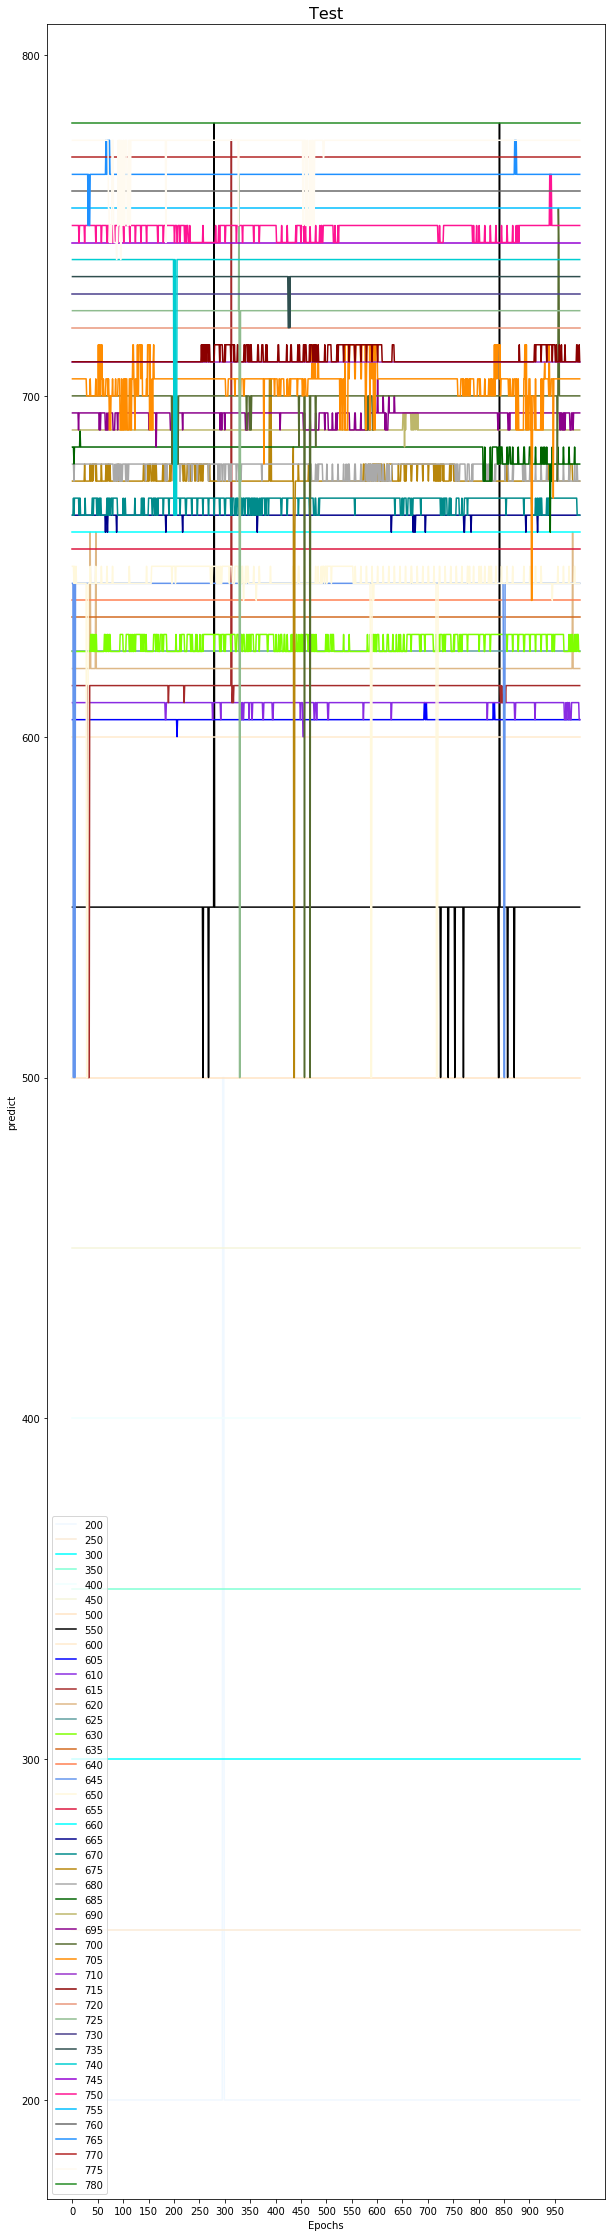

In [18]:
import matplotlib
import matplotlib.pyplot as plt
get_ipython().run_line_magic('matplotlib', 'inline')

colors = ['#F0F8FF', '#FAEBD7', '#00FFFF', '#7FFFD4', '#F0FFFF', '#F5F5DC', '#FFE4C4', '#000000', '#FFEBCD', '#0000FF', '#8A2BE2', '#A52A2A', '#DEB887', '#5F9EA0', '#7FFF00', '#D2691E', '#FF7F50', '#6495ED', '#FFF8DC', '#DC143C', '#00FFFF', '#00008B', '#008B8B', '#B8860B', '#A9A9A9', '#006400', '#BDB76B', '#8B008B', '#556B2F', '#FF8C00', '#9932CC', '#8B0000', '#E9967A', '#8FBC8F', '#483D8B', '#2F4F4F', '#00CED1', '#9400D3', '#FF1493', '#00BFFF', '#696969', '#1E90FF', '#B22222', '#FFFAF0', '#228B22']

plt.figure(figsize=(10,40))
plt.title('Test',fontsize=16)
plt.xlabel("Epochs")
plt.ylabel("predict")
plt.xticks(np.arange(0, 1000, 50))
for label in range(num_classes):
    plt.plot(range(1000), matrix_conc[label],color=colors[label], label=str(concentration[label]))
    plt.legend()  # 设置图例和其中的文本的显示

plt.show()